In [8]:
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from transformers.optimization import AdamW
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from pathlib import Path
import os
from itertools import compress
import utils

In [9]:
from torch.utils.data import DataLoader
from apex.optimizers.fused_lamb import FusedLAMB as Lamb
from fairseq import criterions 
from functools import partial
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from fastai.core import *
from fastai.text import *

In [10]:
path = Path.cwd()

In [11]:
file_dir = Path.cwd()/'data'
train_df = pd.read_csv(file_dir/'train.csv')
train_df['text'] = train_df['text'].apply(lambda x: str(x))
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: str(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x: str(x))

In [12]:
max_len = 128
bs = 32
tokenizer = BertWordPieceTokenizer('input/electra-base-disc/vocab.txt', lowercase=True)

In [13]:
def preprocess(sentiment, tweet, selected, tokenizer, max_len):
    _input = tokenizer.encode(sentiment, tweet)
    _span = tokenizer.encode(selected, add_special_tokens=False)
    
    len_span = len(_span.ids)
    start_idx = None
    end_idx = None
    
    for ind in (i for i, e in enumerate(_input.ids) if e == _span.ids[0]):
        if _input.ids[ind: ind + len_span] == _span.ids:
            start_idx = ind
            end_idx = ind + len_span - 1
            break
    
    # Handles cases where Wordpiece tokenizing input & span separately produces different outputs
    if not start_idx:
        idx0 = tweet.find(selected)
        idx1 = idx0 + len(selected)
        
        char_targets = [0] * len(tweet)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1):
                char_targets[ct] = 1
                
        tweet_offsets = list(compress(_input.offsets, _input.type_ids))[0:-1]
        
        target_idx = []
        for j, (offset1, offset2) in enumerate(tweet_offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                target_idx.append(j)
                
        start_idx, end_idx = target_idx[0] +3 , target_idx[-1] + 3
        
    _input.start_target = start_idx
    _input.end_target = end_idx
    _input.tweet = tweet
    _input.sentiment = sentiment
    _input.selected = selected
    
    _input.pad(max_len)
    
    return _input

In [14]:
class TweetDataset(Dataset):
    def __init__(self, dataset):
        self.df = dataset
        
    def __getitem__(self, idx):
        sentiment, tweet, selected = (self.df[col][idx] for col in ['sentiment', 'text', 'selected_text'])
        _input = preprocess(sentiment, tweet, selected, tokenizer, max_len)
        
        
        xb = [torch.LongTensor(_input.ids),
              torch.LongTensor(_input.attention_mask),
              torch.LongTensor(_input.type_ids),
              np.array(_input.offsets)]
        
        yb = [torch.tensor(_input.start_target), torch.tensor(_input.end_target)]

        return xb, yb     

    def __len__(self):
        return len(self.df)

In [15]:
config = AutoConfig.from_pretrained('google/electra-base-discriminator')
config.output_hidden_states = True
pt_model = AutoModel.from_pretrained('google/electra-base-discriminator', config = config)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/google/electra-base-discriminator/config.json from cache at /home/jack/.cache/torch/transformers/9236d197566a7f1be2b2151f5afcc5a8e17f31e1e23c52f3cdf2340019986e78.88ba6e8e7d5a7936e86d6f2551fe19c236dc57c24da163907cd0544e9933f6ee
INFO:transformers.configuration_utils:Model config ElectraConfig {
  "_num_labels": 2,
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "embedding_size": 768,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    

In [16]:
class SpanModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = pt_model
        self.drop_out = nn.Dropout(0.1)
        self.qa_outputs = nn.Linear(768 * 2, 2) # update hidden size

    # could pass offsets here and not use - can grab in last_input
    def forward(self, input_ids, attention_mask, token_type_ids, offsets = None):
        
        _, hidden_states = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)
        out = self.drop_out(out)
        logits = self.qa_outputs(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [17]:
class CELoss(Module):
    def __init__(self): self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, inputs, start_targets, end_targets):
        start_logits, end_logits = inputs # assumes tuple input
        
        logits = torch.cat([start_logits, end_logits]).contiguous()
        
        targets = torch.cat([start_targets, end_targets]).contiguous()
        
        return self.loss_fn(logits, targets)

In [18]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [19]:
# Note that validation ds is by default not shuffled in fastai - so indexing like this will work for Callback
# https://forums.fast.ai/t/how-to-set-shuffle-false-of-train-and-val/33730

class JaccardScore(Callback):
    "Stores predictions and targets to perform calculations on epoch end."
    def __init__(self, valid_ds): 
        self.valid_ds = valid_ds
        self.context_text = valid_ds.df.text
        self.answer_text = valid_ds.df.selected_text
        
    def on_epoch_begin(self, **kwargs):
        self.jaccard_scores = []  
        self.valid_ds_idx = 0
        
        
    def on_batch_end(self, last_input:Tensor, last_output:Tensor, last_target:Tensor, **kwargs):
              
        input_ids = last_input[0]
        attention_masks = last_input[1].bool()
        token_type_ids = last_input[2].bool()
        offsets = last_input[3]

        start_logits, end_logits = last_output
        
        # for id in batch of ids
        for i in range(len(input_ids)):
            
            _offsets = offsets[i]
            start_idx, end_idx = torch.argmax(start_logits[i]), torch.argmax(end_logits[i])
            _answer_text = self.answer_text[self.valid_ds_idx]
            original_start, original_end = _offsets[start_idx][0], _offsets[end_idx][1]
            pred_span = self.context_text[self.valid_ds_idx][original_start : original_end]
                
            score = jaccard(pred_span, _answer_text)
            self.jaccard_scores.append(score)

            self.valid_ds_idx += 1
            
    def on_epoch_end(self, last_metrics, **kwargs):        
        res = np.mean(self.jaccard_scores)
        return add_metrics(last_metrics, res)

In [38]:
def model_split_func(m): 
    "4 layer groups"
    n = len(m.sequence_model.encoder.layer)//2
    return (m.sequence_model.embeddings, m.sequence_model.encoder.layer[:n], m.sequence_model.encoder.layer[n:], m.head)

In [37]:
def model_split_func(m): 
    n = len(m.sequence_model.encoder.layer) - 5
    return (m.sequence_model.embeddings, m.sequence_model.encoder.layer[n], m.head)

In [38]:
from fastai.callbacks import *

def new_on_train_begin(self, **kwargs:Any)->None:
    "Initializes the best value."
    if not hasattr(self, 'best'):
        self.best = float('inf') if self.operator == np.less else -float('inf')

SaveModelCallback.on_train_begin = new_on_train_begin

In [41]:
model = AutoModel.from_pretrained(PRETRAINED_TYPE)
os.makedirs(f"{PRETRAINED_TYPE}-config", exist_ok=True)
model.config.save_pretrained(f"{PRETRAINED_TYPE}-config")
del model; gc.collect()

507

In [22]:
from fastai.callbacks import *
### Simple no jaccard test
from sklearn.model_selection import train_test_split

tr_df, val_df = train_test_split(train_df[train_df['sentiment']!='neutral'], test_size = 0.2, random_state = 42)
tr_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)

train_ds, valid_ds = [TweetDataset(i) for i in [tr_df,val_df]]
data = DataBunch.create(train_ds, valid_ds,bs = bs)

# LEARNER
model = SpanModel()
learner = Learner(data, model, loss_func=CELoss(), opt_func= Lamb, metrics=[JaccardScore(valid_ds)])
# learner.split(model_split_func)
# learner.to_fp16() 

# # CALLBACKS
early_stop_cb = EarlyStoppingCallback(learner, monitor='jaccard_score',mode='max',patience=2)
# save_model_cb = SaveModelCallback(learner,every='improvement',monitor='jaccard_score',name=f'{MODEL_TYPE}-qa-finetune')
# csv_logger_cb = CSVLogger(learner, f"training_logs_{foldnum}", True)

In [14]:
learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 7.04 GiB already allocated; 19.62 MiB free; 7.08 GiB reserved in total by PyTorch)

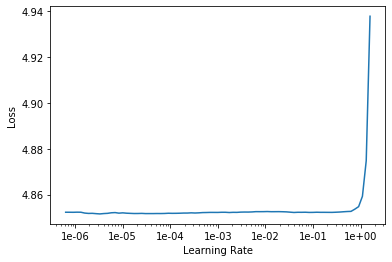

In [106]:
learner.recorder.plot()

In [23]:
lr = 3e-5

# Last Param Group
# learner.freeze_to(3);
learner.fit_one_cycle(4, lr, pct_start=0.4, div_factor=50, wd=0.01, callbacks=[early_stop_cb])

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, device='cuda:0')
positive thanks will try to behave
 thanks will try to behave
Predict = thanks will try to behave
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative today is lame because i am not in orlando i am soooo looking forward to next friday
Today is lame because I am not in Orlando  I am soooo looking forward to NEXT friday
Predict = Today is lame
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
positive hahahaha! i laughed my * * * * off just now. thanks
 hahahaha! i laughed my **** off just now. thanks
Predict = hahahaha!
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
negative gahh! this weather sucksss!
Gahh ! This weather sucksss !
Predict = Gahh ! This weather sucksss !
tensor(3, device='cuda:0'

tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(1, device='cuda:0') tensor(36, device='cuda:0')
positive she ` s unassuming and unpretentious. she ` s just, as. i suppose that ` s why she ` s so endearing - - because we can relate to her
 She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing--because we can relate to her
Predict = She`s unassuming and unpretentious.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
negative i know man, my day off and am pulling myself out of bed
 I know man, my day off and am pulling myself out of bed
Predict = I know man,
tensor(21, device='cuda:0') tensor(30, device='cuda:0')
tensor(70, device='cuda:0') tensor(91, device='cuda:0')
negative power outage, door to freezer propped open, 3g ice cream make for slippy floor m - er f - er!!
Power Outage, door to freezer propped open, 3G ice cream make for slippy floor  M-er F-er!!
Predict = py floor

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative annoyed
Annoyed
Predict = Annoyed
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(0, device='cuda:0') tensor(120, device='cuda:0')
negative sorry to tweet about bgt but poor wonderful crazy weird greg so not fair. the silly little girl is never going to cope. urgh. not fair.
sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
Predict = sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope.
tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
negative sick. feel like jello, can ` t talk, and delirious.
Sick. Feel like jello, can`t talk, and delirious.
Predict = Sick. Feel like jello, can`t talk, and delirious.
tensor(3, device='cuda:0') tensor(36, device

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative holy * * * * i am exhausted! resting up so i can go see wolverine later
Holy **** I am exhausted! Resting up so I can go see Wolverine later
Predict = Holy **** I am exhausted!
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(42, device='cuda:0') tensor(53, device='cuda:0')
positive search ryan carera & josh kelley they ` re really good
Search Ryan Carera & Josh Kelley  They`re really good
Predict = really good
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(53, device='cuda:0')
positive i know!! our cats could be family mikesh is so cute!!
 I know!! our cats could be family  mikesh is so cute!!
Predict = I know!! our cats could be family  mikesh is so cute
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
positive soooo happy your back!
 Soooo happy your b

tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(94, device='cuda:0')
positive nothin better then ridin in a car with your sister while blasting th, cb and lady gaga so loud you cant hear yourself screamin the lyrics
Nothin better then ridin in a car with your sister while blasting TH, CB and Lady Gaga so loud you cant hear yourself screamin the lyrics
Predict = Nothin better then ridin in a car with your sister while blasting TH, CB and Lady Gaga so loud
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(84, device='cuda:0')
positive just finished wander girl for the nth time - - hilda gallares is truly a kindred soul.
just finished Wander Girl for the nth time-- Hilda Gallares is truly a kindred soul.
Predict = just finished Wander Girl for the nth time-- Hilda Gallares is truly a kindred soul.
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(33, device='cuda:0')
posi

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive wonderful weekend i love my family & friends because they are awesome. happy mothers day to all the mommies < 3
Wonderful weekend  I love my family  & friends because they are awesome. Happy Mothers day to all the mommies <3
Predict = Wonderful weekend
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(41, device='cuda:0')
negative i was afraid you were going to say that.
 I was afraid you were going to say that.
Predict = I was afraid you were going to say that.
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
tensor(6, device='cuda:0') tensor(24, device='cuda:0')
negative tgif. i don ` t feel good.
TGIF. I don`t feel good.
Predict = I don`t feel good.
tensor(3, device='cuda:0') tensor(26, device='cuda:0')
tensor(1, device='cuda:0') tensor(81, device='cuda:0')
negative haha you didnt see my macbook or my 24 ` ` imac in that p

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive boredddddd follower shes amazing!! * broken *
Boredddddd Follower  Shes AMAZING!!  *Broken*
Predict = Boredddddd Follower  Shes AMAZING!!
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(63, device='cuda:0')
negative have been to portugal. and spain. and has a sore throat. scary?
have been to portugal. and spain. and has a sore throat. scary?
Predict = have been to portugal. and spain. and has a sore throat. scary?
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(82, device='cuda:0')
positive finished my capital transactions exam... as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
finished my capital transactions exam . . . as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
Predict = finished my capital tr

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative my knee is killing me
My knee is killing me
Predict = My knee is killing
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative i right here... don ` t worry
I right here...don`t worry
Predict = I right here...don`t worry
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive my pleasure, its a great recipe
 my pleasure, its a great recipe
Predict = my pleasure, its a great recipe
tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(4, device='cuda:0') tensor(12, device='cuda:0')
positive $ rz hope so. time will tell. good luck $ $
$RZ Hope so.  Time will tell.  Good luck   $$
Predict = Hope so.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive thank god camera fixed its

tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(47, device='cuda:0')
positive peter!! follow me!! oh and have fun in europe!
 peter!! follow me!! oh and have fun in europe!
Predict = peter!! follow me!! oh and have fun in europe!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive happy friday! do u know how i can get a copy of the bt art u did on mel ` s fake twitter? i ` m n it, but can ` t find it now. thx
 Happy Friday! Do u know how I can get a copy of the BT art u did on Mel`s fake Twitter? I`m n it, but can`t find it now.  THX
Predict = Happy Friday!
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive have a awesome day at school!!!
 have a awesome day at school!!!
Predict = have a awesome day at school!!!
tensor(4, device='cuda:0') tensor(33, device='cuda:0')
tensor(6, device='cuda:0') tensor(114, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive its probable bed time. hugs and kisses < 33
its probable bed time. hugs and kisses  <33
Predict = its probable bed time.
tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(6, device='cuda:0') tensor(26, device='cuda:0')
negative ii boring - bad weather today, watchingn alias and having fun with my boyfriend
iï¿½m boring - bad weather today, watchingn alias and having fun  with my boyfriend
Predict = boring - bad weather
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive thanks hun, it was great
 Thanks hun, it was great
Predict = Thanks hun,
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(1, device='cuda:0') tensor(41, device='cuda:0')
positive well, all i can do, is pray for you.....
 Well, all I can do, is pray for you.....
Predict = Well, all I can do, is pray for you.....
tens

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative ughhhh.... sad day.
ughhhh.... sad day.
Predict = ughhhh.... sad day.
tensor(41, device='cuda:0') tensor(28, device='cuda:0')
tensor(99, device='cuda:0') tensor(63, device='cuda:0')
positive home from sting.. crunk ( of course ).. long * * * * day n nite.. also, visited my boy rob v.. all is good.. happy mother ` s day!!.. word to yo mutha
home from STING..crunk (of course)..long **** day N nite..also, visited my boy Rob V..all is good..happy mother`s day!!..word to yo mutha
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
tensor(10, device='cuda:0') tensor(34, device='cuda:0')
positive _ kittykat that ` s very nice of him.
_KittyKat That`s very nice of him.
Predict = That`s very nice of him.
tensor(4, device='cuda:0') tensor(21, device='cuda:0')
tensor(8, device='cuda:0') tensor(71, device='cuda:0')
negative youtube is made of fail right now. or maybe it ` s jus

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative * * * * your in trouble now why don ` t you try with one of those companys that buys your house for you
 **** your in trouble now  why don`t you try with one of those companys that buys your house for you
Predict = **** your in trouble
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(22, device='cuda:0')
positive aw. i ` m glad you do. where would we be with out one?
 aw.  I`m glad you do. Where would we be with out one?
Predict = aw.  I`m glad you do.
tensor(7, device='cuda:0') tensor(12, device='cuda:0')
tensor(24, device='cuda:0') tensor(47, device='cuda:0')
negative come back to perth i missed the show here!
 come back to Perth     I missed the show here!
Predict = I missed the show here!
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(42, device='cuda:0')
negative i apparently have cra

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative link didn ` t work
 Link didn`t work
Predict = Link didn`t work
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
negative weekend with my cuzzo vivi, i can ` t stand to have her leave me in 3 weeks
weekend with my cuzzo Vivi, I can`t stand to have her leave me in 3 weeks
Predict = weekend with my cuzzo Vivi,
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0') tensor(45, device='cuda:0')
positive awww wish i was there! have a brew for me b!
 awww wish I was there! Have a brew for me B!
Predict = awww wish I was there! Have a brew for me B!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(65, device='cuda:0')
negative i must be the only fool in twitterland that doesn ` t get retweet!! # sadsville
I must be the only fool in twitterland that doe

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
positive you got it. poor thing not gonna have a choice for much longer though
 you got it. poor thing not gonna have a choice for much longer though
Predict = you got it. poor thing
tensor(11, device='cuda:0') tensor(10, device='cuda:0')
tensor(27, device='cuda:0') tensor(27, device='cuda:0')
positive going to the alley tonite.. happy birthday prima
Going to the alley tonite..Happy Birthday prima
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(75, device='cuda:0')
positive awaiting to watch lfctv @ 10am liverpool vs newcastle game from yesterday!
Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
Predict = Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
tensor(19, device='cuda:0') tensor(31, device='cuda:0')
tensor(54, device='cuda:0') tensor(93, device='cuda:0')
positive 12 : 06am and

tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(65, device='cuda:0')
negative had to give my 5 year old golden retriever away to another family today # sad http : / / bit. ly / s48d0
had to give my 5 year old golden retriever away to another family today  #sad http://bit.ly/s48D0
Predict = had to give my 5 year old golden retriever away to another family
tensor(19, device='cuda:0') tensor(21, device='cuda:0')
tensor(27, device='cuda:0') tensor(39, device='cuda:0')
positive http : / / twitpic. com / 67wb4 - gotta a show on monday at 9.... hopefully my head will be better by then....
http://twitpic.com/67wb4 - Gotta a show on Monday at 9.... hopefully my head will be better by then....
Predict = Gotta a show
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
positive i hope you feel better soon
 I hope you feel better soon
Predict = I hope you feel better soon
tensor(3, device='cuda:0') ten

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
positive happy mothers day! im gunna crawl up in a ball and act like i dont exist lmfaoo
happy mothers day! im gunna crawl up in a ball and act like i dont exist  lmfaoo
Predict = happy mothers day!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(10, device='cuda:0')
positive awesome! all deserved i ` m sure. miss the crabs games
  awesome! All deserved I`m sure. Miss the Crabs games
Predict = awesome!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
positive my saturday was good i cannot wait until this monday night
 my saturday was good  i cannot wait until this monday night
Predict = my saturday was good
tensor(8, device='cuda:0') tensor(11, device='cuda:0')
tensor(6, device='cuda:0') tensor(11, device='cuda:0')
negative _ * * * * awww, that sucks
_**** awww, that sucks
Predict

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
negative whatever. i give up, my phones about to die anyway. next time
whatever. i give up, my phones about to die anyway.  next time
Predict = whatever.
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
positive wish u was in the d!
 wish u was in the D!
Predict = wish u was in the D!
tensor(6, device='cuda:0') tensor(33, device='cuda:0')
tensor(6, device='cuda:0') tensor(123, device='cuda:0')
positive btw, thanks for the gifts. i ` m wearing my shirt, having a dunker and apple loved that chicken soup ; just what she needed!
 BTW, thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
Predict = thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
tensor(20, device='cuda:0') tensor(20, device='cu

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
negative is not having a good day... i havent had a good week forreal!!
is not having a good day... I havent had a good week forreal!!
Predict = is not having a good day... I havent had a good week forreal!!
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(46, device='cuda:0')
positive the skimchamp taxi service! best in the land!
The Skimchamp Taxi Service!  best in the land!
Predict = The Skimchamp Taxi Service!  best in the land!
tensor(22, device='cuda:0') tensor(5, device='cuda:0')
tensor(74, device='cuda:0') tensor(11, device='cuda:0')
positive if you save these pix from the today show please credit www. wireimage. com thanks
If you save these pix from the Today show please credit www.wireimage.com Thanks
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : /

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(83, device='cuda:0')
positive the beatles? those scousers with funny haircuts? more talent in the banana splits!
 The Beatles? Those scousers with funny haircuts? More talent in The Banana Splits!
Predict = The Beatles? Those scousers with funny haircuts? More talent in The Banana Splits!
tensor(5, device='cuda:0') tensor(25, device='cuda:0')
tensor(7, device='cuda:0') tensor(58, device='cuda:0')
negative _ paige aww hey! i didn ` t know this was you! lol. i ` m sick. no outtie for me.
_paige aww hey! I didn`t know this was you! LOL. I`m sick. No outtie for me.
Predict = aww hey! I didn`t know this was you! LOL. I`m sick.
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
negative i am hungry already. not impressed! and everybody has gone to rubys
I am hungry already. Not impressed! And everybody has gone to Rubys
Predict = I am hungry alre

tensor(5, device='cuda:0') tensor(27, device='cuda:0')
tensor(7, device='cuda:0') tensor(94, device='cuda:0')
negative the vp is gone... so why am i getting a headache? time to have some coffee and fight it off. # migraine # ohnoyoudidnt
The VP is gone...so why am I getting a headache?    Time to have some coffee and fight it off. #migraine #ohnoyoudidnt
Predict = is gone...so why am I getting a headache?    Time to have some coffee and fight it off.
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative i wish our didn ` t close
 I wish our  didn`t close
Predict = I wish
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(1, device='cuda:0') tensor(59, device='cuda:0')
positive lovin ` your performance on snl tonight... so * * * * funny!!!
 Lovin` your performance on snl tonight... so **** funny!!!
Predict = Lovin` your performance on snl tonight... so **** funny!!!
tensor(3, device='cuda:0') tensor(9, device='cud

tensor(17, device='cuda:0') tensor(23, device='cuda:0')
tensor(58, device='cuda:0') tensor(81, device='cuda:0')
negative it gets worse every year and 2010 / 2011 will be the worst. oh, and 6 months today!
it gets worse every year and 2010/2011 will be the worst. oh, and 6 months today!
Predict = oh, and 6 months today!
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(8, device='cuda:0')
positive _ you ah! haha that ` s exciting. if i ever come to australia we are definitely gonna have a movie night, fyi
_you Ah! Haha that`s exciting. If I ever come to Australia we are definitely gonna have a movie night, FYI
Predict = Ah!
tensor(4, device='cuda:0') tensor(16, device='cuda:0')
tensor(6, device='cuda:0') tensor(63, device='cuda:0')
positive yer i hope the competition doesnt end before i post my video! lol but there are some really good singers who entered.....
 yer  i hope the competition doesnt end before i post my video! lol but there are some rea

tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(111, device='cuda:0')
negative yeah, the economy sucks so bad. yeah, i know what a cafeteria is. i ` m unemployed at the moment and i hate it!
 Yeah, the economy sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
Predict = Yeah, the economy sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
tensor(8, device='cuda:0') tensor(13, device='cuda:0')
tensor(11, device='cuda:0') tensor(23, device='cuda:0')
negative your * * * * miss you!!!!
 your **** miss you!!!!
Predict = miss you!!!!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(29, device='cuda:0')
positive oh wow thanks for the info.
 Oh wow  Thanks for the info.
Predict = Oh wow  Thanks for the info.
tensor(12, device='cuda:0') tensor(9, device='cuda:0')
tensor(25, device='cuda:0') tensor(20, device='cuda:0')
negative photo :

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0') tensor(53, device='cuda:0')
negative maybe if we pass a lay making the # swineflu illegal, law abiding citizens won ` t get it
 Maybe if we pass a lay making the #swineflu illegal, law abiding citizens won`t get it
Predict = Maybe if we pass a lay making the #swineflu illegal,
tensor(4, device='cuda:0') tensor(25, device='cuda:0')
tensor(6, device='cuda:0') tensor(99, device='cuda:0')
negative have you noticed that we ` re at the beginning of what may be the worst recession since the 1930 ` s?
 Have you noticed that we`re at the beginning of what may be the worst recession since the 1930`s ?
Predict = you noticed that we`re at the beginning of what may be the worst recession since the 1930`s ?
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
negative mortified. could lose my job
Mortified. could lose my job
Predict = Mortified. could lose my job


tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(11, device='cuda:0')
negative ahh my poor feeeeeet
ahh my poor feeeeeet
Predict = ahh my poor
tensor(9, device='cuda:0') tensor(8, device='cuda:0')
tensor(31, device='cuda:0') tensor(30, device='cuda:0')
positive got 5 new followers yesterday! yay just need 11 more til 50
Got 5 new followers yesterday! Yay  Just need 11 more til 50
tensor(25, device='cuda:0') tensor(26, device='cuda:0')
tensor(88, device='cuda:0') tensor(94, device='cuda:0')
positive went to friend ` s house to watch some good old season 1 episodes of supernatural < 3 * * * * i love this show soo * * * * much
Went to friend`s house to watch some good old season 1 episodes of Supernatural <3 **** I love this show soo **** much
Predict = I love
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative bored bored bored. nothing to do today besides work at 5
bored bored bored.

tensor(3, device='cuda:0') tensor(38, device='cuda:0')
tensor(0, device='cuda:0') tensor(136, device='cuda:0')
negative went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. d : why!
Went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. D: WHY!
Predict = Went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. D: WHY!
tensor(3, device='cuda:0') tensor(29, device='cuda:0')
tensor(2, device='cuda:0') tensor(90, device='cuda:0')
positive yeah i ` m okay been icing and ace bandage and sitting on my * * * * on twitter... lol thanks
  Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks
Predict = Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks
tensor(3, device='cuda:0') tensor(24, device='cuda:0')


tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
negative wow, honestly not surprising, every time they try to push that guy he gets injured
 wow, honestly not surprising, every time they try to push that guy he gets injured
Predict = wow, honestly not surprising,
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(68, device='cuda:0')
positive i have just been to see the jonas brothers 3d movie with was funny no one else was there hahah can ` t... http : / / tinyurl. com / magcwo
I have just been to see the Jonas Brothers 3D movie with   was funny NO ONE else was there  hahah can`t... http://tinyurl.com/magcwo
Predict = I have just been to see the Jonas Brothers 3D movie with   was funny
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative this day will pass slowly. all of these days will. rawr!!!!...
This day will pass slowl

tensor(24, device='cuda:0') tensor(20, device='cuda:0')
tensor(63, device='cuda:0') tensor(50, device='cuda:0')
negative http : / / www. cultureshockmag. com shoutz 2 the mix on the site is gonna b nervvoouuss
 http://www.CultureShockMag.com  shoutz 2  the mix on the site is gonna b nervvoouuss
tensor(4, device='cuda:0') tensor(11, device='cuda:0')
tensor(4, device='cuda:0') tensor(26, device='cuda:0')
positive ben i love yahh babe < 333! i miss you hope to see u tomorrow mommy i love you tomorrow happy mothers day! happy mother day to all moms!
Ben I Love yahh babe <333! i miss you hope to see u tomorrow  Mommy i love  you tomorrow happy mothers day! happy mother day to all moms!
Predict = I Love yahh babe <333!
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(22, device='cuda:0') tensor(35, device='cuda:0')
positive discover a whole new beautiful you
 discover a whole new beautiful you
Predict = beautiful you
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1,

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative of course its not coming to boise
 of course its not coming to boise
Predict = of course
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on m! my fave mag
i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on M! my fave mag
Predict = i think taylor laughtner and selena gomez are the cutest couple!
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(69, device='cuda:0')
negative i am very sad because i have gone on the show mcfly fan i am of them!
I am very sad because I have gone on the show McFly fan I am of them!
Predict = I am very sad because I have gone on the show McFly fan I am of them!
tensor(3, device='cuda:0') tenso

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
positive i just had a lovely lunch of curried rice and mussels with baby octopus - yum
I just had a lovely lunch of curried rice and mussels with baby octopus - yum
Predict = I just had a lovely
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative no luck in goin to forum.. im about the only person on earth not goin out
no luck in goin to forum.. im about the only person on earth not goin out
Predict = no luck in goin to forum..
tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(115, device='cuda:0')
negative dad ` s been having fever since last nite and needs 2 bottles of blood trasfusion.. loaded 1 today.. 1 to go tomorrow.
 dad`s been having fever since last nite and needs 2 bottles of blood trasfusion..loaded 1 today..1 to go tomorrow.
Predict = dad`s been having fever sin

tensor(3, device='cuda:0') tensor(32, device='cuda:0')
tensor(0, device='cuda:0') tensor(84, device='cuda:0')
negative the birds are out,, oh man... that ` s not cool & & i didn ` t sleep yet for the night!!!
The birds are out,, oh man... That`s NOT cool && I didn`t sleep yet for the night!!!
Predict = The birds are out,, oh man... That`s NOT cool && I didn`t sleep yet for the night!!!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i love when my ipod shuffles so all the good songs are all together
I love when my ipod shuffles so all the good songs are all together
Predict = I love
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(15, device='cuda:0')
negative is a bit tired. i blame the rain. http : / / plurk. com / p / x2jc9
is a bit tired. I blame the rain.  http://plurk.com/p/x2jc9
Predict = is a bit tired.
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(1, devi

tensor(16, device='cuda:0') tensor(19, device='cuda:0')
tensor(54, device='cuda:0') tensor(61, device='cuda:0')
positive now that i have a salary, i can actually spend money. hooray! time to go shopping and have dinner at ahora to say goodbye to.
Now that I have a salary, I can actually spend money. Hooray! Time to go shopping and have dinner at Ahora to say goodbye to .
Predict = Hooray!
tensor(5, device='cuda:0') tensor(21, device='cuda:0')
tensor(13, device='cuda:0') tensor(85, device='cuda:0')
positive in newcastle enjoying the family with mum on mother ` s day for the 1st time in years!
in Newcastle enjoying the family  With mum on mother`s day for the 1st time in years!
Predict = enjoying the family  With mum on mother`s day for the 1st time in years!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(16, device='cuda:0')
positive that ` s precious
 that`s precious
Predict = precious
tensor(3, device='cuda:0') tensor(35, device='cuda:0')
tenso

tensor(6, device='cuda:0') tensor(15, device='cuda:0')
tensor(16, device='cuda:0') tensor(62, device='cuda:0')
positive after pub lunch am now going to daughters for tea life is good
after pub lunch am now going to daughters for tea life is good
Predict = am now going to daughters for tea life is good
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
positive lol * * * *... i love those things too
 lol  ****...I love those things too
Predict = lol  ****...I love
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(12, device='cuda:0')
negative off to bed!! still exhausted from vegas
Off to bed!! Still exhausted from Vegas
Predict = Off to bed!!
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
positive also... # travel # backpacking hope you enjoy our pics & videos
Also...     #travel #backpacking hope you enjoy our pics & videos
P

tensor(3, device='cuda:0') tensor(28, device='cuda:0')
tensor(0, device='cuda:0') tensor(97, device='cuda:0')
positive back at it after a weekend of working in the yard. didn ` t open the laptop once, and i ` m thankful.
Back at it after a weekend of working in the yard. Didn`t open the laptop once, and I`m thankful.
Predict = Back at it after a weekend of working in the yard. Didn`t open the laptop once, and I`m thankful.
tensor(10, device='cuda:0') tensor(13, device='cuda:0')
tensor(26, device='cuda:0') tensor(46, device='cuda:0')
negative it just had to rain on me almost a perfect day now my clothes are wet
It just had to rain on me almost a perfect day now my clothes are wet
Predict = almost a perfect day
tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(38, device='cuda:0') tensor(48, device='cuda:0')
negative http : / / twitpic. com / 675u6 - square b - she is sad because she wasn ` t there and now she ` s, well, square ( crocheted bee with poly fibe...
http://twitpi

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(53, device='cuda:0')
negative counting the hours of lost sunshine until the weekend
Counting the hours of lost sunshine until the Weekend
Predict = Counting the hours of lost sunshine until the Weekend
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(1, device='cuda:0') tensor(57, device='cuda:0')
positive awww thanks lol - ermm what happened to the studying!? ha ha
 awww  thanks lol - ermm what happened to the studying !? ha ha
Predict = awww  thanks lol - ermm what happened to the studying !?
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive that ` s good to hear - morning
 That`s good to hear - morning
Predict = That`s good
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
positive _ peter let ` s smoke and watched dazed and confused. that ` s a perfect piz

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
positive enjoy - we know you will
 Enjoy - we know you will
Predict = Enjoy
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative aww that sucks
 Aww that sucks
Predict = Aww that sucks
tensor(3, device='cuda:0') tensor(32, device='cuda:0')
tensor(0, device='cuda:0') tensor(116, device='cuda:0')
negative i hate exam time. i want my life back also i want the ability to revise back - if i ever had that ability, that is.
I hate exam time. I want my life back  Also I want the ability to revise back - if I ever had that ability, that is.
Predict = I hate exam time. I want my life back  Also I want the ability to revise back - if I ever had that ability, that is.
tensor(23, device='cuda:0') tensor(22, device='cuda:0')
tensor(93, device='cuda:0') tensor(92, device='cuda:0')
positive just going through some of his tracks in 

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive it ` s easy..... just turn your keyboard upside down
 It`s easy.....just turn your keyboard upside down
Predict = It`s easy.
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(72, device='cuda:0')
negative what ` s sad is that i actually had to google that term. that sucks, tho.
 What`s sad is that I actually had to google that term. That sucks, tho.
Predict = What`s sad is that I actually had to google that term. That sucks, tho.
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(43, device='cuda:0')
negative i woke up with a sore throat work tonight. grad practice in the morning, hanging with family, then graduating from high school
I woke up with a sore throat  Work tonight. Grad practice in the morning, hanging with family, then GRADUATING FROM HIGH SCHOOL
Predict = I woke up with a sore thr

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
negative sad that she didn ` t get to see rica before she leaves later today..
sad that she didn`t get to see Rica before she leaves later today..
Predict = sad
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive relaxing with my daughter watching friends
Relaxing with my daughter watching Friends
Predict = Relaxing with my daughter
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative weird. i tot it will usually rain east coast first. and east coast usually gets more rain.
 weird. I tot it will usually rain east coast first. And east coast usually gets more rain.
Predict = weird.
tensor(3, device='cuda:0') tensor(26, device='cuda:0')
tensor(0, device='cuda:0') tensor(123, device='cuda:0')
positive saw the ucla bookstore... now convinced that every sin

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
positive happy mother ` s day, moms!!! you are wonderful!! have a great day
Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
Predict = Happy Mother`s Day, Moms!!!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(77, device='cuda:0')
negative i was in a hospital for a week and a half pretty much on the virge of dying.
 i was in a hospital for a week and a half pretty much on the virge of dying.
Predict = i was in a hospital for a week and a half pretty much on the virge of dying.
tensor(9, device='cuda:0') tensor(11, device='cuda:0')
tensor(17, device='cuda:0') tensor(24, device='cuda:0')
negative 7. 53. 7 minutes till 8. this is not my best day. i ` m late for class again.
7.53.  7 minutes till 8. This is not my best day.  I`m late for class again.
Predict = till 8.
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
te

tensor(7, device='cuda:0') tensor(6, device='cuda:0')
tensor(9, device='cuda:0') tensor(8, device='cuda:0')
negative piyaaa! hi. : ] im hyper & im bored & im online & im going to find pictures for the noteboook. still cant send messages. grr.
 piyaaa! hi. :] im hyper & im bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
tensor(4, device='cuda:0') tensor(23, device='cuda:0')
negative omg i realy can ` t sleep ughh
omg i realy can`t sleep ughh
Predict = i realy can`t sleep
tensor(26, device='cuda:0') tensor(22, device='cuda:0')
tensor(87, device='cuda:0') tensor(72, device='cuda:0')
negative how bad has life gotten where u werecounting on the church50 \ 50 raffle? the answer is real bad
how bad has life gotten where u  werecounting on the church50\50 raffle? the answer is real bad
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(44, device='cuda:0

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
positive yay! made my first sale on redbubble - that makes me so happy http : / / bit. ly / 1gurq
Yay! Made my first sale on RedBubble - that makes me so happy   http://bit.ly/1gURq
Predict = Yay!
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(0, device='cuda:0') tensor(132, device='cuda:0')
negative moving : nothing accessible. camera broken, kitchen stuff in boxes, no internet. makes it hard to cook or blog. get me to brooklyn!
Moving: nothing accessible. Camera broken, kitchen stuff in boxes, no internet.  Makes it hard to cook or blog.  get me to brooklyn!
Predict = Moving: nothing accessible. Camera broken, kitchen stuff in boxes, no internet.  Makes it hard to cook or blog.  get me to brooklyn!
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive lol thanks. i do like to be on top. i ` m going t

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive can ` t wait for live! it ` s ages away but still i should do a and plan what i ` m going to wear lol
Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
Predict = Can`t wait for  live!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive a happy mother ` s day to all moms and soon to be mom ` s out there.
A Happy Mother`s Day to all moms and soon to be mom`s out there.
Predict = A Happy Mother`s Day to all moms and soon to be mom`s out there.
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
negative w4m : no clever headline, sorry ( salt lake city ) 29yr http : / / tinyurl. com / mpoghc
W4M: No clever headline, Sorry  (Salt Lake City) 29yr http://tinyurl.com/mpoghc
Predict = W4M: No clever headline,

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
negative ugh! i wanna play dnd but i know i ` m going to fail this final. i need to study
Ugh! I wanna play dnd but i know i`m going to fail this final. I NEED to study
Predict = Ugh!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative my long lost friend!
 My long lost friend!
Predict = My long lost friend!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative wasn ` t much of a debate
 wasn`t much of a debate
Predict = wasn`t much of a debate
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative hi man, yeah i so wanna go, but i ` m on maui # liloven
 Hi man, yeah I so wanna go, but I`m on Maui  #liloven
Predict = Hi man
tensor(9, device='cuda:0') tensor(38, device='cuda:0')
tensor(22, de

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
negative doing my english essay ( on r & j... wtf ) that i should have done a long time ago when it was assigned last thursday
doing my english essay (on r&j...wtf) that i should have done a long time ago when it was assigned last thursday
Predict = doing
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(35, device='cuda:0')
negative i want you to go walking with me!! but i still miss my satan
 i want you to go walking with me!! but i still miss my satan
Predict = i want you to go walking with me!!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish i could go back to bed with
I wish I could go back to bed with 
Predict = I wish
tensor(3, device='cuda:0') tensor(36, device='cuda:0')
tensor(0, device='cuda:0') tensor(137, device='cuda:0')
positive it ` s so awesome to kno

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative i cnt get it!! its goin to ur old messages?!? > > > > help? < < < <
 I cnt get it!! its goin to ur old messages?!?  >>>> HELP?<<<<
Predict = I cnt get it!!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(39, device='cuda:0')
negative another long walk in the heat... i hate this...
Another long walk in the heat... I hate this...
Predict = Another long walk in the heat... I hate
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive my girlfriend still likes sesame st, and so do i
my girlfriend still likes sesame st, and so do I
Predict = my girlfriend still likes
tensor(6, device='cuda:0') tensor(32, device='cuda:0')
tensor(11, device='cuda:0') tensor(103, device='cuda:0')
positive ngobrolin favorite bands at the moment cii... kesian ya kamu speakernya rusak hahaha ben

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(22, device='cuda:0')
positive congrats to the a ` s!! ugh, we still have til the end of june
 congrats to the A`s!! ugh, we still have til the end of june
Predict = congrats to the A`s!!
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(0, device='cuda:0') tensor(111, device='cuda:0')
positive happy mother ` s day 2 all the fabulous moms out there. the world wouldn ` t run without us. keep up the good work! enjoy ur day
Happy Mother`s Day 2 all the fabulous moms out there. The world wouldn`t run without us. Keep up the good work! Enjoy ur day
Predict = Happy Mother`s Day 2 all the fabulous moms out there. The world wouldn`t run without us. Keep up the good work!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(61, device='cuda:0')
positive working on my resume while listening to the rain and enjoying a circus boy
Working on my resume while listeni

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(73, device='cuda:0')
positive just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on dvd once its out
just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on DVD once its out
Predict = just came back from seeing the boat that rocked, it was an amazingly cool
tensor(8, device='cuda:0') tensor(7, device='cuda:0')
tensor(27, device='cuda:0') tensor(26, device='cuda:0')
positive _ photography good morning! hope you have a great day!!
_Photography Good Morning! Hope you have a great day!!
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive haha that photo is too funny! i hope he wasn ` t disturbed by passengers too much during the flight
 haha that photo is too funny! I hope he wasn`t disturbed by passengers too much during the flight
Pre

tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(34, device='cuda:0')
positive man it will be a sweep no worries
 Man it will be a sweep no worries
Predict = Man it will be a sweep no worries
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
positive finally a black disney princess.
Finally a Black Disney princess.
Predict = Finally a Black Disney princess.
tensor(11, device='cuda:0') tensor(20, device='cuda:0')
tensor(33, device='cuda:0') tensor(60, device='cuda:0')
negative chatted with my old schoolmates. awww i miss my highschool.
Chatted with my old schoolmates. Awww  I miss my Highschool.
Predict = Awww  I miss my Highschool.
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(97, device='cuda:0')
positive i ` m a jump off a bridge... not really, but i want to vote tell them to fix it, just 2 more days you need to win
 I`M A JUMP OFF A BRIDGE... 

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
positive good morning everyone i hope you all have a great day even though it is monday keep on smiling
Good morning everyone i hope you all have a great day  even though  it is Monday keep on smiling
Predict = Good morning everyone i hope you all have a great
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative yeah, i was wasting my time fail
yeah, I was wasting my time  fail
Predict = yeah, I was wasting
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive hey handsome! i ` m packing
 hey handsome!  I`m packing
Predict = hey handsome!
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative all my loved ones are leaving on sunday..... sad
All my loved ones are leaving on Sunday..... s

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive g ` night twitterverse! thanks for keeping me entertained!!
G`night Twitterverse! Thanks for keeping me entertained!!
Predict = G`night Twitterverse!
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
positive yay, a live demo of rhodes. loving this more and more # euruko
Yay, a live demo of Rhodes. Loving this more and more  #euruko
Predict = Yay, a live demo of Rhodes.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
negative i feel u but its sooo close to me hard not to but i cant so no point ugh
 i feel u  but its sooo close to me hard not to  but i cant so no point ugh
Predict = i feel u  but
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(14, device='cuda:0')
negative macbook dying. switching to iphone.
macb

tensor(3, device='cuda:0') tensor(26, device='cuda:0')
tensor(1, device='cuda:0') tensor(103, device='cuda:0')
negative thats actually not that fun as you would think... i was hurting for a week after a similar experience.
 Thats actually not that fun as you would think... I was hurting for a week after a similar experience.
Predict = Thats actually not that fun as you would think... I was hurting for a week after a similar experience.
tensor(5, device='cuda:0') tensor(7, device='cuda:0')
tensor(7, device='cuda:0') tensor(19, device='cuda:0')
positive coool thanks a lot * * * *
 coool thanks a lot  ****
Predict = thanks a lot
tensor(5, device='cuda:0') tensor(18, device='cuda:0')
tensor(5, device='cuda:0') tensor(52, device='cuda:0')
negative nooo i wanna watch the comet dont wanna go workk!!!
Nooo i wanna watch the comet  dont wanna go workk!!!
Predict = i wanna watch the comet  dont wanna go workk!!!
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') te

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(34, device='cuda:0')
negative tonight ` s snl does not dissapoint. lol
Tonight`s SNL does not dissapoint. LOL
Predict = Tonight`s SNL does not dissapoint.
tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(43, device='cuda:0')
negative i don ` t have mtv,. what am i going to do?!! fmlllll
I don`t have MTV,. What am I going to DO?!! fmlllll
Predict = I don`t have MTV,. What am I going to DO?!!
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(37, device='cuda:0')
positive nightlife commando is like, chanting. the music is cool. & now i ` m listening to inxs. the music in this song is amazing. the bass is win
Nightlife Commando is like, chanting. The music is cool.  & Now I`m listening to INXS. The music in this song is amazing. The bass is win
Predict = Nightlife Commando is like, chanting.
tensor(3, device='cuda:0') tensor

tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(91, device='cuda:0') tensor(95, device='cuda:0')
negative just reached for her plate to get another bit of toast and realised id eaten it all not a nice feeling
just reached for her plate to get another bit of toast and realised id eaten it all  not a nice feeling
Predict = nice
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative this is scary they hooked me up to 9 wires n it printed sum graph ohhhhhh
This is scary  they hooked me up to 9 wires n it printed sum graph ohhhhhh
Predict = This is scary
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(52, device='cuda:0')
negative omg, watching hollie steel ` s crying is so so painful # bgt
Omg, watching Hollie Steel`s crying is so so painful  #bgt
Predict = Omg, watching Hollie Steel`s crying is so so painful
tensor(24, device='cuda:0') tensor(23, device='cuda:0')
tensor(9

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
negative that ` s a mess i ` ll look for it next week
 that`s a mess  I`ll look for it next week
Predict = that`s a mess
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(76, device='cuda:0')
negative i ` m only allergic to some bunnies. are you allergic to all fur? that sucks! isn ` t that cosmic irony, a furry allergic to fur!
 I`m only allergic to some bunnies. Are you allergic to all fur? That sucks! Isn`t that cosmic irony, a furry allergic to fur!
Predict = I`m only allergic to some bunnies. Are you allergic to all fur? That sucks!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
negative ummm. no it didnt work so i guess im stuck with this uglyonee
ummm. no it didnt work so i guess im stuck with this uglyonee
Predict = ummm.
tensor(3, device='cuda:0') tensor(6, device='cuda:0

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
positive thanks! i know.
 Thanks! I know.
Predict = Thanks!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
negative feeling down again. today is way too stressful.
Feeling down again. Today is way too stressful.
Predict = Feeling down again. Today is way too stressful.
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
positive come on kirk, hook up your wii to the wifi.... you can do eeet!
Come on Kirk, hook up your Wii to the wifi....you can do eeet!
Predict = Come on Kirk, hook up your Wii to the wifi....you can do eeet!
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(2, device='cuda:0') tensor(26, device='cuda:0')
negative i am not a * * * *! damnit! [ sending you an e - mail right now btw ]
  I am not a ****! damnit!  [sending you an e-mail 

tensor(6, device='cuda:0') tensor(11, device='cuda:0')
tensor(6, device='cuda:0') tensor(30, device='cuda:0')
positive... thank you mr. president!....
   ...Thank you Mr. President!....
Predict = Thank you Mr. President!
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(20, device='cuda:0')
negative that ` s the problem. the earphones i get here don ` t last more than 2 months, no matter what brand or price.
 That`s the problem. The earphones I get here don`t last more than 2 months, no matter what brand or price.
Predict = That`s the problem.
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(17, device='cuda:0') tensor(22, device='cuda:0')
negative _ da _ realest hehe hell. i ` m finna qet to drankin damnit.
_Da_Realest hehe hell. I`m finna qet to drankin DAMNIT.
Predict = hell.
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive looks like a beautiful day... and i am 

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative who cares its hockey
 who cares its hockey
Predict = who cares
tensor(14, device='cuda:0') tensor(13, device='cuda:0')
tensor(47, device='cuda:0') tensor(46, device='cuda:0')
negative in french trois, nobody is sitting next to me. i feel a little lonely...
In French trois, nobody is sitting next to me. I feel a little lonely...
tensor(26, device='cuda:0') tensor(25, device='cuda:0')
tensor(69, device='cuda:0') tensor(67, device='cuda:0')
negative dayum, tweets r coming fast, so likely missing a lot. plz dm, k? oh, is _ stewart 4 real?
Dayum, tweets r coming fast, so likely missing a lot.    Plz DM, k?  Oh, is _stewart 4 real?
tensor(6, device='cuda:0') tensor(14, device='cuda:0')
tensor(27, device='cuda:0') tensor(64, device='cuda:0')
positive doing accounting homework just nicely got a 50p for the project < 3
doing Accounting homework  Just nicely got a 50p for the pro

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(57, device='cuda:0')
positive enjoying a beautiful day off by hanging around the house. pam is making a cake, but she won ` t give me any
Enjoying a beautiful day off by hanging around the house. Pam is making a cake, but she won`t give me any
Predict = Enjoying a beautiful day off by hanging around the house.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mama ` s day to all mothers
Happy Mama`s day to all mothers
Predict = Happy
tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(18, device='cuda:0')
positive good morning guys! dont forget : today is mothers day! mommy? i love you! youi the best < 3
Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU ! Youï¿½re the best <3
Predict = morning guys!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
positive wishing everyone a good night
Wishing everyone a good night
Predict = Wishing everyone a good night
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
positive fun night tonight, and my house looks so purrrty. until tomorrow when the kids come home
fun night tonight, and my house looks so purrrty. Until tomorrow when the kids come home
Predict = fun night tonight, and my house looks so purrrty.
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(37, device='cuda:0')
negative pretty sure my laptop just died 100 %. hp dv2000, wireless problems constantly, tons of heat, won ` t start at all now. fried circuit?
Pretty sure my laptop just died 100%. HP DV2000, wireless problems constantly, tons of heat, won`t start at all now. Fried circuit?
Predict = Pretty sure my laptop just di

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
positive i had fun this summer
I had fun this summer
Predict = I had fun
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive pad thai is my favourite
 Pad Thai is my favourite
Predict = Pad Thai is my favourite
tensor(5, device='cuda:0') tensor(7, device='cuda:0')
tensor(8, device='cuda:0') tensor(20, device='cuda:0')
positive _ attack thanks dude!
_Attack thanks dude!
Predict = thanks dude!
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative ahhh, 7 am meetings thanks reimer!
Ahhh, 7 am meetings  thanks Reimer!
Predict = thanks Reimer!
tensor(3, device='cuda:0') tensor(29, device='cuda:0')
tensor(0, device='cuda:0') tensor(112, device='cuda:0')
positive dad wants the computer, so i ` d best be off taking my lapity - topity to a mac specialist tomo

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(58, device='cuda:0')
negative i ` m missing one of my diamond earrings. this makes me sad.
I`m missing one of my diamond earrings. This makes me sad.
Predict = I`m missing one of my diamond earrings. This makes me sad.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive can we please?
 can we please?
Predict = can we please?
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(82, device='cuda:0')
positive you are clearly very busy take care of yourself, and i am sure you will be fine ; takes one to know one ; )
 You are clearly very busy  Take care of yourself, and I am sure you will be fine; takes one to know one ;)
Predict = You are clearly very busy  Take care of yourself, and I am sure you will be fine;
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(25,

tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(74, device='cuda:0')
positive yes! cold coffee from yesterday. no sugar, no cream! the way i like it!
Yes! Cold coffee from yesterday. No sugar, no cream !  The way I like it !
Predict = Yes! Cold coffee from yesterday. No sugar, no cream !  The way I like it !
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
negative we ` re dealing with overactive let - down right now. http : / / bit. ly / 9ydhu
We`re dealing with Overactive Let-Down right now.   http://bit.ly/9ydHU
Predict = We`re dealing with Overactive Let-Down right now.
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive goodmorning yall! i woke up to early
Goodmorning yall! I woke up to early
Predict = Goodmorning yall!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, devic

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
positive i know, it ` s so crazy! i love using it too have you seen my yt recently? i am a partner now * * * *
 I know, It`s so crazy! I love using it too  Have you seen my YT recently? I am a partner now  ****
Predict = I know, It`s so crazy!
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
negative first day of summer sucks!!!! its overcast and cold... this isn ` t summer!?!?!?!?
first day of summer sucks!!!! its overcast and cold...  this isn`t summer!?!?!?!?
Predict = first day of summer sucks!!!!
tensor(3, device='cuda:0') tensor(32, device='cuda:0')
tensor(0, device='cuda:0') tensor(113, device='cuda:0')
negative _ caruso so i took the polish off of the nail of the finger the door handle murdered earlier, and well... it ` s not pretty....
_caruso So I took the polish off of the nail of the finger the door handle

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
positive just made a south - korean email pal. happy!
just made a South-Korean email pal. Happy!
Predict = just made a South-Korean email pal. Happy!
tensor(6, device='cuda:0') tensor(20, device='cuda:0')
tensor(11, device='cuda:0') tensor(64, device='cuda:0')
positive or elope i can ` t wait to see the pictures of you in the dress. it will be breath taking
 or elope  I can`t wait to see the pictures of you in the dress. It will be breath taking
Predict = I can`t wait to see the pictures of you in the dress.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative u callin me grimmy
 u callin me grimmy
Predict = u callin me grimmy
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive oh, it ` s ` s birthday! happy birthday andre michelle
oh, it`s  `s bir

tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(1, device='cuda:0') tensor(55, device='cuda:0')
negative sorry we didn ` t get a chance to chat at # screengrab09. caught glimpse of you across room but was dragged home prematurely
 sorry we didn`t get a chance to chat at #screengrab09. Caught glimpse of you across room but was dragged home prematurely
Predict = sorry we didn`t get a chance to chat at #screengrab09.
tensor(10, device='cuda:0') tensor(16, device='cuda:0')
tensor(27, device='cuda:0') tensor(39, device='cuda:0')
positive you the the queen of sass oh scenie!!!
 you the the Queen of Sass oh Scenie!!!
Predict = oh Scenie!!!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
positive the movie was awesome, i wish i could re - load my pistols like agent 0 did, but i don't want to be him i think i will be gambit
 The movie was AWESOME, I wish I could re-load my pistols like Agent 0 did, but I do not want to b

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(39, device='cuda:0')
positive i still have plenty of food left here! thanks for coming over, i can ` t wait to see how the pictures came out
 I still have plenty of food left here! Thanks for coming over, I can`t wait to see how the pictures came out
Predict = I still have plenty of food left here!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(82, device='cuda:0')
negative yeah, it ` s not available on public market yet. but will be soon. looking forward. i ` m sunburnt arms are itching. boo hoo!!!!!!
 Yeah, It`s not available on Public market yet. but will be soon. looking forward. I`m sunburnt  arms are itching. boo hoo!!!!!!
Predict = Yeah, It`s not available on Public market yet. but will be soon. looking forward.
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(46, device='cuda:0')
negative today was not an inspi

tensor(9, device='cuda:0') tensor(8, device='cuda:0')
tensor(13, device='cuda:0') tensor(12, device='cuda:0')
positive woot, woot! super cool
 woot, woot! super cool
tensor(18, device='cuda:0') tensor(8, device='cuda:0')
tensor(37, device='cuda:0') tensor(20, device='cuda:0')
negative jus skinned my knee. wat am i 6!?!?! hurts lyke hell tho. its always tha little ones that hurt tha most.
jus skinned my knee. Wat am i 6!?!?! Hurts lyke hell tho. Its always tha little ones that hurt tha most.
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(29, device='cuda:0')
negative gosh, no need to be so rude.
 Gosh, no need to be so rude.
Predict = Gosh, no need to be so rude.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
negative listening to music!! my phone just died on me!! can ` t find my charger... my brother needs 2 stop taking mine without asking!!
listening to music!! my phone just died o

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
negative trying to finish moving stuff for tonight don ` t feel good!!!!!
trying to finish moving stuff for tonight don`t feel good!!!!!
Predict = trying to finish moving stuff for tonight don`t feel good!!!!!
tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
positive _ i am glad to break my twitter virginity with you two.
 _ i am glad to break my twitter virginity with you two.
Predict = i am glad
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(33, device='cuda:0')
negative sorry change of plans for me : ` ( revision for monday exam in a park with one of my friends
 sorry change of plans for me   :`( revision for monday exam in a park with one of my friends
Predict = sorry change of plans for me   :
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') 

tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(1, device='cuda:0') tensor(44, device='cuda:0')
negative l ` m on 3 days too matt. no fun this weekend.
 l`m on 3 days too matt. No fun this weekend.
Predict = l`m on 3 days too matt. No fun this weekend
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative sorry about mr grey, menlo
 sorry about Mr Grey, Menlo
Predict = sorry about Mr Grey,
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive aw you are and you ` re welcome
 Aw you are and you`re welcome
Predict = Aw you are and you`re welcome
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative i don ` t wanna go back to work sleepy time.
I don`t wanna go back to work   sleepy time.
Predict = I don`t wanna go back to work   sleepy time.
tensor(3, device='cuda:0') tensor(8, device=

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive thinks aaron is pretty darn awesome
thinks Aaron is pretty darn awesome
Predict = thinks Aaron is pretty darn awesome
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive ok, back to the dentist today. all i want to do is bask in the sun
ok, back to the dentist today. All I want to do is bask in the sun
Predict = ok, back to the dentist today.
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(27, device='cuda:0') tensor(40, device='cuda:0')
negative they don ` t use msn either i don ` t think and they are thousands of miles away so can ` t do it face to face
 they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
Predict = I don`t think
tensor(8, device='cuda:0') tensor(11, device='cuda:0')
tensor(21, device='cuda:0') tensor(39, device='cuda:

tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(11, device='cuda:0') tensor(29, device='cuda:0')
negative life is so boring without you
life is so boring without you
Predict = boring without you
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(16, device='cuda:0')
positive happy mum ` s day! i kinduhh have a major crush on alex johnson from the cab
happy mum`s day! i kinduhh have a major crush on alex johnson from the cab
Predict = happy mum`s day!
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(39, device='cuda:0')
negative no more arrested development. i am sad.
no more arrested development. i am sad.
Predict = no more arrested development. i am sad.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative can ` t believe those idiots buzzed out the juggler.
Can`t believe those idiots buzzed out the juggler.
Predict = Can`t believe 

tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(1, device='cuda:0') tensor(52, device='cuda:0')
negative just got in, gonna go upto bed in a sec, not drunk! i ` m disgusted with myself haha
 just got in, gonna go upto bed in a sec, not drunk! I`m disgusted with myself  haha
Predict = just got in, gonna go upto bed in a sec, not drunk!
tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(13, device='cuda:0') tensor(26, device='cuda:0')
negative suffication no breathing. it ` s okay. there ` ll be more. you ` re invited to mine, but i can ` t promise fun times. * jinx
 SUFFICATION NO BREATHING. It`s okay. There`ll be more. You`re invited to mine, but I can`t promise fun times.  *Jinx
Predict = NO BREATHING.
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(87, device='cuda:0')
positive morning!!! hope you all have a lovely holiday monday whatever you are goin to be up to!
MORNING!!! Hope you all have a lovely holiday Monday wha

tensor(19, device='cuda:0') tensor(18, device='cuda:0')
tensor(54, device='cuda:0') tensor(53, device='cuda:0')
negative it ` s ` s birthday today, wish her a good one assholes! sleepytime
it`s `s birthday today, wish her a good one assholes! Sleepytime
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(1, device='cuda:0') tensor(55, device='cuda:0')
negative i hav a bet to get a 6 pack in 35 days... im on day 3.. it sux
 i hav a bet to get a 6 pack in 35 days...im on day 3..it sux
Predict = i hav a bet to get a 6 pack in 35 days...im on day 3..
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(48, device='cuda:0')
negative looking for the in coal harbour. can ` t find it!
Looking for the  in Coal Harbour. Can`t find it!
Predict = Looking for the  in Coal Harbour. Can`t find it!
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
negative i feel like i ` m on house arrest.
i feel

tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(107, device='cuda:0')
negative no allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
No allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
Predict = No allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
positive thanks # sigjeans
 Thanks  #sigjeans
Predict = Thanks
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(83, device='cuda:0')
positive thinking of ways to promote indie designers. benefiting them and moi any thoughts? indies, what you do have to say?
Thinking of ways to promote Indie Designers. Benefiting them and moi  Any thoughts? Indies, what you do have to say?
Predict = Thinking of w

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(29, device='cuda:0')
positive nice on the jet ski testing! hope the book is going well. cheers for adding me, got twitter after watching the gadget show
 nice on the jet ski testing! Hope the book is going well. Cheers for adding me, got twitter after watching the gadget show
Predict = nice on the jet ski testing!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
negative is work next door sucking again
 is work next door sucking again
Predict = is work next door
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(59, device='cuda:0')
positive heading out to dinner in a minute - cant wait to have food.
heading out to dinner in a minute - cant wait to have food.
Predict = heading out to dinner in a minute - cant wait to have food.
tensor(7, device='cuda:0') tensor(9, device='cuda:0')
tensor(5, device='cuda

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(11, device='cuda:0')
negative doesnt want exams next week
doesnt want exams next week
Predict = doesnt want
tensor(5, device='cuda:0') tensor(18, device='cuda:0')
tensor(6, device='cuda:0') tensor(60, device='cuda:0')
positive haha i don't know how to work blip apart from the obvious! thanks for reblipping my song have a nice day * * * *
 haha I do not know how to work blip apart from the obvious! thanks for reblipping my song  have a nice day ****
Predict = I do not know how to work blip apart from the obvious!
tensor(5, device='cuda:0') tensor(19, device='cuda:0')
tensor(7, device='cuda:0') tensor(44, device='cuda:0')
negative fucken tired as * * * * it ` s sunny.. good day? deffff
fucken tired as ****  it`s sunny.. good day? deffff
Predict = tired as ****  it`s sunny.. good day?
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(24, device='cuda:0')
negative j

tensor(9, device='cuda:0') tensor(8, device='cuda:0')
tensor(21, device='cuda:0') tensor(19, device='cuda:0')
positive today was soo fun!! happy bday chrissy < 3
TODAY WAS SOO FUN!!  happy bday chrissy <3
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
negative i know, twitter is depressing me tonight
 I know, twitter is depressing me tonight
Predict = I know, twitter is depressing
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative im not bannished... but i am at work till 6
 Im not bannished... but I am at work till 6
Predict = Im not bannished... but
tensor(6, device='cuda:0') tensor(10, device='cuda:0')
tensor(11, device='cuda:0') tensor(29, device='cuda:0')
positive _ robert ha that was ages ago! youre in la right? the weather is much better there...
_Robert ha that was ages ago!  youre in LA right? the weather is much better there...
Predict = that was a

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative bummer yo. i ` m starting up finals too soon... so i guess i ` ll see you around the second week of june then.
 Bummer yo.  I`m starting up finals too soon...so I guess I`ll see you around the second week of June then.
Predict = Bummer yo.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
positive thnx 4 the follow
 thnx 4 the follow
Predict = thnx 4 the follow
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(108, device='cuda:0')
negative now that hugh laurie has mentioned he follows on twitter, thousands of idiots think this ( ) is him. idiots!
Now that Hugh Laurie has mentioned he follows  on twitter, thousands of idiots think this () is him. IDIOTS!
Predict = Now that Hugh Laurie has mentioned he follows  on twitter, thousands of idiots think this () is him. IDIOTS!
te

tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(1, device='cuda:0') tensor(49, device='cuda:0')
negative i dont have a bank. i cash my * * * * at tom thumb. i ` ve had four bank accounts - - and they ` ve all gone negative
 i dont have a bank. i cash my **** at tom thumb. i`ve had four bank accounts--and they`ve all gone negative
Predict = i dont have a bank. i cash my **** at tom thumb.
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(97, device='cuda:0')
positive you don ` t want to leave because secretly you know australia is twenty times better than america!
 You don`t want to leave because secretly you know Australia is twenty times better than America!
Predict = You don`t want to leave because secretly you know Australia is twenty times better than America!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive wants to feel better
wants to feel better
Predict = wa

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
positive heading to the u of utah hospital. have a great day everyone
Heading to the U of Utah hospital. Have a great day everyone
Predict = Heading to the U of Utah hospital. Have a great
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(16, device='cuda:0')
positive oh that was good cake
oh that was good cake
Predict = oh that was good
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(14, device='cuda:0')
negative it didn ` t work
IT DIDN`T WORK
Predict = IT DIDN`T WORK
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive noboby ` s behind. i think i lead with $ 14, 8 so far
 noboby`s behind. I think I lead with $14,8 so far
Predict = noboby`s behind.
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
positive night diana and if you travel soon take care
 night Diana and if you travel soon take care
Predict = night
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(0, device='cuda:0') tensor(96, device='cuda:0')
positive _ ichigo she tried to carry on aswell, bless, i suppose maybe that ` s why kids shouldn ` t be in it?
_Ichigo She tried to carry on aswell, bless, I suppose maybe that`s why kids shouldn`t be in it?
Predict = _Ichigo She tried to carry on aswell, bless, I suppose maybe that`s why kids shouldn`t be in it?
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(56, device='cuda:0')
negative maybe i was wrong, this week could have stayed good, but it didn ` t
Maybe I was wrong, this week could have stayed good, but it didn`t
Predict = Maybe I was wrong, this week could have stayed good, but
tensor(3, device='cuda:0') te

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
positive really?? i feel special
 Really?? I feel special
Predict = Really?? I feel special
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive disneyland was a blast yesterday now back to work
Disneyland was a blast yesterday now back to work
Predict = Disneyland was a blast
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(27, device='cuda:0')
positive that would be most welcome
 That would be most welcome
Predict = That would be most welcome
tensor(3, device='cuda:0') tensor(38, device='cuda:0')
tensor(0, device='cuda:0') tensor(115, device='cuda:0')
negative i dont care who gets mad. i like speaking my mind. im alreadt crazy so it helps me not go off da deep edge! * * * * u!
I dont care who gets mad. I like speaking my mind. Im alreadt crazy so it helps me not go off da de

tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(16, device='cuda:0') tensor(17, device='cuda:0')
negative eeeeeeeeeeeeee i jealous sia i didnt get to seee
 eeeeeeeeeeeeee i jealous sia i didnt get to seee
Predict = i
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
negative doesnt understand twitter
doesnt understand twitter
Predict = doesnt understand
tensor(20, device='cuda:0') tensor(19, device='cuda:0')
tensor(77, device='cuda:0') tensor(77, device='cuda:0')
positive there was no traffic at all on my way home and all traffic lights were green. im afraidiowe karma a big check
There was no traffic at all on my way home and all traffic lights were green.Im afraidIowe karma a big check
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
negative just wake up. and i got flu http : / / plurk. com / p / x2zp6
just wake up.and i got flu  http://plurk.com/p/x2z

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive wow, that ` s cool bytheway, i love your new tv show
 wow, that`s cool  bytheway, i love your new TV show
Predict = wow, that`s cool
tensor(4, device='cuda:0') tensor(5, device='cuda:0')
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
negative hmm sorry, i went mia there
 hmm sorry, I went mia there
Predict = sorry,
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
negative hates being sat around alone on a friday night. big sad old loser
Hates being sat around alone on a Friday night. big sad old loser
Predict = Hates being sat around alone on a Friday night.
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(110, device='cuda:0')
negative i know how you feel darian is in la with bam and i am missing him terribly. and i won ` t see him until sunday.
 I know how you 

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(33, device='cuda:0')
negative not looking forward to next week : maths, geography, english and french exams, totalling 7 hours
Not looking forward to next week: Maths, Geography, English and French exams, totalling 7 hours
Predict = Not looking forward to next week:
tensor(4, device='cuda:0') tensor(27, device='cuda:0')
tensor(1, device='cuda:0') tensor(79, device='cuda:0')
negative _ dreaming what?! miley ` s gonna quit hannah montana?... i don ` t wanna believe it!
_Dreaming what?! miley`s gonna quit hannah montana?...i don`t wanna believe it!
Predict = Dreaming what?! miley`s gonna quit hannah montana?...i don`t wanna believe it!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
positive bubble tea is awesome, it ` s been so long since i ` ve had some
 Bubble tea is awesome, it`s been so long since I`ve had some
Predict = Bubble tea is aw

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative im so very sad that i am at work today and cant win tickets
 Im so very sad that i am at work today and cant win tickets
Predict = Im so very sad
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
positive im so full. subway was bomb! waiting for my 2nd shift to start
Im so full. Subway was bomb! Waiting for my 2nd shift to start
Predict = Im so full. Subway was bomb!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish my sister lived near me
I wish my sister lived near me
Predict = I wish
tensor(3, device='cuda:0') tensor(27, device='cuda:0')
tensor(0, device='cuda:0') tensor(85, device='cuda:0')
negative tired! goodnight twitter its mother ` s day happy mother ` s day lov my moomy < 3 yayy! god bless.
TIRED! goodnight twitter  its mother`s

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
negative has stuff to do but refuses to do them. : [
has stuff to do but refuses to do them.  :[
Predict = has stuff
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative sorry my bad.
sorry my bad.
Predict = sorry my bad.
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(100, device='cuda:0')
positive before i get too distracted, i ` d like to thank my new followers for taking the trouble to follow me! and to my others : feelin the love
Before I get too distracted, I`d like to thank my new followers for taking the trouble to follow me! And to my others: feelin the love
Predict = Before I get too distracted, I`d like to thank my new followers for taking the trouble to follow me!
tensor(11, device='cuda:0') tensor(33, device='cuda:0')
tensor(41, device='cuda:0') tensor(116, devic

tensor(17, device='cuda:0') tensor(28, device='cuda:0')
tensor(50, device='cuda:0') tensor(82, device='cuda:0')
negative you getting a ton of spam mail into your inbox?? i am too.... driving me insane!!
 you getting a ton of spam mail into your inbox?? I am too.... driving me insane!!
Predict = I am too.... driving me insane!!
tensor(4, device='cuda:0') tensor(11, device='cuda:0')
tensor(5, device='cuda:0') tensor(40, device='cuda:0')
negative also just hanging right now?? just bored hahaha didn ` t have to work again today this is different.... no hours no money lol whatev
also just hanging right now?? just bored hahaha didn`t have to work again today this is different....  no hours no money lol whatev
Predict = just hanging right now?? just bored
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(80, device='cuda:0')
positive i just put my tv on the canucks game and they score yaay come on vancity baby ( i know, i can ` t believe i ` m watching h

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
negative that makes me sad...
 that makes me sad...
Predict = that makes me sad
tensor(24, device='cuda:0') tensor(23, device='cuda:0')
tensor(36, device='cuda:0') tensor(35, device='cuda:0')
negative nooooooo!!!!!!!!!!!!! why in july? im gonna be back home nooooooooooo!!!!!!!!!
 NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
tensor(3, device='cuda:0') tensor(39, device='cuda:0')
tensor(0, device='cuda:0') tensor(125, device='cuda:0')
positive oh, i hella forgot to say my official good morning like to hear it? here it go! goooooooooooood morrrrrrrrning twitterville! lol
Oh, I HELLA forgot to say my official good morning  Like to hear it? Here it go! Goooooooooooood Morrrrrrrrning Twitterville! Lol
Predict = Oh, I HELLA forgot to say my official good morning  Like to hear it? Here it go! Goooooooooooood Morrrrrrrrning Twitterville!
tensor(3, devic

tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(51, device='cuda:0')
negative about to go to my last theater lunch im gonna cry.
About to go to my last theater lunch  im gonna cry.
Predict = About to go to my last theater lunch  im gonna cry.
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(38, device='cuda:0')
negative can ` t go to bed an am sooooo tired!!!
can`t go to bed  An am sooooo tired!!!
Predict = can`t go to bed  An am sooooo tired!!!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
negative whats is up with me! i am spilling everything
Whats is up with me! I am spilling everything
Predict = Whats is up with me!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive is having awesome fruits and vegetable juice at the opening of lam ` s noodles at 8 # fb http : / / tinyurl. c

tensor(5, device='cuda:0') tensor(17, device='cuda:0')
tensor(9, device='cuda:0') tensor(62, device='cuda:0')
positive _ seattle i totally 4 got about golden girls that is a gr8 show
_Seattle I totally 4 got about Golden Girls that is a gr8 Show
Predict = I totally 4 got about Golden Girls that is a gr8 Show
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(15, device='cuda:0') tensor(27, device='cuda:0')
positive _ emo _ zac and a good morning from france to my zaccie
_emo_zac and a good morning from france to my zaccie
Predict = good morning
tensor(4, device='cuda:0') tensor(22, device='cuda:0')
tensor(2, device='cuda:0') tensor(44, device='cuda:0')
negative y am i still awake!!!! smh.... this sucks!!!
Y AM I STILL AWAKE!!!! SMH.... THIS SUCKS!!!
Predict = AM I STILL AWAKE!!!! SMH.... THIS SUCKS!!!
tensor(23, device='cuda:0') tensor(24, device='cuda:0')
tensor(34, device='cuda:0') tensor(40, device='cuda:0')
positive http : / / twitpic. com / 4qfl3 - haha ^ ^ i love it
h

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
negative i just bit my tongue. blood everywhere!!!
i just bit my tongue.  blood everywhere!!!
Predict = i just bit my tongue.  blood everywhere!!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive aww such a cutie
 aww such a cutie
Predict = aww such a cut
tensor(4, device='cuda:0') tensor(11, device='cuda:0')
tensor(8, device='cuda:0') tensor(54, device='cuda:0')
positive colleen really sincerely hopes that gets better soon.
Colleen really sincerely hopes that  gets better soon.
Predict = really sincerely hopes that  gets better soon.
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(56, device='cuda:0')
negative gotta buy the second season of ghost whisperer now, but noo moneyy
gotta buy the second season of  ghost whisperer now, but noo moneyy
Predict = gotta buy the se

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive you need to share the h / w love! some of us are still rocking 2008 ` s gear.
 you need to share the h/w love! Some of us are still rocking 2008`s gear.
Predict = you need to share the h/w love!
tensor(4, device='cuda:0') tensor(12, device='cuda:0')
tensor(2, device='cuda:0') tensor(31, device='cuda:0')
negative _ oh god i just watched it to!! did claire escape? again!!! it was really quite sad
_ oh god i just watched it to!! did claire escape? AGAIN!!! it was really quite sad
Predict = oh god i just watched it to!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
positive happy mothers day!!
happy mothers day!!
Predict = happy mothers day!!
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(89, device='cuda:0')
negative im so done with this cold. i really wanna go out ton

tensor(4, device='cuda:0') tensor(5, device='cuda:0')
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
negative - no work, but gotta be here till 9pm enna kodumai sir idhu...
 - No work, but gotta be here till 9pm  Enna kodumai sir idhu...
Predict = No work
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(29, device='cuda:0') tensor(40, device='cuda:0')
positive http : / / twitpic. com / 67k9w - - my besties. if only was there.
http://twitpic.com/67k9w - - My besties. If only  was there.
Predict = My besties.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
positive yay! go taylor swift!! come to australia again!!!
YAY! GO TAYLOR SWIFT!! come to australia again!!!
Predict = YAY!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
positive oh, tonight is a good night
Oh, tonight is a good night
Predict = Oh, tonight is a good night
tensor(4, device='cud

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative nooo, poor cat he just wants a cuddle... or food, its hard to tell
 nooo, poor cat  he just wants a cuddle... or food, its hard to tell
Predict = nooo, poor cat
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative missing someonee...
missing someonee...
Predict = missing someonee...
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive lol! i liked the log ride reference, but all i think about when i think of that ride is how wet you get
 LOL! I liked the log ride reference, but all I think about when I think of that ride is how wet you get
Predict = LOL!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(24, device='cuda:0')
positive its 11 : 11... make a wish!
Its 11:11...make a wish!
Predict = Its 11:11.

tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(18, device='cuda:0') tensor(27, device='cuda:0')
negative scene * * * * at 4am is always the * * * *
SCENE **** AT 4AM IS ALWAYS THE ****
Predict = IS ALWAYS
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, device='cuda:0')
negative omg!!! that ` s a nightmare
 OMG!!! That`s a nightmare
Predict = OMG!!! That`s a nightmare
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative tired. going to take a nap. my finger hurts. 143
Tired. Going to take a nap. My finger hurts.  143
Predict = Tired.
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(54, device='cuda:0')
negative the dog dug a hole in the backyard well iwas sleeping, now im grounded
the dog dug a hole in the backyard well iwas sleeping, now im grounded
Predict = the dog dug a hole in the backyard well iwas sleeping,
tensor(4, 

tensor(6, device='cuda:0') tensor(5, device='cuda:0')
tensor(12, device='cuda:0') tensor(11, device='cuda:0')
positive good night! im off to sleeep!!!! 5 am good mornining! xd
good night! im off to sleeep!!!! 5 am  good mornining! xD
tensor(5, device='cuda:0') tensor(14, device='cuda:0')
tensor(4, device='cuda:0') tensor(41, device='cuda:0')
positive uft im tutoring the lil sis shes so cute, even though shes an eighth grader : p
uft im tutoring the lil sis  shes so cute, even though shes an eighth grader :p
Predict = im tutoring the lil sis  shes so cute
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive whoa! twilight the board game! aaahaha
WHOA! Twilight the board game! AAAHAHA
Predict = WHOA! Twilight the board game!
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
tensor(5, device='cuda:0') tensor(19, device='cuda:0')
positive omj i loved it.... it was a good laugh and frankie did a great job, and you guys di

tensor(4, device='cuda:0') tensor(13, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
negative _ is _ one84 those suck so bad.
_is_one84 Those suck so bad.
Predict = is_one84 Those suck so bad.
tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(0, device='cuda:0') tensor(134, device='cuda:0')
negative watching jeremy assemble jr ` s new radio flyer bike!!! jr is sick with 100 degree fever taking a nap. this will cheer him up though!
Watching Jeremy assemble jr`s new radio flyer bike!!!  Jr is sick with 100 degree fever  taking a nap.  This will cheer him up though!
Predict = Watching Jeremy assemble jr`s new radio flyer bike!!!  Jr is sick with 100 degree fever  taking a nap.  This will cheer him up though!
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(68, device='cuda:0') tensor(73, device='cuda:0')
negative @ _ toki _ the wee girl started crying and her mum came on, was such a shame
@_Toki_ the wee girl started crying and her mum ca

tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(67, device='cuda:0')
positive yeah that ` s trueee i can ` t wait till the tour dvd comes out, that tour was so epic ( : and the backstage material is hilarious
 yeah that`s trueee  i can`t wait till the tour dvd comes out, that tour was so epic (: and the backstage material is hilarious
Predict = yeah that`s trueee  i can`t wait till the tour dvd comes out, that
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(12, device='cuda:0') tensor(20, device='cuda:0')
positive rofl rofl. have fun
 rofl rofl. Have fun
Predict = Have fun
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(39, device='cuda:0')
negative i hate different referenced assemblies. my fnh goes against castle 1. 1, caliburn against 1. 03.. not to mention dynamicproxy in nh
I hate different referenced assemblies. My FNH goes against castle 1.1, Caliburn against 1.03 .. not to mention dyna

tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(76, device='cuda:0')
negative thinks his haircut isnt as bad as it looked yesterday..... - still bad tho!
thinks his haircut isnt as bad as it looked yesterday.....  - still bad tho!
Predict = thinks his haircut isnt as bad as it looked yesterday.....  - still bad tho!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive great show today
 great show today
Predict = great show
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(1, device='cuda:0') tensor(38, device='cuda:0')
positive soooooooooo win the powerball jackpot then impose your formidable will upon the weather
 Soooooooooo win the PowerBall jackpot then impose your formidable will upon the weather
Predict = Soooooooooo win the PowerBall jackpot
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
negative i wan

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(15, device='cuda:0')
negative gots a headache now
gots a headache now
Predict = gots a headache
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative lost my tooth 2day whilst i was eating gum... oww
lost my tooth 2day whilst i was eating gum...oww
Predict = lost my tooth
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
positive marrrrrrrrrry me! < 3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
 MARRRRRRRRRRY ME! <3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
Predict = MARRRRRRRRRRY ME!
tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
negative ugh! i can ` t access through my mobile web!
Ugh! I can`t access th

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive happy birthday!
 happy birthday!
Predict = happy birthday!
tensor(5, device='cuda:0') tensor(32, device='cuda:0')
tensor(3, device='cuda:0') tensor(111, device='cuda:0')
negative _ l i blame you for 1 / 2 price fridays replacing free book fridays. they don ` t want you doing # rrtheatre anymore.
_l I blame you for 1/2 price Fridays replacing Free Book Fridays. They don`t want you doing #rrtheatre anymore.
Predict = I blame you for 1/2 price Fridays replacing Free Book Fridays. They don`t want you doing #rrtheatre anymore.
tensor(4, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(36, device='cuda:0')
positive'i hear its wonderful in california. '
'i hear its wonderful in california.'
Predict = i hear its wonderful in california.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
posi

tensor(3, device='cuda:0') tensor(26, device='cuda:0')
tensor(0, device='cuda:0') tensor(67, device='cuda:0')
positive is live on danny noriega ` s stickam. he said hey to me i luv him!!!
is live on danny noriega`s stickam. he said hey to me  i luv him!!!
Predict = is live on danny noriega`s stickam. he said hey to me  i luv him!!!
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative rats the creative vado ` s are out of stock at walmart. com i ` m too late.
Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
Predict = Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
positive aha thanks jae
 aha thanks Jae
Predict = thanks
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive thank you! your makeup art is top -

tensor(6, device='cuda:0') tensor(17, device='cuda:0')
tensor(6, device='cuda:0') tensor(47, device='cuda:0')
positive lol. thanks, penny. i ` m trying to believe you.
 Lol. Thanks, Penny. I`m trying to believe you.
Predict = Thanks, Penny. I`m trying to believe you.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(14, device='cuda:0')
positive is liking this feeling
is liking this feeling
Predict = is liking this
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative ate * * * *, i refuse to bless her cuz she already clingy
 ate ****, I refuse to bless her cuz she already clingy
Predict = ate ****,
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
 lol nttn much juss mad that its been raining all day, and to add to t

tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(92, device='cuda:0')
positive she ` s unassuming and unpretentious. she ` s just, as. i suppose that ` s why she ` s so endearing - - because we can relate to her
 She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing--because we can relate to her
Predict = She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(56, device='cuda:0')
negative i know man, my day off and am pulling myself out of bed
 I know man, my day off and am pulling myself out of bed
Predict = I know man, my day off and am pulling myself out of bed
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(72, device='cuda:0')
negative power outage, door to freezer propped open, 3g ice cream make for slippy floor m - er f - er!!
Power Outag

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative annoyed
Annoyed
Predict = Annoyed
tensor(3, device='cuda:0') tensor(36, device='cuda:0')
tensor(0, device='cuda:0') tensor(136, device='cuda:0')
negative sorry to tweet about bgt but poor wonderful crazy weird greg so not fair. the silly little girl is never going to cope. urgh. not fair.
sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
Predict = sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
negative sick. feel like jello, can ` t talk, and delirious.
Sick. Feel like jello, can`t talk, and delirious.
Predict = Sick. Feel like jello, can`t talk, and delirious.
tensor(19, device='cuda:0') 

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative holy * * * * i am exhausted! resting up so i can go see wolverine later
Holy **** I am exhausted! Resting up so I can go see Wolverine later
Predict = Holy **** I am exhausted!
tensor(10, device='cuda:0') tensor(14, device='cuda:0')
tensor(34, device='cuda:0') tensor(53, device='cuda:0')
positive search ryan carera & josh kelley they ` re really good
Search Ryan Carera & Josh Kelley  They`re really good
Predict = They`re really good
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(49, device='cuda:0') tensor(55, device='cuda:0')
positive i know!! our cats could be family mikesh is so cute!!
 I know!! our cats could be family  mikesh is so cute!!
Predict = cute!!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive soooo happy your back!
 Soooo happy your back!
Predict = Soooo happy
tensor(20

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
positive nothin better then ridin in a car with your sister while blasting th, cb and lady gaga so loud you cant hear yourself screamin the lyrics
Nothin better then ridin in a car with your sister while blasting TH, CB and Lady Gaga so loud you cant hear yourself screamin the lyrics
Predict = Nothin better
tensor(18, device='cuda:0') tensor(23, device='cuda:0')
tensor(63, device='cuda:0') tensor(84, device='cuda:0')
positive just finished wander girl for the nth time - - hilda gallares is truly a kindred soul.
just finished Wander Girl for the nth time-- Hilda Gallares is truly a kindred soul.
Predict = truly a kindred soul.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive good morning it ` s raining here.
 Good morning  It`s raining here.
Predict = Good
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
ten

tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(72, device='cuda:0')
positive wonderful weekend i love my family & friends because they are awesome. happy mothers day to all the mommies < 3
Wonderful weekend  I love my family  & friends because they are awesome. Happy Mothers day to all the mommies <3
Predict = Wonderful weekend  I love my family  & friends because they are awesome.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
negative i was afraid you were going to say that.
 I was afraid you were going to say that.
Predict = I was afraid
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
tensor(6, device='cuda:0') tensor(24, device='cuda:0')
negative tgif. i don ` t feel good.
TGIF. I don`t feel good.
Predict = I don`t feel good.
tensor(26, device='cuda:0') tensor(26, device='cuda:0')
tensor(74, device='cuda:0') tensor(81, device='cuda:0')
negative haha you didnt see my macboo

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive boredddddd follower shes amazing!! * broken *
Boredddddd Follower  Shes AMAZING!!  *Broken*
Predict = Boredddddd Follower  Shes AMAZING!!
tensor(17, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(63, device='cuda:0')
negative have been to portugal. and spain. and has a sore throat. scary?
have been to portugal. and spain. and has a sore throat. scary?
Predict = scary?
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
tensor(83, device='cuda:0') tensor(136, device='cuda:0')
positive finished my capital transactions exam... as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
finished my capital transactions exam . . . as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
Predict = looking forward to being in a glorious mood tomorrow.
tensor(3, device='cu

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(11, device='cuda:0') tensor(21, device='cuda:0')
negative my knee is killing me
My knee is killing me
Predict = killing me
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(15, device='cuda:0') tensor(26, device='cuda:0')
negative i right here... don ` t worry
I right here...don`t worry
Predict = don`t worry
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive my pleasure, its a great recipe
 my pleasure, its a great recipe
Predict = my pleasure, its a great recipe
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(31, device='cuda:0') tensor(40, device='cuda:0')
positive $ rz hope so. time will tell. good luck $ $
$RZ Hope so.  Time will tell.  Good luck   $$
Predict = Good luck
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
positive thank god camera fixed itself. i want a new 

tensor(13, device='cuda:0') tensor(13, device='cuda:0')
tensor(33, device='cuda:0') tensor(36, device='cuda:0')
positive peter!! follow me!! oh and have fun in europe!
 peter!! follow me!! oh and have fun in europe!
Predict = fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive happy friday! do u know how i can get a copy of the bt art u did on mel ` s fake twitter? i ` m n it, but can ` t find it now. thx
 Happy Friday! Do u know how I can get a copy of the BT art u did on Mel`s fake Twitter? I`m n it, but can`t find it now.  THX
Predict = Happy Friday!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive have a awesome day at school!!!
 have a awesome day at school!!!
Predict = have a awesome
tensor(27, device='cuda:0') tensor(34, device='cuda:0')
tensor(93, device='cuda:0') tensor(117, device='cuda:0')
negative girl i am buying & posting your pressie 

tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(38, device='cuda:0')
positive its probable bed time. hugs and kisses < 33
its probable bed time. hugs and kisses  <33
Predict = hugs and kisses
tensor(6, device='cuda:0') tensor(20, device='cuda:0')
tensor(6, device='cuda:0') tensor(83, device='cuda:0')
negative ii boring - bad weather today, watchingn alias and having fun with my boyfriend
iï¿½m boring - bad weather today, watchingn alias and having fun  with my boyfriend
Predict = boring - bad weather today, watchingn alias and having fun  with my boyfriend
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive thanks hun, it was great
 Thanks hun, it was great
Predict = Thanks hun, it was great
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(1, device='cuda:0') tensor(41, device='cuda:0')
positive well, all i can do, is pray for you.....
 Well, all I can do, is pray fo

tensor(11, device='cuda:0') tensor(13, device='cuda:0')
tensor(11, device='cuda:0') tensor(19, device='cuda:0')
negative ughhhh.... sad day.
ughhhh.... sad day.
Predict = sad day.
tensor(41, device='cuda:0') tensor(41, device='cuda:0')
tensor(99, device='cuda:0') tensor(104, device='cuda:0')
positive home from sting.. crunk ( of course ).. long * * * * day n nite.. also, visited my boy rob v.. all is good.. happy mother ` s day!!.. word to yo mutha
home from STING..crunk (of course)..long **** day N nite..also, visited my boy Rob V..all is good..happy mother`s day!!..word to yo mutha
Predict = happy
tensor(10, device='cuda:0') tensor(13, device='cuda:0')
tensor(22, device='cuda:0') tensor(34, device='cuda:0')
positive _ kittykat that ` s very nice of him.
_KittyKat That`s very nice of him.
Predict = nice of him.
tensor(20, device='cuda:0') tensor(21, device='cuda:0')
tensor(65, device='cuda:0') tensor(71, device='cuda:0')
negative youtube is made of fail right now. or maybe it ` s just

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative * * * * your in trouble now why don ` t you try with one of those companys that buys your house for you
 **** your in trouble now  why don`t you try with one of those companys that buys your house for you
Predict = **** your in trouble
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive aw. i ` m glad you do. where would we be with out one?
 aw.  I`m glad you do. Where would we be with out one?
Predict = aw.  I`m glad
tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(26, device='cuda:0') tensor(47, device='cuda:0')
negative come back to perth i missed the show here!
 come back to Perth     I missed the show here!
Predict = missed the show here!
tensor(6, device='cuda:0') tensor(15, device='cuda:0')
tensor(19, device='cuda:0') tensor(51, device='cuda:0')
negative i apparently have crappy typing

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative link didn ` t work
 Link didn`t work
Predict = Link didn`t work
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0') tensor(41, device='cuda:0')
negative weekend with my cuzzo vivi, i can ` t stand to have her leave me in 3 weeks
weekend with my cuzzo Vivi, I can`t stand to have her leave me in 3 weeks
Predict = I can`t stand
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
positive awww wish i was there! have a brew for me b!
 awww wish I was there! Have a brew for me B!
Predict = awww wish
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(68, device='cuda:0') tensor(77, device='cuda:0')
negative i must be the only fool in twitterland that doesn ` t get retweet!! # sadsville
I must be the only fool in twitterland that doesn`t get retweet!!  #sadsville
Predict = sadsv

tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive you got it. poor thing not gonna have a choice for much longer though
 you got it. poor thing not gonna have a choice for much longer though
Predict = poor thing
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(27, device='cuda:0') tensor(41, device='cuda:0')
positive going to the alley tonite.. happy birthday prima
Going to the alley tonite..Happy Birthday prima
Predict = Happy Birthday
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(75, device='cuda:0')
positive awaiting to watch lfctv @ 10am liverpool vs newcastle game from yesterday!
Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
Predict = Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
tensor(19, device='cuda:0') tensor(31, device='cuda:0')
tensor(54, device='cuda:0') tensor(93, device='cuda:0')
positive

tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(74, device='cuda:0') tensor(77, device='cuda:0')
negative had to give my 5 year old golden retriever away to another family today # sad http : / / bit. ly / s48d0
had to give my 5 year old golden retriever away to another family today  #sad http://bit.ly/s48D0
Predict = sad
tensor(30, device='cuda:0') tensor(35, device='cuda:0')
tensor(59, device='cuda:0') tensor(91, device='cuda:0')
positive http : / / twitpic. com / 67wb4 - gotta a show on monday at 9.... hopefully my head will be better by then....
http://twitpic.com/67wb4 - Gotta a show on Monday at 9.... hopefully my head will be better by then....
Predict = hopefully my head will be better
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
positive i hope you feel better soon
 I hope you feel better soon
Predict = I hope you feel better soon
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
positive happy mothers day! im gunna crawl up in a ball and act like i dont exist lmfaoo
happy mothers day! im gunna crawl up in a ball and act like i dont exist  lmfaoo
Predict = happy mothers day!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(10, device='cuda:0')
positive awesome! all deserved i ` m sure. miss the crabs games
  awesome! All deserved I`m sure. Miss the Crabs games
Predict = awesome!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
positive my saturday was good i cannot wait until this monday night
 my saturday was good  i cannot wait until this monday night
Predict = good
tensor(8, device='cuda:0') tensor(13, device='cuda:0')
tensor(6, device='cuda:0') tensor(22, device='cuda:0')
negative _ * * * * awww, that sucks
_**** awww, that sucks
Predict = awww, that s

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
negative whatever. i give up, my phones about to die anyway. next time
whatever. i give up, my phones about to die anyway.  next time
Predict = whatever.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive wish u was in the d!
 wish u was in the D!
Predict = wish
tensor(24, device='cuda:0') tensor(6, device='cuda:0')
tensor(77, device='cuda:0') tensor(12, device='cuda:0')
positive btw, thanks for the gifts. i ` m wearing my shirt, having a dunker and apple loved that chicken soup ; just what she needed!
 BTW, thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
tensor(19, device='cuda:0') tensor(20, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpic. com / 4wsk3 - too cute
 http://twitpic.com/4wsk3 - to

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
negative is not having a good day... i havent had a good week forreal!!
is not having a good day... I havent had a good week forreal!!
Predict = is not having a good day... I havent had a good week forreal!!
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(29, device='cuda:0') tensor(46, device='cuda:0')
positive the skimchamp taxi service! best in the land!
The Skimchamp Taxi Service!  best in the land!
Predict = best in the land!
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(74, device='cuda:0') tensor(80, device='cuda:0')
positive if you save these pix from the today show please credit www. wireimage. com thanks
If you save these pix from the Today show please credit www.wireimage.com Thanks
Predict = Thanks
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpi

tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(34, device='cuda:0') tensor(61, device='cuda:0')
positive the beatles? those scousers with funny haircuts? more talent in the banana splits!
 The Beatles? Those scousers with funny haircuts? More talent in The Banana Splits!
Predict = funny haircuts? More talent
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(49, device='cuda:0') tensor(58, device='cuda:0')
negative _ paige aww hey! i didn ` t know this was you! lol. i ` m sick. no outtie for me.
_paige aww hey! I didn`t know this was you! LOL. I`m sick. No outtie for me.
Predict = I`m sick.
tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative i am hungry already. not impressed! and everybody has gone to rubys
I am hungry already. Not impressed! And everybody has gone to Rubys
Predict = Not impressed!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, 

tensor(29, device='cuda:0') tensor(30, device='cuda:0')
tensor(96, device='cuda:0') tensor(104, device='cuda:0')
negative the vp is gone... so why am i getting a headache? time to have some coffee and fight it off. # migraine # ohnoyoudidnt
The VP is gone...so why am I getting a headache?    Time to have some coffee and fight it off. #migraine #ohnoyoudidnt
Predict = migraine
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative i wish our didn ` t close
 I wish our  didn`t close
Predict = I wish
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(1, device='cuda:0') tensor(59, device='cuda:0')
positive lovin ` your performance on snl tonight... so * * * * funny!!!
 Lovin` your performance on snl tonight... so **** funny!!!
Predict = Lovin` your performance on snl tonight... so **** funny!!!
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(41, device='cuda:0')
positive wow i

tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(57, device='cuda:0')
negative it gets worse every year and 2010 / 2011 will be the worst. oh, and 6 months today!
it gets worse every year and 2010/2011 will be the worst. oh, and 6 months today!
Predict = it gets worse every year and 2010/2011 will be the worst.
tensor(9, device='cuda:0') tensor(13, device='cuda:0')
tensor(14, device='cuda:0') tensor(30, device='cuda:0')
positive _ you ah! haha that ` s exciting. if i ever come to australia we are definitely gonna have a movie night, fyi
_you Ah! Haha that`s exciting. If I ever come to Australia we are definitely gonna have a movie night, FYI
Predict = that`s exciting.
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(1, device='cuda:0') tensor(98, device='cuda:0')
positive yer i hope the competition doesnt end before i post my video! lol but there are some really good singers who entered.....
 yer  i hope the competition doesnt end be

tensor(7, device='cuda:0') tensor(31, device='cuda:0')
tensor(19, device='cuda:0') tensor(111, device='cuda:0')
negative yeah, the economy sucks so bad. yeah, i know what a cafeteria is. i ` m unemployed at the moment and i hate it!
 Yeah, the economy sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
Predict = sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
negative your * * * * miss you!!!!
 your **** miss you!!!!
Predict = miss
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(29, device='cuda:0')
positive oh wow thanks for the info.
 Oh wow  Thanks for the info.
Predict = Oh wow  Thanks for the info.
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(70, device='cuda:0') tensor(86, device='cuda:0')
negative photo : hannahisdead : omg i wan

tensor(16, device='cuda:0') tensor(27, device='cuda:0')
tensor(45, device='cuda:0') tensor(87, device='cuda:0')
negative maybe if we pass a lay making the # swineflu illegal, law abiding citizens won ` t get it
 Maybe if we pass a lay making the #swineflu illegal, law abiding citizens won`t get it
Predict = illegal, law abiding citizens won`t get it
tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(65, device='cuda:0') tensor(70, device='cuda:0')
negative have you noticed that we ` re at the beginning of what may be the worst recession since the 1930 ` s?
 Have you noticed that we`re at the beginning of what may be the worst recession since the 1930`s ?
Predict = worst
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(10, device='cuda:0')
negative mortified. could lose my job
Mortified. could lose my job
Predict = Mortified.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
neg

tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(7, device='cuda:0') tensor(20, device='cuda:0')
negative ahh my poor feeeeeet
ahh my poor feeeeeet
Predict = poor feeeeeet
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(31, device='cuda:0') tensor(34, device='cuda:0')
positive got 5 new followers yesterday! yay just need 11 more til 50
Got 5 new followers yesterday! Yay  Just need 11 more til 50
Predict = Yay
tensor(25, device='cuda:0') tensor(26, device='cuda:0')
tensor(88, device='cuda:0') tensor(94, device='cuda:0')
positive went to friend ` s house to watch some good old season 1 episodes of supernatural < 3 * * * * i love this show soo * * * * much
Went to friend`s house to watch some good old season 1 episodes of Supernatural <3 **** I love this show soo **** much
Predict = I love
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative bored bored bored. nothing to do today besides work at 5
b

tensor(23, device='cuda:0') tensor(38, device='cuda:0')
tensor(74, device='cuda:0') tensor(136, device='cuda:0')
negative went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. d : why!
Went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. D: WHY!
Predict = she still bleeds like a waterfall everytime she moves. D: WHY!
tensor(29, device='cuda:0') tensor(29, device='cuda:0')
tensor(84, device='cuda:0') tensor(90, device='cuda:0')
positive yeah i ` m okay been icing and ace bandage and sitting on my * * * * on twitter... lol thanks
  Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks
Predict = Thanks
tensor(19, device='cuda:0') tensor(24, device='cuda:0')
tensor(53, device='cuda:0') tensor(72, device='cuda:0')
positive hi im better... drinking hot tea with honey ^ ^... thanks... take care plis
 Hi  Im Be

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(1, device='cuda:0') tensor(83, device='cuda:0')
negative wow, honestly not surprising, every time they try to push that guy he gets injured
 wow, honestly not surprising, every time they try to push that guy he gets injured
Predict = wow, honestly not surprising, every time they try to push that guy he gets injured
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(63, device='cuda:0') tensor(68, device='cuda:0')
positive i have just been to see the jonas brothers 3d movie with was funny no one else was there hahah can ` t... http : / / tinyurl. com / magcwo
I have just been to see the Jonas Brothers 3D movie with   was funny NO ONE else was there  hahah can`t... http://tinyurl.com/magcwo
Predict = funny
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative this day will pass slowly. all of these days will. rawr!!!!...
This day will pass slowly.  All

tensor(27, device='cuda:0') tensor(32, device='cuda:0')
tensor(74, device='cuda:0') tensor(85, device='cuda:0')
negative http : / / www. cultureshockmag. com shoutz 2 the mix on the site is gonna b nervvoouuss
 http://www.CultureShockMag.com  shoutz 2  the mix on the site is gonna b nervvoouuss
Predict = nervvoouuss
tensor(25, device='cuda:0') tensor(5, device='cuda:0')
tensor(89, device='cuda:0') tensor(10, device='cuda:0')
positive ben i love yahh babe < 333! i miss you hope to see u tomorrow mommy i love you tomorrow happy mothers day! happy mother day to all moms!
Ben I Love yahh babe <333! i miss you hope to see u tomorrow  Mommy i love  you tomorrow happy mothers day! happy mother day to all moms!
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(22, device='cuda:0') tensor(35, device='cuda:0')
positive discover a whole new beautiful you
 discover a whole new beautiful you
Predict = beautiful you
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative of course its not coming to boise
 of course its not coming to boise
Predict = of course
tensor(17, device='cuda:0') tensor(16, device='cuda:0')
tensor(65, device='cuda:0') tensor(64, device='cuda:0')
positive i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on m! my fave mag
i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on M! my fave mag
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative i am very sad because i have gone on the show mcfly fan i am of them!
I am very sad because I have gone on the show McFly fan I am of them!
Predict = I am very sad
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive already got my ticket ; thanks for making s

tensor(7, device='cuda:0') tensor(22, device='cuda:0')
tensor(13, device='cuda:0') tensor(77, device='cuda:0')
positive i just had a lovely lunch of curried rice and mussels with baby octopus - yum
I just had a lovely lunch of curried rice and mussels with baby octopus - yum
Predict = lovely lunch of curried rice and mussels with baby octopus - yum
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative no luck in goin to forum.. im about the only person on earth not goin out
no luck in goin to forum.. im about the only person on earth not goin out
Predict = no luck
tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(115, device='cuda:0')
negative dad ` s been having fever since last nite and needs 2 bottles of blood trasfusion.. loaded 1 today.. 1 to go tomorrow.
 dad`s been having fever since last nite and needs 2 bottles of blood trasfusion..loaded 1 today..1 to go tomorrow.
Predict = d

tensor(14, device='cuda:0') tensor(18, device='cuda:0')
tensor(30, device='cuda:0') tensor(45, device='cuda:0')
negative the birds are out,, oh man... that ` s not cool & & i didn ` t sleep yet for the night!!!
The birds are out,, oh man... That`s NOT cool && I didn`t sleep yet for the night!!!
Predict = That`s NOT cool
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i love when my ipod shuffles so all the good songs are all together
I love when my ipod shuffles so all the good songs are all together
Predict = I love
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(9, device='cuda:0') tensor(15, device='cuda:0')
negative is a bit tired. i blame the rain. http : / / plurk. com / p / x2jc9
is a bit tired. I blame the rain.  http://plurk.com/p/x2jc9
Predict = tired.
tensor(31, device='cuda:0') tensor(30, device='cuda:0')
tensor(92, device='cuda:0') tensor(91, device='cuda:0')
negative i ` m currently into ema

tensor(16, device='cuda:0') tensor(19, device='cuda:0')
tensor(54, device='cuda:0') tensor(61, device='cuda:0')
positive now that i have a salary, i can actually spend money. hooray! time to go shopping and have dinner at ahora to say goodbye to.
Now that I have a salary, I can actually spend money. Hooray! Time to go shopping and have dinner at Ahora to say goodbye to .
Predict = Hooray!
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(13, device='cuda:0') tensor(21, device='cuda:0')
positive in newcastle enjoying the family with mum on mother ` s day for the 1st time in years!
in Newcastle enjoying the family  With mum on mother`s day for the 1st time in years!
Predict = enjoying
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive that ` s precious
 that`s precious
Predict = that`s precious
tensor(23, device='cuda:0') tensor(35, device='cuda:0')
tensor(51, device='cuda:0') tensor(81, device='cuda:0')
positi

tensor(15, device='cuda:0') tensor(15, device='cuda:0')
tensor(58, device='cuda:0') tensor(62, device='cuda:0')
positive after pub lunch am now going to daughters for tea life is good
after pub lunch am now going to daughters for tea life is good
Predict = good
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(13, device='cuda:0') tensor(36, device='cuda:0')
positive lol * * * *... i love those things too
 lol  ****...I love those things too
Predict = I love those things too
tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
negative off to bed!! still exhausted from vegas
Off to bed!! Still exhausted from Vegas
Predict = exhausted
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
positive also... # travel # backpacking hope you enjoy our pics & videos
Also...     #travel #backpacking hope you enjoy our pics & videos
Predict = hope you enjoy
tensor(3, de

tensor(27, device='cuda:0') tensor(28, device='cuda:0')
tensor(88, device='cuda:0') tensor(97, device='cuda:0')
positive back at it after a weekend of working in the yard. didn ` t open the laptop once, and i ` m thankful.
Back at it after a weekend of working in the yard. Didn`t open the laptop once, and I`m thankful.
Predict = thankful.
tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(35, device='cuda:0') tensor(42, device='cuda:0')
negative it just had to rain on me almost a perfect day now my clothes are wet
It just had to rain on me almost a perfect day now my clothes are wet
Predict = perfect
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative http : / / twitpic. com / 675u6 - square b - she is sad because she wasn ` t there and now she ` s, well, square ( crocheted bee with poly fibe...
http://twitpic.com/675u6 - Square B - she is sad because she wasn`t there and now she`s, well, square  (crochete

tensor(7, device='cuda:0') tensor(11, device='cuda:0')
tensor(22, device='cuda:0') tensor(53, device='cuda:0')
negative counting the hours of lost sunshine until the weekend
Counting the hours of lost sunshine until the Weekend
Predict = lost sunshine until the Weekend
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
positive awww thanks lol - ermm what happened to the studying!? ha ha
 awww  thanks lol - ermm what happened to the studying !? ha ha
Predict = awww  thanks
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive that ` s good to hear - morning
 That`s good to hear - morning
Predict = That`s good
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(60, device='cuda:0') tensor(67, device='cuda:0')
positive _ peter let ` s smoke and watched dazed and confused. that ` s a perfect pizza movie too
_peter let`s smoke and watched dazed and confused. 

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
positive enjoy - we know you will
 Enjoy - we know you will
Predict = Enjoy
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative aww that sucks
 Aww that sucks
Predict = Aww that sucks
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative i hate exam time. i want my life back also i want the ability to revise back - if i ever had that ability, that is.
I hate exam time. I want my life back  Also I want the ability to revise back - if I ever had that ability, that is.
Predict = I hate
tensor(23, device='cuda:0') tensor(24, device='cuda:0')
tensor(93, device='cuda:0') tensor(102, device='cuda:0')
positive just going through some of his tracks in itunes and buying his awesome tracks i don ` t have. loving it
 just going through some of his tracks in iTunes 

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive it ` s easy..... just turn your keyboard upside down
 It`s easy.....just turn your keyboard upside down
Predict = It`s easy.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative what ` s sad is that i actually had to google that term. that sucks, tho.
 What`s sad is that I actually had to google that term. That sucks, tho.
Predict = What`s sad
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(28, device='cuda:0')
negative i woke up with a sore throat work tonight. grad practice in the morning, hanging with family, then graduating from high school
I woke up with a sore throat  Work tonight. Grad practice in the morning, hanging with family, then GRADUATING FROM HIGH SCHOOL
Predict = sore throat
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
negative sad that she didn ` t get to see rica before she leaves later today..
sad that she didn`t get to see Rica before she leaves later today..
Predict = sad
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
positive relaxing with my daughter watching friends
Relaxing with my daughter watching Friends
Predict = Relaxing with my daughter watching Friends
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative weird. i tot it will usually rain east coast first. and east coast usually gets more rain.
 weird. I tot it will usually rain east coast first. And east coast usually gets more rain.
Predict = weird.
tensor(11, device='cuda:0') tensor(26, device='cuda:0')
tensor(29, device='cuda:0') tensor(123, device='cuda:0')
positive saw the ucla bookstore... now convi

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive happy mother ` s day, moms!!! you are wonderful!! have a great day
Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
Predict = Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
tensor(21, device='cuda:0') tensor(22, device='cuda:0')
tensor(71, device='cuda:0') tensor(77, device='cuda:0')
negative i was in a hospital for a week and a half pretty much on the virge of dying.
 i was in a hospital for a week and a half pretty much on the virge of dying.
Predict = dying.
tensor(12, device='cuda:0') tensor(18, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, device='cuda:0')
negative 7. 53. 7 minutes till 8. this is not my best day. i ` m late for class again.
7.53.  7 minutes till 8. This is not my best day.  I`m late for class again.
Predict = This is not my best day.
tensor(14, device='cuda:0') tensor(31, device='cuda:0')
tensor(51, dev

tensor(15, device='cuda:0') tensor(15, device='cuda:0')
tensor(30, device='cuda:0') tensor(35, device='cuda:0')
negative piyaaa! hi. : ] im hyper & im bored & im online & im going to find pictures for the noteboook. still cant send messages. grr.
 piyaaa! hi. :] im hyper & im bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
Predict = bored
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
negative omg i realy can ` t sleep ughh
omg i realy can`t sleep ughh
Predict = omg i realy can`t sleep ughh
tensor(3, device='cuda:0') tensor(27, device='cuda:0')
tensor(0, device='cuda:0') tensor(95, device='cuda:0')
negative how bad has life gotten where u werecounting on the church50 \ 50 raffle? the answer is real bad
how bad has life gotten where u  werecounting on the church50\50 raffle? the answer is real bad
Predict = how bad has life gotten where u  werecounting on the church50\50 raffl

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(61, device='cuda:0')
positive yay! made my first sale on redbubble - that makes me so happy http : / / bit. ly / 1gurq
Yay! Made my first sale on RedBubble - that makes me so happy   http://bit.ly/1gURq
Predict = Yay! Made my first sale on RedBubble - that makes me so happy
tensor(9, device='cuda:0') tensor(21, device='cuda:0')
tensor(35, device='cuda:0') tensor(94, device='cuda:0')
negative moving : nothing accessible. camera broken, kitchen stuff in boxes, no internet. makes it hard to cook or blog. get me to brooklyn!
Moving: nothing accessible. Camera broken, kitchen stuff in boxes, no internet.  Makes it hard to cook or blog.  get me to brooklyn!
Predict = broken, kitchen stuff in boxes, no internet.  Makes it hard
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive lol thanks. i do like to be on top. i ` m going to enjoy this. 

tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(0, device='cuda:0') tensor(97, device='cuda:0')
positive can ` t wait for live! it ` s ages away but still i should do a and plan what i ` m going to wear lol
Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
Predict = Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
positive a happy mother ` s day to all moms and soon to be mom ` s out there.
A Happy Mother`s Day to all moms and soon to be mom`s out there.
Predict = A Happy
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
tensor(5, device='cuda:0') tensor(30, device='cuda:0')
negative w4m : no clever headline, sorry ( salt lake city ) 29yr http : / / tinyurl. com / mpoghc
W4M: No clever headline, Sorry  (Salt Lake City) 29yr http://tinyurl.com/mpoghc
Predict = No cle

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
negative ugh! i wanna play dnd but i know i ` m going to fail this final. i need to study
Ugh! I wanna play dnd but i know i`m going to fail this final. I NEED to study
Predict = Ugh! I wanna play dnd but i know i`m going to fail
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative my long lost friend!
 My long lost friend!
Predict = My long lost friend!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative wasn ` t much of a debate
 wasn`t much of a debate
Predict = wasn`t much of a debate
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
negative hi man, yeah i so wanna go, but i ` m on maui # liloven
 Hi man, yeah I so wanna go, but I`m on Maui  #liloven
Predict = Hi man,
tensor(6, device='c

tensor(15, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(37, device='cuda:0')
negative doing my english essay ( on r & j... wtf ) that i should have done a long time ago when it was assigned last thursday
doing my english essay (on r&j...wtf) that i should have done a long time ago when it was assigned last thursday
Predict = wtf)
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(48, device='cuda:0') tensor(61, device='cuda:0')
negative i want you to go walking with me!! but i still miss my satan
 i want you to go walking with me!! but i still miss my satan
Predict = miss my satan
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish i could go back to bed with
I wish I could go back to bed with 
Predict = I wish
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(15, device='cuda:0')
positive it ` s so awesome to know that there are p

tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(1, device='cuda:0') tensor(58, device='cuda:0')
negative i cnt get it!! its goin to ur old messages?!? > > > > help? < < < <
 I cnt get it!! its goin to ur old messages?!?  >>>> HELP?<<<<
Predict = I cnt get it!! its goin to ur old messages?!?  >>>> HELP?
tensor(12, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
negative another long walk in the heat... i hate this...
Another long walk in the heat... I hate this...
Predict = I hate this...
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive my girlfriend still likes sesame st, and so do i
my girlfriend still likes sesame st, and so do I
Predict = my girlfriend still likes
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(19, device='cuda:0')
positive ngobrolin favorite bands at the moment cii... kesian ya kamu speakern

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
positive congrats to the a ` s!! ugh, we still have til the end of june
 congrats to the A`s!! ugh, we still have til the end of june
Predict = congrat
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(37, device='cuda:0')
positive happy mother ` s day 2 all the fabulous moms out there. the world wouldn ` t run without us. keep up the good work! enjoy ur day
Happy Mother`s Day 2 all the fabulous moms out there. The world wouldn`t run without us. Keep up the good work! Enjoy ur day
Predict = Happy Mother`s Day 2 all the fabulous
tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(53, device='cuda:0') tensor(74, device='cuda:0')
positive working on my resume while listening to the rain and enjoying a circus boy
Working on my resume while listening to the rain and enjoying a Circus Boy
Predict = enjoying a Circus Boy
tensor(3, device

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(59, device='cuda:0') tensor(73, device='cuda:0')
positive just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on dvd once its out
just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on DVD once its out
Predict = amazingly cool
tensor(5, device='cuda:0') tensor(15, device='cuda:0')
tensor(13, device='cuda:0') tensor(54, device='cuda:0')
positive _ photography good morning! hope you have a great day!!
_Photography Good Morning! Hope you have a great day!!
Predict = Good Morning! Hope you have a great day!!
tensor(11, device='cuda:0') tensor(10, device='cuda:0')
tensor(31, device='cuda:0') tensor(30, device='cuda:0')
positive haha that photo is too funny! i hope he wasn ` t disturbed by passengers too much during the flight
 haha that photo is too funny! I hope he wasn`t disturbed by passengers too much during the flight
tenso

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(24, device='cuda:0') tensor(34, device='cuda:0')
positive man it will be a sweep no worries
 Man it will be a sweep no worries
Predict = no worries
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
positive finally a black disney princess.
Finally a Black Disney princess.
Predict = Finally a Black Disney princess.
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(33, device='cuda:0') tensor(45, device='cuda:0')
negative chatted with my old schoolmates. awww i miss my highschool.
Chatted with my old schoolmates. Awww  I miss my Highschool.
Predict = Awww  I miss
tensor(14, device='cuda:0') tensor(35, device='cuda:0')
tensor(28, device='cuda:0') tensor(113, device='cuda:0')
positive i ` m a jump off a bridge... not really, but i want to vote tell them to fix it, just 2 more days you need to win
 I`M A JUMP OFF A BRIDGE... NOT REALLY, BUT I WANT TO VOTE  TE

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
positive good morning everyone i hope you all have a great day even though it is monday keep on smiling
Good morning everyone i hope you all have a great day  even though  it is Monday keep on smiling
Predict = Good morning everyone i hope you all have a great
tensor(7, device='cuda:0') tensor(10, device='cuda:0')
tensor(12, device='cuda:0') tensor(33, device='cuda:0')
negative yeah, i was wasting my time fail
yeah, I was wasting my time  fail
Predict = wasting my time  fail
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive hey handsome! i ` m packing
 hey handsome!  I`m packing
Predict = hey handsome!
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative all my loved ones are leaving on sunday..... sad
All my loved ones are leaving on Sunday...

tensor(9, device='cuda:0') tensor(15, device='cuda:0')
tensor(22, device='cuda:0') tensor(57, device='cuda:0')
positive g ` night twitterverse! thanks for keeping me entertained!!
G`night Twitterverse! Thanks for keeping me entertained!!
Predict = Thanks for keeping me entertained!!
tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(28, device='cuda:0') tensor(34, device='cuda:0')
positive yay, a live demo of rhodes. loving this more and more # euruko
Yay, a live demo of Rhodes. Loving this more and more  #euruko
Predict = Loving
tensor(13, device='cuda:0') tensor(24, device='cuda:0')
tensor(36, device='cuda:0') tensor(75, device='cuda:0')
negative i feel u but its sooo close to me hard not to but i cant so no point ugh
 i feel u  but its sooo close to me hard not to  but i cant so no point ugh
Predict = hard not to  but i cant so no point ugh
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(14, device='cuda:0')
negative macbook dying.

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
negative thats actually not that fun as you would think... i was hurting for a week after a similar experience.
 Thats actually not that fun as you would think... I was hurting for a week after a similar experience.
Predict = Thats actually not that fun
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
tensor(7, device='cuda:0') tensor(25, device='cuda:0')
positive coool thanks a lot * * * *
 coool thanks a lot  ****
Predict = thanks a lot  ****
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(52, device='cuda:0')
negative nooo i wanna watch the comet dont wanna go workk!!!
Nooo i wanna watch the comet  dont wanna go workk!!!
Predict = Nooo i wanna watch the comet  dont wanna go workk!!!
tensor(13, device='cuda:0') tensor(13, device='cuda:0')
tensor(41, device='cuda:0') tensor(46, device='cuda:0')
negative im trying to move and get up

tensor(8, device='cuda:0') tensor(13, device='cuda:0')
tensor(14, device='cuda:0') tensor(34, device='cuda:0')
negative tonight ` s snl does not dissapoint. lol
Tonight`s SNL does not dissapoint. LOL
Predict = does not dissapoint.
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(51, device='cuda:0')
negative i don ` t have mtv,. what am i going to do?!! fmlllll
I don`t have MTV,. What am I going to DO?!! fmlllll
Predict = I don`t have MTV,. What am I going to DO?!! fmlllll
tensor(33, device='cuda:0') tensor(34, device='cuda:0')
tensor(113, device='cuda:0') tensor(121, device='cuda:0')
positive nightlife commando is like, chanting. the music is cool. & now i ` m listening to inxs. the music in this song is amazing. the bass is win
Nightlife Commando is like, chanting. The music is cool.  & Now I`m listening to INXS. The music in this song is amazing. The bass is win
Predict = amazing.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0,

tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(85, device='cuda:0') tensor(103, device='cuda:0')
negative just reached for her plate to get another bit of toast and realised id eaten it all not a nice feeling
just reached for her plate to get another bit of toast and realised id eaten it all  not a nice feeling
Predict = not a nice feeling
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative this is scary they hooked me up to 9 wires n it printed sum graph ohhhhhh
This is scary  they hooked me up to 9 wires n it printed sum graph ohhhhhh
Predict = This is scary
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(29, device='cuda:0') tensor(52, device='cuda:0')
negative omg, watching hollie steel ` s crying is so so painful # bgt
Omg, watching Hollie Steel`s crying is so so painful  #bgt
Predict = crying is so so painful
tensor(24, device='cuda:0') tensor(23, device='cuda:0')
tensor(90, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
negative that ` s a mess i ` ll look for it next week
 that`s a mess  I`ll look for it next week
Predict = that`s a mess
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(65, device='cuda:0') tensor(76, device='cuda:0')
negative i ` m only allergic to some bunnies. are you allergic to all fur? that sucks! isn ` t that cosmic irony, a furry allergic to fur!
 I`m only allergic to some bunnies. Are you allergic to all fur? That sucks! Isn`t that cosmic irony, a furry allergic to fur!
Predict = That sucks!
tensor(18, device='cuda:0') tensor(20, device='cuda:0')
tensor(53, device='cuda:0') tensor(61, device='cuda:0')
negative ummm. no it didnt work so i guess im stuck with this uglyonee
ummm. no it didnt work so i guess im stuck with this uglyonee
Predict = uglyonee
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cuda:0') tensor(76, device='cuda:

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
positive thanks! i know.
 Thanks! I know.
Predict = Thanks!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
negative feeling down again. today is way too stressful.
Feeling down again. Today is way too stressful.
Predict = Feeling down again. Today is way too stressful.
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
positive come on kirk, hook up your wii to the wifi.... you can do eeet!
Come on Kirk, hook up your Wii to the wifi....you can do eeet!
Predict = Come on Kirk, hook up your Wii to the wifi....you can do eeet!
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(19, device='cuda:0') tensor(26, device='cuda:0')
negative i am not a * * * *! damnit! [ sending you an e - mail right now btw ]
  I am not a ****! damnit!  [sending you an e-mai

tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(6, device='cuda:0') tensor(11, device='cuda:0')
positive... thank you mr. president!....
   ...Thank you Mr. President!....
Predict = Thank
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(20, device='cuda:0')
negative that ` s the problem. the earphones i get here don ` t last more than 2 months, no matter what brand or price.
 That`s the problem. The earphones I get here don`t last more than 2 months, no matter what brand or price.
Predict = That`s the problem.
tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(48, device='cuda:0') tensor(55, device='cuda:0')
negative _ da _ realest hehe hell. i ` m finna qet to drankin damnit.
_Da_Realest hehe hell. I`m finna qet to drankin DAMNIT.
Predict = DAMNIT.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive looks like a beautiful day... and i am off work til sunday

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative who cares its hockey
 who cares its hockey
Predict = who cares
tensor(18, device='cuda:0') tensor(21, device='cuda:0')
tensor(63, device='cuda:0') tensor(72, device='cuda:0')
negative in french trois, nobody is sitting next to me. i feel a little lonely...
In French trois, nobody is sitting next to me. I feel a little lonely...
Predict = lonely...
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(39, device='cuda:0') tensor(53, device='cuda:0')
negative dayum, tweets r coming fast, so likely missing a lot. plz dm, k? oh, is _ stewart 4 real?
Dayum, tweets r coming fast, so likely missing a lot.    Plz DM, k?  Oh, is _stewart 4 real?
Predict = missing a lot.
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(32, device='cuda:0') tensor(38, device='cuda:0')
positive doing accounting homework just nicely got a 50p for the project < 3
doing Accounting

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive enjoying a beautiful day off by hanging around the house. pam is making a cake, but she won ` t give me any
Enjoying a beautiful day off by hanging around the house. Pam is making a cake, but she won`t give me any
Predict = Enjoying a beautiful
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mama ` s day to all mothers
Happy Mama`s day to all mothers
Predict = Happy
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(74, device='cuda:0')
positive good morning guys! dont forget : today is mothers day! mommy? i love you! youi the best < 3
Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU ! Youï¿½re the best <3
Predict = Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU !
tensor(3, device='cuda:0') tensor(4, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
positive wishing everyone a good night
Wishing everyone a good night
Predict = Wishing everyone a good night
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
positive fun night tonight, and my house looks so purrrty. until tomorrow when the kids come home
fun night tonight, and my house looks so purrrty. Until tomorrow when the kids come home
Predict = fun
tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(66, device='cuda:0')
negative pretty sure my laptop just died 100 %. hp dv2000, wireless problems constantly, tons of heat, won ` t start at all now. fried circuit?
Pretty sure my laptop just died 100%. HP DV2000, wireless problems constantly, tons of heat, won`t start at all now. Fried circuit?
Predict = Pretty sure my laptop just died 100%. HP DV2000, wireless problems
tensor(9, 

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive i had fun this summer
I had fun this summer
Predict = I had fun this summer
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive pad thai is my favourite
 Pad Thai is my favourite
Predict = Pad Thai is my favourite
tensor(5, device='cuda:0') tensor(7, device='cuda:0')
tensor(8, device='cuda:0') tensor(20, device='cuda:0')
positive _ attack thanks dude!
_Attack thanks dude!
Predict = thanks dude!
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative ahhh, 7 am meetings thanks reimer!
Ahhh, 7 am meetings  thanks Reimer!
Predict = thanks Reimer!
tensor(28, device='cuda:0') tensor(28, device='cuda:0')
tensor(98, device='cuda:0') tensor(107, device='cuda:0')
positive dad wants the computer, so i ` d best be off taking my lapity - topity to a mac 

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(58, device='cuda:0')
negative i ` m missing one of my diamond earrings. this makes me sad.
I`m missing one of my diamond earrings. This makes me sad.
Predict = I`m missing one of my diamond earrings. This makes me sad.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive can we please?
 can we please?
Predict = can we please?
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(82, device='cuda:0')
positive you are clearly very busy take care of yourself, and i am sure you will be fine ; takes one to know one ; )
 You are clearly very busy  Take care of yourself, and I am sure you will be fine; takes one to know one ;)
Predict = You are clearly very busy  Take care of yourself, and I am sure you will be fine;
tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(19, device='cuda:0') tensor(25

tensor(19, device='cuda:0') tensor(21, device='cuda:0')
tensor(65, device='cuda:0') tensor(74, device='cuda:0')
positive yes! cold coffee from yesterday. no sugar, no cream! the way i like it!
Yes! Cold coffee from yesterday. No sugar, no cream !  The way I like it !
Predict = like it !
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative we ` re dealing with overactive let - down right now. http : / / bit. ly / 9ydhu
We`re dealing with Overactive Let-Down right now.   http://bit.ly/9ydHU
Predict = Let-Down
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive goodmorning yall! i woke up to early
Goodmorning yall! I woke up to early
Predict = Goodmorning yall!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative don ` t i know it! i live in the middle of nowhere, my house is spider central
 d

tensor(12, device='cuda:0') tensor(11, device='cuda:0')
tensor(24, device='cuda:0') tensor(23, device='cuda:0')
positive i know, it ` s so crazy! i love using it too have you seen my yt recently? i am a partner now * * * *
 I know, It`s so crazy! I love using it too  Have you seen my YT recently? I am a partner now  ****
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(20, device='cuda:0') tensor(26, device='cuda:0')
negative first day of summer sucks!!!! its overcast and cold... this isn ` t summer!?!?!?!?
first day of summer sucks!!!! its overcast and cold...  this isn`t summer!?!?!?!?
Predict = sucks!
tensor(21, device='cuda:0') tensor(33, device='cuda:0')
tensor(75, device='cuda:0') tensor(120, device='cuda:0')
negative _ caruso so i took the polish off of the nail of the finger the door handle murdered earlier, and well... it ` s not pretty....
_caruso So I took the polish off of the nail of the finger the door handle murdered earlier, and well... it`s not pretty....
P

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(36, device='cuda:0') tensor(42, device='cuda:0')
positive just made a south - korean email pal. happy!
just made a South-Korean email pal. Happy!
Predict = Happy!
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(65, device='cuda:0') tensor(89, device='cuda:0')
positive or elope i can ` t wait to see the pictures of you in the dress. it will be breath taking
 or elope  I can`t wait to see the pictures of you in the dress. It will be breath taking
Predict = It will be breath taking
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative u callin me grimmy
 u callin me grimmy
Predict = u callin me grimmy
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(23, device='cuda:0') tensor(52, device='cuda:0')
positive oh, it ` s ` s birthday! happy birthday andre michelle
oh, it`s  `s birthday! happy birthday andre michelle
Predict = happy birthda

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry we didn ` t get a chance to chat at # screengrab09. caught glimpse of you across room but was dragged home prematurely
 sorry we didn`t get a chance to chat at #screengrab09. Caught glimpse of you across room but was dragged home prematurely
Predict = sorry
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(39, device='cuda:0')
positive you the the queen of sass oh scenie!!!
 you the the Queen of Sass oh Scenie!!!
Predict = you the the Queen of Sass oh Scenie!!!
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(15, device='cuda:0') tensor(23, device='cuda:0')
positive the movie was awesome, i wish i could re - load my pistols like agent 0 did, but i don't want to be him i think i will be gambit
 The movie was AWESOME, I wish I could re-load my pistols like Agent 0 did, but I do not want to be him  I think I will be G

tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(40, device='cuda:0') tensor(46, device='cuda:0')
positive i still have plenty of food left here! thanks for coming over, i can ` t wait to see how the pictures came out
 I still have plenty of food left here! Thanks for coming over, I can`t wait to see how the pictures came out
Predict = Thanks
tensor(34, device='cuda:0') tensor(33, device='cuda:0')
tensor(115, device='cuda:0') tensor(114, device='cuda:0')
negative yeah, it ` s not available on public market yet. but will be soon. looking forward. i ` m sunburnt arms are itching. boo hoo!!!!!!
 Yeah, It`s not available on Public market yet. but will be soon. looking forward. I`m sunburnt  arms are itching. boo hoo!!!!!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
negative today was not an inspirational photography day # photography - http : / / twurl. nl / jnizbw
Today was not an inspirational photography day 

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive woot, woot! super cool
 woot, woot! super cool
Predict = super cool
tensor(18, device='cuda:0') tensor(34, device='cuda:0')
tensor(37, device='cuda:0') tensor(104, device='cuda:0')
negative jus skinned my knee. wat am i 6!?!?! hurts lyke hell tho. its always tha little ones that hurt tha most.
jus skinned my knee. Wat am i 6!?!?! Hurts lyke hell tho. Its always tha little ones that hurt tha most.
Predict = Hurts lyke hell tho. Its always tha little ones that hurt tha most.
tensor(6, device='cuda:0') tensor(12, device='cuda:0')
tensor(7, device='cuda:0') tensor(29, device='cuda:0')
negative gosh, no need to be so rude.
 Gosh, no need to be so rude.
Predict = no need to be so rude.
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(49, device='cuda:0')
negative listening to music!! my phone just died on me!! can ` t find my charge

tensor(10, device='cuda:0') tensor(14, device='cuda:0')
tensor(42, device='cuda:0') tensor(57, device='cuda:0')
negative trying to finish moving stuff for tonight don ` t feel good!!!!!
trying to finish moving stuff for tonight don`t feel good!!!!!
Predict = don`t feel good
tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
positive _ i am glad to break my twitter virginity with you two.
 _ i am glad to break my twitter virginity with you two.
Predict = i am glad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry change of plans for me : ` ( revision for monday exam in a park with one of my friends
 sorry change of plans for me   :`( revision for monday exam in a park with one of my friends
Predict = sorry
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(16, device='cuda:0')
positive the hulk, great movie you might rec

tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(25, device='cuda:0') tensor(45, device='cuda:0')
negative l ` m on 3 days too matt. no fun this weekend.
 l`m on 3 days too matt. No fun this weekend.
Predict = No fun this weekend.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry about mr grey, menlo
 sorry about Mr Grey, Menlo
Predict = sorry
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive aw you are and you ` re welcome
 Aw you are and you`re welcome
Predict = Aw you are and you`re welcome
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(32, device='cuda:0') tensor(44, device='cuda:0')
negative i don ` t wanna go back to work sleepy time.
I don`t wanna go back to work   sleepy time.
Predict = sleepy time.
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0') tensor(45, device='cuda:0')

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive thinks aaron is pretty darn awesome
thinks Aaron is pretty darn awesome
Predict = thinks Aaron is pretty darn awesome
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(51, device='cuda:0') tensor(66, device='cuda:0')
positive ok, back to the dentist today. all i want to do is bask in the sun
ok, back to the dentist today. All I want to do is bask in the sun
Predict = bask in the sun
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(106, device='cuda:0')
negative they don ` t use msn either i don ` t think and they are thousands of miles away so can ` t do it face to face
 they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
Predict = they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
tensor(8, device='cuda:0') te

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
negative life is so boring without you
life is so boring without you
Predict = life is so boring
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mum ` s day! i kinduhh have a major crush on alex johnson from the cab
happy mum`s day! i kinduhh have a major crush on alex johnson from the cab
Predict = happy
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(39, device='cuda:0')
negative no more arrested development. i am sad.
no more arrested development. i am sad.
Predict = sad.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative can ` t believe those idiots buzzed out the juggler.
Can`t believe those idiots buzzed out the juggler.
Predict = Can`t believe those idiots
tensor(9, device='cuda:0') tensor(

tensor(19, device='cuda:0') tensor(22, device='cuda:0')
tensor(53, device='cuda:0') tensor(66, device='cuda:0')
negative just got in, gonna go upto bed in a sec, not drunk! i ` m disgusted with myself haha
 just got in, gonna go upto bed in a sec, not drunk! I`m disgusted with myself  haha
Predict = I`m disgusted
tensor(33, device='cuda:0') tensor(35, device='cuda:0')
tensor(100, device='cuda:0') tensor(110, device='cuda:0')
negative suffication no breathing. it ` s okay. there ` ll be more. you ` re invited to mine, but i can ` t promise fun times. * jinx
 SUFFICATION NO BREATHING. It`s okay. There`ll be more. You`re invited to mine, but I can`t promise fun times.  *Jinx
Predict = fun times.
tensor(7, device='cuda:0') tensor(12, device='cuda:0')
tensor(11, device='cuda:0') tensor(37, device='cuda:0')
positive morning!!! hope you all have a lovely holiday monday whatever you are goin to be up to!
MORNING!!! Hope you all have a lovely holiday Monday whatever you are goin to be up to!
Pr

tensor(11, device='cuda:0') tensor(18, device='cuda:0')
tensor(24, device='cuda:0') tensor(53, device='cuda:0')
negative it ` s ` s birthday today, wish her a good one assholes! sleepytime
it`s `s birthday today, wish her a good one assholes! Sleepytime
Predict = wish her a good one assholes!
tensor(25, device='cuda:0') tensor(27, device='cuda:0')
tensor(55, device='cuda:0') tensor(61, device='cuda:0')
negative i hav a bet to get a 6 pack in 35 days... im on day 3.. it sux
 i hav a bet to get a 6 pack in 35 days...im on day 3..it sux
Predict = it sux
tensor(10, device='cuda:0') tensor(15, device='cuda:0')
tensor(34, device='cuda:0') tensor(48, device='cuda:0')
negative looking for the in coal harbour. can ` t find it!
Looking for the  in Coal Harbour. Can`t find it!
Predict = Can`t find it!
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
negative i feel like i ` m on house arrest.
i feel like I`m on house arrest.
Predict = i

tensor(19, device='cuda:0') tensor(25, device='cuda:0')
tensor(74, device='cuda:0') tensor(107, device='cuda:0')
negative no allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
No allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
Predict = impossible to compute in my head.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
positive thanks # sigjeans
 Thanks  #sigjeans
Predict = Thanks
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(45, device='cuda:0') tensor(55, device='cuda:0')
positive thinking of ways to promote indie designers. benefiting them and moi any thoughts? indies, what you do have to say?
Thinking of ways to promote Indie Designers. Benefiting them and moi  Any thoughts? Indies, what you do have to say?
Predict = Benefiting
tensor(9, device='cuda:0') tensor(13, device='cuda:0')
tensor(36, device

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0') tensor(65, device='cuda:0')
positive nice on the jet ski testing! hope the book is going well. cheers for adding me, got twitter after watching the gadget show
 nice on the jet ski testing! Hope the book is going well. Cheers for adding me, got twitter after watching the gadget show
Predict = nice on the jet ski testing! Hope the book is going well. Cheers
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(19, device='cuda:0') tensor(32, device='cuda:0')
negative is work next door sucking again
 is work next door sucking again
Predict = sucking again
tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(36, device='cuda:0') tensor(59, device='cuda:0')
positive heading out to dinner in a minute - cant wait to have food.
heading out to dinner in a minute - cant wait to have food.
Predict = cant wait to have food.
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cud

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
negative doesnt want exams next week
doesnt want exams next week
Predict = doesnt want exams next week
tensor(19, device='cuda:0') tensor(29, device='cuda:0')
tensor(61, device='cuda:0') tensor(103, device='cuda:0')
positive haha i don't know how to work blip apart from the obvious! thanks for reblipping my song have a nice day * * * *
 haha I do not know how to work blip apart from the obvious! thanks for reblipping my song  have a nice day ****
Predict = thanks for reblipping my song  have a nice
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(51, device='cuda:0')
negative fucken tired as * * * * it ` s sunny.. good day? deffff
fucken tired as ****  it`s sunny.. good day? deffff
Predict = fucken tired as ****  it`s sunny.. good day? deffff
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, devi

tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(21, device='cuda:0') tensor(26, device='cuda:0')
positive today was soo fun!! happy bday chrissy < 3
TODAY WAS SOO FUN!!  happy bday chrissy <3
Predict = happy
tensor(8, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(41, device='cuda:0')
negative i know, twitter is depressing me tonight
 I know, twitter is depressing me tonight
Predict = depressing me tonight
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative im not bannished... but i am at work till 6
 Im not bannished... but I am at work till 6
Predict = Im not bannished
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(50, device='cuda:0') tensor(76, device='cuda:0')
positive _ robert ha that was ages ago! youre in la right? the weather is much better there...
_Robert ha that was ages ago!  youre in LA right? the weather is much better there...
Predict = the wea

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative bummer yo. i ` m starting up finals too soon... so i guess i ` ll see you around the second week of june then.
 Bummer yo.  I`m starting up finals too soon...so I guess I`ll see you around the second week of June then.
Predict = Bummer yo.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
positive thnx 4 the follow
 thnx 4 the follow
Predict = thnx 4 the follow
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(101, device='cuda:0') tensor(108, device='cuda:0')
negative now that hugh laurie has mentioned he follows on twitter, thousands of idiots think this ( ) is him. idiots!
Now that Hugh Laurie has mentioned he follows  on twitter, thousands of idiots think this () is him. IDIOTS!
Predict = IDIOTS!
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(3, device='cuda:0') tensor(7, device='c

tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(31, device='cuda:0') tensor(35, device='cuda:0')
negative i dont have a bank. i cash my * * * * at tom thumb. i ` ve had four bank accounts - - and they ` ve all gone negative
 i dont have a bank. i cash my **** at tom thumb. i`ve had four bank accounts--and they`ve all gone negative
Predict = ****
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(97, device='cuda:0')
positive you don ` t want to leave because secretly you know australia is twenty times better than america!
 You don`t want to leave because secretly you know Australia is twenty times better than America!
Predict = You don`t want to leave because secretly you know Australia is twenty times better than America!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive wants to feel better
wants to feel better
Predict = wants to feel better
tensor(3, device='cuda:

tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(60, device='cuda:0')
positive heading to the u of utah hospital. have a great day everyone
Heading to the U of Utah hospital. Have a great day everyone
Predict = Have a great day everyone
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive oh that was good cake
oh that was good cake
Predict = oh that was good cake
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(14, device='cuda:0')
negative it didn ` t work
IT DIDN`T WORK
Predict = IT DIDN`T WORK
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(1, device='cuda:0') tensor(50, device='cuda:0')
positive noboby ` s behind. i think i lead with $ 14, 8 so far
 noboby`s behind. I think I lead with $14,8 so far
Predict = noboby`s behind. I think I lead with $14,8 so far
tensor(28, device='cuda:0') tensor(19, device='cuda:0')
tensor(107, 

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(45, device='cuda:0')
positive night diana and if you travel soon take care
 night Diana and if you travel soon take care
Predict = night Diana and if you travel soon take care
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(38, device='cuda:0') tensor(44, device='cuda:0')
positive _ ichigo she tried to carry on aswell, bless, i suppose maybe that ` s why kids shouldn ` t be in it?
_Ichigo She tried to carry on aswell, bless, I suppose maybe that`s why kids shouldn`t be in it?
Predict = bless,
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(52, device='cuda:0')
negative maybe i was wrong, this week could have stayed good, but it didn ` t
Maybe I was wrong, this week could have stayed good, but it didn`t
Predict = Maybe I was wrong, this week could have stayed good,
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0'

tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(10, device='cuda:0') tensor(24, device='cuda:0')
positive really?? i feel special
 Really?? I feel special
Predict = I feel special
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive disneyland was a blast yesterday now back to work
Disneyland was a blast yesterday now back to work
Predict = Disneyland was a blast
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(27, device='cuda:0')
positive that would be most welcome
 That would be most welcome
Predict = That would be most welcome
tensor(21, device='cuda:0') tensor(38, device='cuda:0')
tensor(62, device='cuda:0') tensor(115, device='cuda:0')
negative i dont care who gets mad. i like speaking my mind. im alreadt crazy so it helps me not go off da deep edge! * * * * u!
I dont care who gets mad. I like speaking my mind. Im alreadt crazy so it helps me not go off da deep edg

tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(18, device='cuda:0') tensor(25, device='cuda:0')
negative eeeeeeeeeeeeee i jealous sia i didnt get to seee
 eeeeeeeeeeeeee i jealous sia i didnt get to seee
Predict = jealous
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative doesnt understand twitter
doesnt understand twitter
Predict = doesnt understand twitter
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(77, device='cuda:0') tensor(108, device='cuda:0')
positive there was no traffic at all on my way home and all traffic lights were green. im afraidiowe karma a big check
There was no traffic at all on my way home and all traffic lights were green.Im afraidIowe karma a big check
Predict = Im afraidIowe karma a big check
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(26, device='cuda:0')
negative just wake up. and i got flu http : / / plurk. com / 

tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(1, device='cuda:0') tensor(35, device='cuda:0')
positive wow, that ` s cool bytheway, i love your new tv show
 wow, that`s cool  bytheway, i love your new TV show
Predict = wow, that`s cool  bytheway, i love
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative hmm sorry, i went mia there
 hmm sorry, I went mia there
Predict = hmm sorry,
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(65, device='cuda:0')
negative hates being sat around alone on a friday night. big sad old loser
Hates being sat around alone on a Friday night. big sad old loser
Predict = Hates being sat around alone on a Friday night. big sad old loser
tensor(18, device='cuda:0') tensor(21, device='cuda:0')
tensor(55, device='cuda:0') tensor(76, device='cuda:0')
negative i know how you feel darian is in la with bam and i am missing him terribly. and i won 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative not looking forward to next week : maths, geography, english and french exams, totalling 7 hours
Not looking forward to next week: Maths, Geography, English and French exams, totalling 7 hours
Predict = Not looking forward
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(54, device='cuda:0') tensor(79, device='cuda:0')
negative _ dreaming what?! miley ` s gonna quit hannah montana?... i don ` t wanna believe it!
_Dreaming what?! miley`s gonna quit hannah montana?...i don`t wanna believe it!
Predict = i don`t wanna believe it!
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(15, device='cuda:0') tensor(23, device='cuda:0')
positive bubble tea is awesome, it ` s been so long since i ` ve had some
 Bubble tea is awesome, it`s been so long since I`ve had some
Predict = awesome,
tensor(9, device='cuda:0') tensor(11, device='cuda:0')
tensor(25, devic

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative im so very sad that i am at work today and cant win tickets
 Im so very sad that i am at work today and cant win tickets
Predict = Im so very sad
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(28, device='cuda:0')
positive im so full. subway was bomb! waiting for my 2nd shift to start
Im so full. Subway was bomb! Waiting for my 2nd shift to start
Predict = bomb!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish my sister lived near me
I wish my sister lived near me
Predict = I wish
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(0, device='cuda:0') tensor(96, device='cuda:0')
negative tired! goodnight twitter its mother ` s day happy mother ` s day lov my moomy < 3 yayy! god bless.
TIRED! goodnight twitter  its mother`s day  happy mother`s d

tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(20, device='cuda:0') tensor(39, device='cuda:0')
negative has stuff to do but refuses to do them. : [
has stuff to do but refuses to do them.  :[
Predict = refuses to do them.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative sorry my bad.
sorry my bad.
Predict = sorry my bad.
tensor(9, device='cuda:0') tensor(34, device='cuda:0')
tensor(29, device='cuda:0') tensor(134, device='cuda:0')
positive before i get too distracted, i ` d like to thank my new followers for taking the trouble to follow me! and to my others : feelin the love
Before I get too distracted, I`d like to thank my new followers for taking the trouble to follow me! And to my others: feelin the love
Predict = I`d like to thank my new followers for taking the trouble to follow me! And to my others: feelin the love
tensor(23, device='cuda:0') tensor(34, device='cuda:0')
tensor(84, device='cuda:0'

tensor(24, device='cuda:0') tensor(28, device='cuda:0')
tensor(63, device='cuda:0') tensor(82, device='cuda:0')
negative you getting a ton of spam mail into your inbox?? i am too.... driving me insane!!
 you getting a ton of spam mail into your inbox?? I am too.... driving me insane!!
Predict = driving me insane!!
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(40, device='cuda:0')
negative also just hanging right now?? just bored hahaha didn ` t have to work again today this is different.... no hours no money lol whatev
also just hanging right now?? just bored hahaha didn`t have to work again today this is different....  no hours no money lol whatev
Predict = bored
tensor(26, device='cuda:0') tensor(37, device='cuda:0')
tensor(88, device='cuda:0') tensor(131, device='cuda:0')
positive i just put my tv on the canucks game and they score yaay come on vancity baby ( i know, i can ` t believe i ` m watching hockey either )
I just put my TV on the

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative that makes me sad...
 that makes me sad...
Predict = that makes me sad...
tensor(3, device='cuda:0') tensor(43, device='cuda:0')
tensor(1, device='cuda:0') tensor(80, device='cuda:0')
negative nooooooo!!!!!!!!!!!!! why in july? im gonna be back home nooooooooooo!!!!!!!!!
 NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
Predict = NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(38, device='cuda:0') tensor(50, device='cuda:0')
positive oh, i hella forgot to say my official good morning like to hear it? here it go! goooooooooooood morrrrrrrrning twitterville! lol
Oh, I HELLA forgot to say my official good morning  Like to hear it? Here it go! Goooooooooooood Morrrrrrrrning Twitterville! Lol
Predict = good morning
tensor(12, device='cuda:0') tensor(1

tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(47, device='cuda:0') tensor(51, device='cuda:0')
negative about to go to my last theater lunch im gonna cry.
About to go to my last theater lunch  im gonna cry.
Predict = cry.
tensor(14, device='cuda:0') tensor(17, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative can ` t go to bed an am sooooo tired!!!
can`t go to bed  An am sooooo tired!!!
Predict = tired!!!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(45, device='cuda:0')
negative whats is up with me! i am spilling everything
Whats is up with me! I am spilling everything
Predict = Whats is up with me! I am spilling everything
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(10, device='cuda:0') tensor(17, device='cuda:0')
positive is having awesome fruits and vegetable juice at the opening of lam ` s noodles at 8 # fb http : / / tinyurl. com / qnjqx2
is having awesome fruits and veget

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
positive _ seattle i totally 4 got about golden girls that is a gr8 show
_Seattle I totally 4 got about Golden Girls that is a gr8 Show
Predict = _Seattle I totally 4 got about Golden Girls that is a gr8 Show
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(15, device='cuda:0') tensor(27, device='cuda:0')
positive _ emo _ zac and a good morning from france to my zaccie
_emo_zac and a good morning from france to my zaccie
Predict = good morning
tensor(19, device='cuda:0') tensor(22, device='cuda:0')
tensor(36, device='cuda:0') tensor(44, device='cuda:0')
negative y am i still awake!!!! smh.... this sucks!!!
Y AM I STILL AWAKE!!!! SMH.... THIS SUCKS!!!
Predict = SUCKS!!!
tensor(23, device='cuda:0') tensor(25, device='cuda:0')
tensor(34, device='cuda:0') tensor(43, device='cuda:0')
positive http : / / twitpic. com / 4qfl3 - haha ^ ^ i love it
http://twitpic.com/4qfl3

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
negative i just bit my tongue. blood everywhere!!!
i just bit my tongue.  blood everywhere!!!
Predict = i just bit my tongue.  blood everywhere!!!
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive aww such a cutie
 aww such a cutie
Predict = aww such a cutie
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive colleen really sincerely hopes that gets better soon.
Colleen really sincerely hopes that  gets better soon.
Predict = Colleen really sincerely hopes
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(67, device='cuda:0')
negative gotta buy the second season of ghost whisperer now, but noo moneyy
gotta buy the second season of  ghost whisperer now, but noo moneyy
Predict = noo moneyy
tensor(3, device='

tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(27, device='cuda:0') tensor(32, device='cuda:0')
positive you need to share the h / w love! some of us are still rocking 2008 ` s gear.
 you need to share the h/w love! Some of us are still rocking 2008`s gear.
Predict = love!
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(60, device='cuda:0') tensor(83, device='cuda:0')
negative _ oh god i just watched it to!! did claire escape? again!!! it was really quite sad
_ oh god i just watched it to!! did claire escape? AGAIN!!! it was really quite sad
Predict = it was really quite sad
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
positive happy mothers day!!
happy mothers day!!
Predict = happy mothers day!!
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(89, device='cuda:0')
negative im so done with this cold. i really wanna go out tonight, but i really dont feel

tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(1, device='cuda:0') tensor(64, device='cuda:0')
negative - no work, but gotta be here till 9pm enna kodumai sir idhu...
 - No work, but gotta be here till 9pm  Enna kodumai sir idhu...
Predict = - No work, but gotta be here till 9pm  Enna kodumai sir idhu...
tensor(21, device='cuda:0') tensor(23, device='cuda:0')
tensor(32, device='cuda:0') tensor(40, device='cuda:0')
positive http : / / twitpic. com / 67k9w - - my besties. if only was there.
http://twitpic.com/67k9w - - My besties. If only  was there.
Predict = besties.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
positive yay! go taylor swift!! come to australia again!!!
YAY! GO TAYLOR SWIFT!! come to australia again!!!
Predict = YAY!
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(27, device='cuda:0')
positive oh, tonight is a good night
Oh, tonight is a good night
Pred

tensor(6, device='cuda:0') tensor(23, device='cuda:0')
tensor(7, device='cuda:0') tensor(68, device='cuda:0')
negative nooo, poor cat he just wants a cuddle... or food, its hard to tell
 nooo, poor cat  he just wants a cuddle... or food, its hard to tell
Predict = poor cat  he just wants a cuddle... or food, its hard to tell
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative missing someonee...
missing someonee...
Predict = missing someonee...
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
positive lol! i liked the log ride reference, but all i think about when i think of that ride is how wet you get
 LOL! I liked the log ride reference, but all I think about when I think of that ride is how wet you get
Predict = I liked
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(24, device='cuda:0')
positive its 11 : 11... make a

tensor(4, device='cuda:0') tensor(17, device='cuda:0')
tensor(6, device='cuda:0') tensor(36, device='cuda:0')
negative scene * * * * at 4am is always the * * * *
SCENE **** AT 4AM IS ALWAYS THE ****
Predict = **** AT 4AM IS ALWAYS THE ****
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, device='cuda:0')
negative omg!!! that ` s a nightmare
 OMG!!! That`s a nightmare
Predict = OMG!!! That`s a nightmare
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative tired. going to take a nap. my finger hurts. 143
Tired. Going to take a nap. My finger hurts.  143
Predict = Tired. Going to take a nap. My finger hurts.
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative the dog dug a hole in the backyard well iwas sleeping, now im grounded
the dog dug a hole in the backyard well iwas sleeping, now im grounded
Predict = the do

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(11, device='cuda:0')
positive good night! im off to sleeep!!!! 5 am good mornining! xd
good night! im off to sleeep!!!! 5 am  good mornining! xD
Predict = good night!
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(37, device='cuda:0') tensor(42, device='cuda:0')
positive uft im tutoring the lil sis shes so cute, even though shes an eighth grader : p
uft im tutoring the lil sis  shes so cute, even though shes an eighth grader :p
Predict = cute,
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(31, device='cuda:0') tensor(38, device='cuda:0')
positive whoa! twilight the board game! aaahaha
WHOA! Twilight the board game! AAAHAHA
Predict = AAAHAHA
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive omj i loved it.... it was a good laugh and frankie did a great job, and you guys did too ~ agnes
 OMJ I loved it.

tensor(10, device='cuda:0') tensor(13, device='cuda:0')
tensor(16, device='cuda:0') tensor(28, device='cuda:0')
negative _ is _ one84 those suck so bad.
_is_one84 Those suck so bad.
Predict = suck so bad.
tensor(18, device='cuda:0') tensor(33, device='cuda:0')
tensor(61, device='cuda:0') tensor(134, device='cuda:0')
negative watching jeremy assemble jr ` s new radio flyer bike!!! jr is sick with 100 degree fever taking a nap. this will cheer him up though!
Watching Jeremy assemble jr`s new radio flyer bike!!!  Jr is sick with 100 degree fever  taking a nap.  This will cheer him up though!
Predict = sick with 100 degree fever  taking a nap.  This will cheer him up though!
tensor(19, device='cuda:0') tensor(22, device='cuda:0')
tensor(57, device='cuda:0') tensor(73, device='cuda:0')
negative @ _ toki _ the wee girl started crying and her mum came on, was such a shame
@_Toki_ the wee girl started crying and her mum came on, was such a shame
Predict = was such a shame
tensor(3, device='cud

tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(127, device='cuda:0')
positive yeah that ` s trueee i can ` t wait till the tour dvd comes out, that tour was so epic ( : and the backstage material is hilarious
 yeah that`s trueee  i can`t wait till the tour dvd comes out, that tour was so epic (: and the backstage material is hilarious
Predict = yeah that`s trueee  i can`t wait till the tour dvd comes out, that tour was so epic (: and the backstage material is hilarious
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(12, device='cuda:0') tensor(20, device='cuda:0')
positive rofl rofl. have fun
 rofl rofl. Have fun
Predict = Have fun
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative i hate different referenced assemblies. my fnh goes against castle 1. 1, caliburn against 1. 03.. not to mention dynamicproxy in nh
I hate different referenced assemblies. My FNH goes agai

tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(68, device='cuda:0') tensor(76, device='cuda:0')
negative thinks his haircut isnt as bad as it looked yesterday..... - still bad tho!
thinks his haircut isnt as bad as it looked yesterday.....  - still bad tho!
Predict = bad tho!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive great show today
 great show today
Predict = great show today
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(88, device='cuda:0')
positive soooooooooo win the powerball jackpot then impose your formidable will upon the weather
 Soooooooooo win the PowerBall jackpot then impose your formidable will upon the weather
Predict = Soooooooooo win the PowerBall jackpot then impose your formidable will upon the weather
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(35, device='cuda:0') tensor(43, device='cuda:0')
negative i wanna long

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(7, device='cuda:0') tensor(19, device='cuda:0')
negative gots a headache now
gots a headache now
Predict = headache now
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(48, device='cuda:0')
negative lost my tooth 2day whilst i was eating gum... oww
lost my tooth 2day whilst i was eating gum...oww
Predict = lost my tooth 2day whilst i was eating gum...oww
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(22, device='cuda:0') tensor(30, device='cuda:0')
positive marrrrrrrrrry me! < 3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
 MARRRRRRRRRRY ME! <3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
Predict = have fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
negative ugh! i can ` t access through my mobile web

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive happy birthday!
 happy birthday!
Predict = happy birthday!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(10, device='cuda:0')
negative _ l i blame you for 1 / 2 price fridays replacing free book fridays. they don ` t want you doing # rrtheatre anymore.
_l I blame you for 1/2 price Fridays replacing Free Book Fridays. They don`t want you doing #rrtheatre anymore.
Predict = blame
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(12, device='cuda:0') tensor(21, device='cuda:0')
positive'i hear its wonderful in california. '
'i hear its wonderful in california.'
Predict = wonderful
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
positive haha, nice pic looks abit like my school
 haha, nice pic  looks abit like my school
Predict = nice
tensor(3, device='cuda:0') 

tensor(20, device='cuda:0') tensor(26, device='cuda:0')
tensor(55, device='cuda:0') tensor(67, device='cuda:0')
positive is live on danny noriega ` s stickam. he said hey to me i luv him!!!
is live on danny noriega`s stickam. he said hey to me  i luv him!!!
Predict = i luv him!!!
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative rats the creative vado ` s are out of stock at walmart. com i ` m too late.
Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
Predict = Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(15, device='cuda:0')
positive aha thanks jae
 aha thanks Jae
Predict = thanks Jae
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive thank you! your makeup art is top - notch, come to my house every morning! ha ha
 Th

tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(6, device='cuda:0') tensor(20, device='cuda:0')
positive lol. thanks, penny. i ` m trying to believe you.
 Lol. Thanks, Penny. I`m trying to believe you.
Predict = Thanks, Penny.
tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
positive is liking this feeling
is liking this feeling
Predict = liking this feeling
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
negative ate * * * *, i refuse to bless her cuz she already clingy
 ate ****, I refuse to bless her cuz she already clingy
Predict = ate ****, I refuse to bless
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
negative lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
 lol nttn much juss mad that its been raining all day, and to add to that 

tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(92, device='cuda:0')
positive she ` s unassuming and unpretentious. she ` s just, as. i suppose that ` s why she ` s so endearing - - because we can relate to her
 She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing--because we can relate to her
Predict = She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(56, device='cuda:0')
negative i know man, my day off and am pulling myself out of bed
 I know man, my day off and am pulling myself out of bed
Predict = I know man, my day off and am pulling myself out of bed
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(72, device='cuda:0')
negative power outage, door to freezer propped open, 3g ice cream make for slippy floor m - er f - er!!
Power Outag

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative annoyed
Annoyed
Predict = Annoyed
tensor(3, device='cuda:0') tensor(36, device='cuda:0')
tensor(0, device='cuda:0') tensor(136, device='cuda:0')
negative sorry to tweet about bgt but poor wonderful crazy weird greg so not fair. the silly little girl is never going to cope. urgh. not fair.
sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
Predict = sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
negative sick. feel like jello, can ` t talk, and delirious.
Sick. Feel like jello, can`t talk, and delirious.
Predict = Sick.
tensor(3, device='cuda:0') tensor(36, device='cuda:0')
tensor(0, device='c

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative holy * * * * i am exhausted! resting up so i can go see wolverine later
Holy **** I am exhausted! Resting up so I can go see Wolverine later
Predict = Holy **** I am exhausted!
tensor(10, device='cuda:0') tensor(14, device='cuda:0')
tensor(34, device='cuda:0') tensor(53, device='cuda:0')
positive search ryan carera & josh kelley they ` re really good
Search Ryan Carera & Josh Kelley  They`re really good
Predict = They`re really good
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(49, device='cuda:0') tensor(55, device='cuda:0')
positive i know!! our cats could be family mikesh is so cute!!
 I know!! our cats could be family  mikesh is so cute!!
Predict = cute!!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive soooo happy your back!
 Soooo happy your back!
Predict = Soooo happy
tensor(20

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
positive nothin better then ridin in a car with your sister while blasting th, cb and lady gaga so loud you cant hear yourself screamin the lyrics
Nothin better then ridin in a car with your sister while blasting TH, CB and Lady Gaga so loud you cant hear yourself screamin the lyrics
Predict = Nothin better
tensor(18, device='cuda:0') tensor(23, device='cuda:0')
tensor(63, device='cuda:0') tensor(84, device='cuda:0')
positive just finished wander girl for the nth time - - hilda gallares is truly a kindred soul.
just finished Wander Girl for the nth time-- Hilda Gallares is truly a kindred soul.
Predict = truly a kindred soul.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive good morning it ` s raining here.
 Good morning  It`s raining here.
Predict = Good
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
ten

tensor(3, device='cuda:0') tensor(15, device='cuda:0')
tensor(0, device='cuda:0') tensor(72, device='cuda:0')
positive wonderful weekend i love my family & friends because they are awesome. happy mothers day to all the mommies < 3
Wonderful weekend  I love my family  & friends because they are awesome. Happy Mothers day to all the mommies <3
Predict = Wonderful weekend  I love my family  & friends because they are awesome.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
negative i was afraid you were going to say that.
 I was afraid you were going to say that.
Predict = I was afraid
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
tensor(6, device='cuda:0') tensor(24, device='cuda:0')
negative tgif. i don ` t feel good.
TGIF. I don`t feel good.
Predict = I don`t feel good.
tensor(26, device='cuda:0') tensor(26, device='cuda:0')
tensor(74, device='cuda:0') tensor(81, device='cuda:0')
negative haha you didnt see my macboo

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive boredddddd follower shes amazing!! * broken *
Boredddddd Follower  Shes AMAZING!!  *Broken*
Predict = Boredddddd Follower  Shes AMAZING!!
tensor(14, device='cuda:0') tensor(18, device='cuda:0')
tensor(44, device='cuda:0') tensor(63, device='cuda:0')
negative have been to portugal. and spain. and has a sore throat. scary?
have been to portugal. and spain. and has a sore throat. scary?
Predict = sore throat. scary?
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
tensor(83, device='cuda:0') tensor(136, device='cuda:0')
positive finished my capital transactions exam... as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
finished my capital transactions exam . . . as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
Predict = looking forward to being in a glorious mood tomorrow.
tensor(

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
negative my knee is killing me
My knee is killing me
Predict = My knee is killing me
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(15, device='cuda:0') tensor(26, device='cuda:0')
negative i right here... don ` t worry
I right here...don`t worry
Predict = don`t worry
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive my pleasure, its a great recipe
 my pleasure, its a great recipe
Predict = my pleasure, its a great recipe
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(31, device='cuda:0') tensor(40, device='cuda:0')
positive $ rz hope so. time will tell. good luck $ $
$RZ Hope so.  Time will tell.  Good luck   $$
Predict = Good luck
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
positive thank god camera fixed itself. i w

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive peter!! follow me!! oh and have fun in europe!
 peter!! follow me!! oh and have fun in europe!
Predict = have fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive happy friday! do u know how i can get a copy of the bt art u did on mel ` s fake twitter? i ` m n it, but can ` t find it now. thx
 Happy Friday! Do u know how I can get a copy of the BT art u did on Mel`s fake Twitter? I`m n it, but can`t find it now.  THX
Predict = Happy Friday!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive have a awesome day at school!!!
 have a awesome day at school!!!
Predict = have a awesome
tensor(27, device='cuda:0') tensor(30, device='cuda:0')
tensor(93, device='cuda:0') tensor(102, device='cuda:0')
negative girl i am buying & posting your pre

tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(38, device='cuda:0')
positive its probable bed time. hugs and kisses < 33
its probable bed time. hugs and kisses  <33
Predict = hugs and kisses
tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(6, device='cuda:0') tensor(26, device='cuda:0')
negative ii boring - bad weather today, watchingn alias and having fun with my boyfriend
iï¿½m boring - bad weather today, watchingn alias and having fun  with my boyfriend
Predict = boring - bad weather
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
positive thanks hun, it was great
 Thanks hun, it was great
Predict = Thanks
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(1, device='cuda:0') tensor(41, device='cuda:0')
positive well, all i can do, is pray for you.....
 Well, all I can do, is pray for you.....
Predict = Well, all I can do, is pray for you.....
tensor(20, devi

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative ughhhh.... sad day.
ughhhh.... sad day.
Predict = ughhhh.... sad day.
tensor(41, device='cuda:0') tensor(41, device='cuda:0')
tensor(99, device='cuda:0') tensor(104, device='cuda:0')
positive home from sting.. crunk ( of course ).. long * * * * day n nite.. also, visited my boy rob v.. all is good.. happy mother ` s day!!.. word to yo mutha
home from STING..crunk (of course)..long **** day N nite..also, visited my boy Rob V..all is good..happy mother`s day!!..word to yo mutha
Predict = happy
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(22, device='cuda:0') tensor(26, device='cuda:0')
positive _ kittykat that ` s very nice of him.
_KittyKat That`s very nice of him.
Predict = nice
tensor(20, device='cuda:0') tensor(21, device='cuda:0')
tensor(65, device='cuda:0') tensor(71, device='cuda:0')
negative youtube is made of fail right now. or maybe it ` s jus

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative * * * * your in trouble now why don ` t you try with one of those companys that buys your house for you
 **** your in trouble now  why don`t you try with one of those companys that buys your house for you
Predict = **** your in trouble
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive aw. i ` m glad you do. where would we be with out one?
 aw.  I`m glad you do. Where would we be with out one?
Predict = aw.  I`m glad
tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(26, device='cuda:0') tensor(47, device='cuda:0')
negative come back to perth i missed the show here!
 come back to Perth     I missed the show here!
Predict = missed the show here!
tensor(6, device='cuda:0') tensor(15, device='cuda:0')
tensor(19, device='cuda:0') tensor(51, device='cuda:0')
negative i apparently have crappy typing

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative link didn ` t work
 Link didn`t work
Predict = Link didn`t work
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0') tensor(41, device='cuda:0')
negative weekend with my cuzzo vivi, i can ` t stand to have her leave me in 3 weeks
weekend with my cuzzo Vivi, I can`t stand to have her leave me in 3 weeks
Predict = I can`t stand
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
positive awww wish i was there! have a brew for me b!
 awww wish I was there! Have a brew for me B!
Predict = awww wish
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(68, device='cuda:0') tensor(77, device='cuda:0')
negative i must be the only fool in twitterland that doesn ` t get retweet!! # sadsville
I must be the only fool in twitterland that doesn`t get retweet!!  #sadsville
Predict = sadsv

tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive you got it. poor thing not gonna have a choice for much longer though
 you got it. poor thing not gonna have a choice for much longer though
Predict = poor thing
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(27, device='cuda:0') tensor(32, device='cuda:0')
positive going to the alley tonite.. happy birthday prima
Going to the alley tonite..Happy Birthday prima
Predict = Happy
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(75, device='cuda:0')
positive awaiting to watch lfctv @ 10am liverpool vs newcastle game from yesterday!
Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
Predict = Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
tensor(19, device='cuda:0') tensor(31, device='cuda:0')
tensor(54, device='cuda:0') tensor(93, device='cuda:0')
positive 12 : 06a

tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(74, device='cuda:0') tensor(77, device='cuda:0')
negative had to give my 5 year old golden retriever away to another family today # sad http : / / bit. ly / s48d0
had to give my 5 year old golden retriever away to another family today  #sad http://bit.ly/s48D0
Predict = sad
tensor(30, device='cuda:0') tensor(30, device='cuda:0')
tensor(59, device='cuda:0') tensor(68, device='cuda:0')
positive http : / / twitpic. com / 67wb4 - gotta a show on monday at 9.... hopefully my head will be better by then....
http://twitpic.com/67wb4 - Gotta a show on Monday at 9.... hopefully my head will be better by then....
Predict = hopefully
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
positive i hope you feel better soon
 I hope you feel better soon
Predict = I hope you feel better soon
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, d

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
positive happy mothers day! im gunna crawl up in a ball and act like i dont exist lmfaoo
happy mothers day! im gunna crawl up in a ball and act like i dont exist  lmfaoo
Predict = happy mothers day!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(10, device='cuda:0')
positive awesome! all deserved i ` m sure. miss the crabs games
  awesome! All deserved I`m sure. Miss the Crabs games
Predict = awesome!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
positive my saturday was good i cannot wait until this monday night
 my saturday was good  i cannot wait until this monday night
Predict = my saturday was good
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(12, device='cuda:0') tensor(22, device='cuda:0')
negative _ * * * * awww, that sucks
_**** awww, that sucks
Predi

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(43, device='cuda:0')
negative whatever. i give up, my phones about to die anyway. next time
whatever. i give up, my phones about to die anyway.  next time
Predict = whatever. i give up, my phones about to die
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive wish u was in the d!
 wish u was in the D!
Predict = wish
tensor(24, device='cuda:0') tensor(6, device='cuda:0')
tensor(77, device='cuda:0') tensor(12, device='cuda:0')
positive btw, thanks for the gifts. i ` m wearing my shirt, having a dunker and apple loved that chicken soup ; just what she needed!
 BTW, thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
tensor(19, device='cuda:0') tensor(20, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpic. com / 4wsk3 - too

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
negative is not having a good day... i havent had a good week forreal!!
is not having a good day... I havent had a good week forreal!!
Predict = is not having a good day... I havent had a good week forreal!!
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(29, device='cuda:0') tensor(46, device='cuda:0')
positive the skimchamp taxi service! best in the land!
The Skimchamp Taxi Service!  best in the land!
Predict = best in the land!
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(74, device='cuda:0') tensor(80, device='cuda:0')
positive if you save these pix from the today show please credit www. wireimage. com thanks
If you save these pix from the Today show please credit www.wireimage.com Thanks
Predict = Thanks
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpi

tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(34, device='cuda:0') tensor(61, device='cuda:0')
positive the beatles? those scousers with funny haircuts? more talent in the banana splits!
 The Beatles? Those scousers with funny haircuts? More talent in The Banana Splits!
Predict = funny haircuts? More talent
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(49, device='cuda:0') tensor(58, device='cuda:0')
negative _ paige aww hey! i didn ` t know this was you! lol. i ` m sick. no outtie for me.
_paige aww hey! I didn`t know this was you! LOL. I`m sick. No outtie for me.
Predict = I`m sick.
tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative i am hungry already. not impressed! and everybody has gone to rubys
I am hungry already. Not impressed! And everybody has gone to Rubys
Predict = Not impressed!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, 

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(39, device='cuda:0') tensor(48, device='cuda:0')
negative the vp is gone... so why am i getting a headache? time to have some coffee and fight it off. # migraine # ohnoyoudidnt
The VP is gone...so why am I getting a headache?    Time to have some coffee and fight it off. #migraine #ohnoyoudidnt
Predict = headache?
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative i wish our didn ` t close
 I wish our  didn`t close
Predict = I wish
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(1, device='cuda:0') tensor(59, device='cuda:0')
positive lovin ` your performance on snl tonight... so * * * * funny!!!
 Lovin` your performance on snl tonight... so **** funny!!!
Predict = Lovin` your performance on snl tonight... so **** funny!!!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
positive wow i 

tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(57, device='cuda:0')
negative it gets worse every year and 2010 / 2011 will be the worst. oh, and 6 months today!
it gets worse every year and 2010/2011 will be the worst. oh, and 6 months today!
Predict = it gets worse every year and 2010/2011 will be the worst.
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(21, device='cuda:0') tensor(30, device='cuda:0')
positive _ you ah! haha that ` s exciting. if i ever come to australia we are definitely gonna have a movie night, fyi
_you Ah! Haha that`s exciting. If I ever come to Australia we are definitely gonna have a movie night, FYI
Predict = exciting.
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(1, device='cuda:0') tensor(98, device='cuda:0')
positive yer i hope the competition doesnt end before i post my video! lol but there are some really good singers who entered.....
 yer  i hope the competition doesnt end before i

tensor(7, device='cuda:0') tensor(10, device='cuda:0')
tensor(19, device='cuda:0') tensor(32, device='cuda:0')
negative yeah, the economy sucks so bad. yeah, i know what a cafeteria is. i ` m unemployed at the moment and i hate it!
 Yeah, the economy sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
Predict = sucks SO BAD.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative your * * * * miss you!!!!
 your **** miss you!!!!
Predict = your **** miss
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive oh wow thanks for the info.
 Oh wow  Thanks for the info.
Predict = Oh wow  Thanks
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(70, device='cuda:0') tensor(86, device='cuda:0')
negative photo : hannahisdead : omg i wanna read pride and prejudice and zombies fuckyeah zombies http : / / tumblr. com / xol

tensor(16, device='cuda:0') tensor(27, device='cuda:0')
tensor(45, device='cuda:0') tensor(87, device='cuda:0')
negative maybe if we pass a lay making the # swineflu illegal, law abiding citizens won ` t get it
 Maybe if we pass a lay making the #swineflu illegal, law abiding citizens won`t get it
Predict = illegal, law abiding citizens won`t get it
tensor(18, device='cuda:0') tensor(19, device='cuda:0')
tensor(65, device='cuda:0') tensor(80, device='cuda:0')
negative have you noticed that we ` re at the beginning of what may be the worst recession since the 1930 ` s?
 Have you noticed that we`re at the beginning of what may be the worst recession since the 1930`s ?
Predict = worst recession
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(10, device='cuda:0')
negative mortified. could lose my job
Mortified. could lose my job
Predict = Mortified.
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cud

tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(7, device='cuda:0') tensor(20, device='cuda:0')
negative ahh my poor feeeeeet
ahh my poor feeeeeet
Predict = poor feeeeeet
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(31, device='cuda:0') tensor(34, device='cuda:0')
positive got 5 new followers yesterday! yay just need 11 more til 50
Got 5 new followers yesterday! Yay  Just need 11 more til 50
Predict = Yay
tensor(25, device='cuda:0') tensor(26, device='cuda:0')
tensor(88, device='cuda:0') tensor(94, device='cuda:0')
positive went to friend ` s house to watch some good old season 1 episodes of supernatural < 3 * * * * i love this show soo * * * * much
Went to friend`s house to watch some good old season 1 episodes of Supernatural <3 **** I love this show soo **** much
Predict = I love
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative bored bored bored. nothing to do today besides work at 5
b

tensor(23, device='cuda:0') tensor(38, device='cuda:0')
tensor(74, device='cuda:0') tensor(136, device='cuda:0')
negative went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. d : why!
Went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. D: WHY!
Predict = she still bleeds like a waterfall everytime she moves. D: WHY!
tensor(29, device='cuda:0') tensor(29, device='cuda:0')
tensor(84, device='cuda:0') tensor(90, device='cuda:0')
positive yeah i ` m okay been icing and ace bandage and sitting on my * * * * on twitter... lol thanks
  Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks
Predict = Thanks
tensor(19, device='cuda:0') tensor(24, device='cuda:0')
tensor(53, device='cuda:0') tensor(72, device='cuda:0')
positive hi im better... drinking hot tea with honey ^ ^... thanks... take care plis
 Hi  Im Be

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(1, device='cuda:0') tensor(83, device='cuda:0')
negative wow, honestly not surprising, every time they try to push that guy he gets injured
 wow, honestly not surprising, every time they try to push that guy he gets injured
Predict = wow, honestly not surprising, every time they try to push that guy he gets injured
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(63, device='cuda:0') tensor(68, device='cuda:0')
positive i have just been to see the jonas brothers 3d movie with was funny no one else was there hahah can ` t... http : / / tinyurl. com / magcwo
I have just been to see the Jonas Brothers 3D movie with   was funny NO ONE else was there  hahah can`t... http://tinyurl.com/magcwo
Predict = funny
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative this day will pass slowly. all of these days will. rawr!!!!...
This day will pass slowly.  All

tensor(27, device='cuda:0') tensor(32, device='cuda:0')
tensor(74, device='cuda:0') tensor(85, device='cuda:0')
negative http : / / www. cultureshockmag. com shoutz 2 the mix on the site is gonna b nervvoouuss
 http://www.CultureShockMag.com  shoutz 2  the mix on the site is gonna b nervvoouuss
Predict = nervvoouuss
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(6, device='cuda:0') tensor(10, device='cuda:0')
positive ben i love yahh babe < 333! i miss you hope to see u tomorrow mommy i love you tomorrow happy mothers day! happy mother day to all moms!
Ben I Love yahh babe <333! i miss you hope to see u tomorrow  Mommy i love  you tomorrow happy mothers day! happy mother day to all moms!
Predict = Love
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(22, device='cuda:0') tensor(35, device='cuda:0')
positive discover a whole new beautiful you
 discover a whole new beautiful you
Predict = beautiful you
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tenso

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(34, device='cuda:0')
negative of course its not coming to boise
 of course its not coming to boise
Predict = of course its not coming to boise
tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(50, device='cuda:0') tensor(64, device='cuda:0')
positive i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on m! my fave mag
i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on M! my fave mag
Predict = cutest couple!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(10, device='cuda:0') tensor(13, device='cuda:0')
negative i am very sad because i have gone on the show mcfly fan i am of them!
I am very sad because I have gone on the show McFly fan I am of them!
Predict = sad
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive alr

tensor(7, device='cuda:0') tensor(22, device='cuda:0')
tensor(13, device='cuda:0') tensor(77, device='cuda:0')
positive i just had a lovely lunch of curried rice and mussels with baby octopus - yum
I just had a lovely lunch of curried rice and mussels with baby octopus - yum
Predict = lovely lunch of curried rice and mussels with baby octopus - yum
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative no luck in goin to forum.. im about the only person on earth not goin out
no luck in goin to forum.. im about the only person on earth not goin out
Predict = no luck
tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(115, device='cuda:0')
negative dad ` s been having fever since last nite and needs 2 bottles of blood trasfusion.. loaded 1 today.. 1 to go tomorrow.
 dad`s been having fever since last nite and needs 2 bottles of blood trasfusion..loaded 1 today..1 to go tomorrow.
Predict = d

tensor(14, device='cuda:0') tensor(18, device='cuda:0')
tensor(30, device='cuda:0') tensor(45, device='cuda:0')
negative the birds are out,, oh man... that ` s not cool & & i didn ` t sleep yet for the night!!!
The birds are out,, oh man... That`s NOT cool && I didn`t sleep yet for the night!!!
Predict = That`s NOT cool
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i love when my ipod shuffles so all the good songs are all together
I love when my ipod shuffles so all the good songs are all together
Predict = I love
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(9, device='cuda:0') tensor(15, device='cuda:0')
negative is a bit tired. i blame the rain. http : / / plurk. com / p / x2jc9
is a bit tired. I blame the rain.  http://plurk.com/p/x2jc9
Predict = tired.
tensor(17, device='cuda:0') tensor(30, device='cuda:0')
tensor(52, device='cuda:0') tensor(91, device='cuda:0')
negative i ` m currently into ema

tensor(16, device='cuda:0') tensor(19, device='cuda:0')
tensor(54, device='cuda:0') tensor(61, device='cuda:0')
positive now that i have a salary, i can actually spend money. hooray! time to go shopping and have dinner at ahora to say goodbye to.
Now that I have a salary, I can actually spend money. Hooray! Time to go shopping and have dinner at Ahora to say goodbye to .
Predict = Hooray!
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(13, device='cuda:0') tensor(21, device='cuda:0')
positive in newcastle enjoying the family with mum on mother ` s day for the 1st time in years!
in Newcastle enjoying the family  With mum on mother`s day for the 1st time in years!
Predict = enjoying
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive that ` s precious
 that`s precious
Predict = that`s precious
tensor(23, device='cuda:0') tensor(35, device='cuda:0')
tensor(51, device='cuda:0') tensor(81, device='cuda:0')
positi

tensor(15, device='cuda:0') tensor(15, device='cuda:0')
tensor(58, device='cuda:0') tensor(62, device='cuda:0')
positive after pub lunch am now going to daughters for tea life is good
after pub lunch am now going to daughters for tea life is good
Predict = good
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(13, device='cuda:0') tensor(19, device='cuda:0')
positive lol * * * *... i love those things too
 lol  ****...I love those things too
Predict = I love
tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
negative off to bed!! still exhausted from vegas
Off to bed!! Still exhausted from Vegas
Predict = exhausted
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
positive also... # travel # backpacking hope you enjoy our pics & videos
Also...     #travel #backpacking hope you enjoy our pics & videos
Predict = hope you enjoy
tensor(3, device='cuda:0') te

tensor(27, device='cuda:0') tensor(28, device='cuda:0')
tensor(88, device='cuda:0') tensor(97, device='cuda:0')
positive back at it after a weekend of working in the yard. didn ` t open the laptop once, and i ` m thankful.
Back at it after a weekend of working in the yard. Didn`t open the laptop once, and I`m thankful.
Predict = thankful.
tensor(12, device='cuda:0') tensor(18, device='cuda:0')
tensor(35, device='cuda:0') tensor(69, device='cuda:0')
negative it just had to rain on me almost a perfect day now my clothes are wet
It just had to rain on me almost a perfect day now my clothes are wet
Predict = perfect day now my clothes are wet
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative http : / / twitpic. com / 675u6 - square b - she is sad because she wasn ` t there and now she ` s, well, square ( crocheted bee with poly fibe...
http://twitpic.com/675u6 - Square B - she is sad because she wasn`t there and now she

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(22, device='cuda:0') tensor(26, device='cuda:0')
negative counting the hours of lost sunshine until the weekend
Counting the hours of lost sunshine until the Weekend
Predict = lost
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
positive awww thanks lol - ermm what happened to the studying!? ha ha
 awww  thanks lol - ermm what happened to the studying !? ha ha
Predict = awww  thanks
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive that ` s good to hear - morning
 That`s good to hear - morning
Predict = That`s good
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(60, device='cuda:0') tensor(67, device='cuda:0')
positive _ peter let ` s smoke and watched dazed and confused. that ` s a perfect pizza movie too
_peter let`s smoke and watched dazed and confused. that`s a perfect pizza movie

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
positive enjoy - we know you will
 Enjoy - we know you will
Predict = Enjoy
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative aww that sucks
 Aww that sucks
Predict = Aww that sucks
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
negative i hate exam time. i want my life back also i want the ability to revise back - if i ever had that ability, that is.
I hate exam time. I want my life back  Also I want the ability to revise back - if I ever had that ability, that is.
Predict = I hate exam time.
tensor(23, device='cuda:0') tensor(24, device='cuda:0')
tensor(93, device='cuda:0') tensor(102, device='cuda:0')
positive just going through some of his tracks in itunes and buying his awesome tracks i don ` t have. loving it
 just going through some of his track

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive it ` s easy..... just turn your keyboard upside down
 It`s easy.....just turn your keyboard upside down
Predict = It`s easy.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative what ` s sad is that i actually had to google that term. that sucks, tho.
 What`s sad is that I actually had to google that term. That sucks, tho.
Predict = What`s sad
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(28, device='cuda:0')
negative i woke up with a sore throat work tonight. grad practice in the morning, hanging with family, then graduating from high school
I woke up with a sore throat  Work tonight. Grad practice in the morning, hanging with family, then GRADUATING FROM HIGH SCHOOL
Predict = sore throat
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
negative sad that she didn ` t get to see rica before she leaves later today..
sad that she didn`t get to see Rica before she leaves later today..
Predict = sad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(8, device='cuda:0')
positive relaxing with my daughter watching friends
Relaxing with my daughter watching Friends
Predict = Relaxing
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative weird. i tot it will usually rain east coast first. and east coast usually gets more rain.
 weird. I tot it will usually rain east coast first. And east coast usually gets more rain.
Predict = weird.
tensor(11, device='cuda:0') tensor(26, device='cuda:0')
tensor(29, device='cuda:0') tensor(123, device='cuda:0')
positive saw the ucla bookstore... now convinced that every single major univer

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive happy mother ` s day, moms!!! you are wonderful!! have a great day
Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
Predict = Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
tensor(21, device='cuda:0') tensor(22, device='cuda:0')
tensor(71, device='cuda:0') tensor(77, device='cuda:0')
negative i was in a hospital for a week and a half pretty much on the virge of dying.
 i was in a hospital for a week and a half pretty much on the virge of dying.
Predict = dying.
tensor(12, device='cuda:0') tensor(18, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, device='cuda:0')
negative 7. 53. 7 minutes till 8. this is not my best day. i ` m late for class again.
7.53.  7 minutes till 8. This is not my best day.  I`m late for class again.
Predict = This is not my best day.
tensor(14, device='cuda:0') tensor(16, device='cuda:0')
tensor(51, dev

tensor(15, device='cuda:0') tensor(39, device='cuda:0')
tensor(30, device='cuda:0') tensor(126, device='cuda:0')
negative piyaaa! hi. : ] im hyper & im bored & im online & im going to find pictures for the noteboook. still cant send messages. grr.
 piyaaa! hi. :] im hyper & im bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
Predict = bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
negative omg i realy can ` t sleep ughh
omg i realy can`t sleep ughh
Predict = omg i realy can`t sleep ughh
tensor(4, device='cuda:0') tensor(27, device='cuda:0')
tensor(4, device='cuda:0') tensor(95, device='cuda:0')
negative how bad has life gotten where u werecounting on the church50 \ 50 raffle? the answer is real bad
how bad has life gotten where u  werecounting on the church50\50 raffle? the answer 

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(61, device='cuda:0')
positive yay! made my first sale on redbubble - that makes me so happy http : / / bit. ly / 1gurq
Yay! Made my first sale on RedBubble - that makes me so happy   http://bit.ly/1gURq
Predict = Yay! Made my first sale on RedBubble - that makes me so happy
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(35, device='cuda:0') tensor(42, device='cuda:0')
negative moving : nothing accessible. camera broken, kitchen stuff in boxes, no internet. makes it hard to cook or blog. get me to brooklyn!
Moving: nothing accessible. Camera broken, kitchen stuff in boxes, no internet.  Makes it hard to cook or blog.  get me to brooklyn!
Predict = broken,
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive lol thanks. i do like to be on top. i ` m going to enjoy this. how long can i be up there?
 lol thanks.  I do like 

tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(0, device='cuda:0') tensor(97, device='cuda:0')
positive can ` t wait for live! it ` s ages away but still i should do a and plan what i ` m going to wear lol
Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
Predict = Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(7, device='cuda:0')
positive a happy mother ` s day to all moms and soon to be mom ` s out there.
A Happy Mother`s Day to all moms and soon to be mom`s out there.
Predict = Happy
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(25, device='cuda:0') tensor(30, device='cuda:0')
negative w4m : no clever headline, sorry ( salt lake city ) 29yr http : / / tinyurl. com / mpoghc
W4M: No clever headline, Sorry  (Salt Lake City) 29yr http://tinyurl.com/mpoghc
Predict = Sorry


tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
negative ugh! i wanna play dnd but i know i ` m going to fail this final. i need to study
Ugh! I wanna play dnd but i know i`m going to fail this final. I NEED to study
Predict = Ugh! I wanna play dnd but i know i`m going to fail
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative my long lost friend!
 My long lost friend!
Predict = My long lost friend!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative wasn ` t much of a debate
 wasn`t much of a debate
Predict = wasn`t much of a debate
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
negative hi man, yeah i so wanna go, but i ` m on maui # liloven
 Hi man, yeah I so wanna go, but I`m on Maui  #liloven
Predict = Hi man, yeah I so wanna g

tensor(15, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(37, device='cuda:0')
negative doing my english essay ( on r & j... wtf ) that i should have done a long time ago when it was assigned last thursday
doing my english essay (on r&j...wtf) that i should have done a long time ago when it was assigned last thursday
Predict = wtf)
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(48, device='cuda:0') tensor(61, device='cuda:0')
negative i want you to go walking with me!! but i still miss my satan
 i want you to go walking with me!! but i still miss my satan
Predict = miss my satan
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish i could go back to bed with
I wish I could go back to bed with 
Predict = I wish
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(15, device='cuda:0')
positive it ` s so awesome to know that there are p

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative i cnt get it!! its goin to ur old messages?!? > > > > help? < < < <
 I cnt get it!! its goin to ur old messages?!?  >>>> HELP?<<<<
Predict = I cnt get it!!
tensor(12, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
negative another long walk in the heat... i hate this...
Another long walk in the heat... I hate this...
Predict = I hate this...
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive my girlfriend still likes sesame st, and so do i
my girlfriend still likes sesame st, and so do I
Predict = my girlfriend still likes
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(19, device='cuda:0')
positive ngobrolin favorite bands at the moment cii... kesian ya kamu speakernya rusak hahaha benerin dong ci.
 ngobrolin 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(9, device='cuda:0')
positive congrats to the a ` s!! ugh, we still have til the end of june
 congrats to the A`s!! ugh, we still have til the end of june
Predict = congrats
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mother ` s day 2 all the fabulous moms out there. the world wouldn ` t run without us. keep up the good work! enjoy ur day
Happy Mother`s Day 2 all the fabulous moms out there. The world wouldn`t run without us. Keep up the good work! Enjoy ur day
Predict = Happy
tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(53, device='cuda:0') tensor(74, device='cuda:0')
positive working on my resume while listening to the rain and enjoying a circus boy
Working on my resume while listening to the rain and enjoying a Circus Boy
Predict = enjoying a Circus Boy
tensor(3, device='cuda:0') tensor(4, device='cuda

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(59, device='cuda:0') tensor(73, device='cuda:0')
positive just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on dvd once its out
just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on DVD once its out
Predict = amazingly cool
tensor(5, device='cuda:0') tensor(15, device='cuda:0')
tensor(13, device='cuda:0') tensor(54, device='cuda:0')
positive _ photography good morning! hope you have a great day!!
_Photography Good Morning! Hope you have a great day!!
Predict = Good Morning! Hope you have a great day!!
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive haha that photo is too funny! i hope he wasn ` t disturbed by passengers too much during the flight
 haha that photo is too funny! I hope he wasn`t disturbed by passengers too much during the flight
Predict

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(24, device='cuda:0') tensor(34, device='cuda:0')
positive man it will be a sweep no worries
 Man it will be a sweep no worries
Predict = no worries
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
positive finally a black disney princess.
Finally a Black Disney princess.
Predict = Finally a Black Disney princess.
tensor(11, device='cuda:0') tensor(20, device='cuda:0')
tensor(33, device='cuda:0') tensor(60, device='cuda:0')
negative chatted with my old schoolmates. awww i miss my highschool.
Chatted with my old schoolmates. Awww  I miss my Highschool.
Predict = Awww  I miss my Highschool.
tensor(35, device='cuda:0') tensor(35, device='cuda:0')
tensor(110, device='cuda:0') tensor(113, device='cuda:0')
positive i ` m a jump off a bridge... not really, but i want to vote tell them to fix it, just 2 more days you need to win
 I`M A JUMP OFF A BRIDGE... NOT REALLY, BUT I 

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
positive good morning everyone i hope you all have a great day even though it is monday keep on smiling
Good morning everyone i hope you all have a great day  even though  it is Monday keep on smiling
Predict = Good morning everyone i hope you all have a great
tensor(7, device='cuda:0') tensor(10, device='cuda:0')
tensor(12, device='cuda:0') tensor(33, device='cuda:0')
negative yeah, i was wasting my time fail
yeah, I was wasting my time  fail
Predict = wasting my time  fail
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive hey handsome! i ` m packing
 hey handsome!  I`m packing
Predict = hey handsome!
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative all my loved ones are leaving on sunday..... sad
All my loved ones are leaving on Sunday...

tensor(9, device='cuda:0') tensor(15, device='cuda:0')
tensor(22, device='cuda:0') tensor(57, device='cuda:0')
positive g ` night twitterverse! thanks for keeping me entertained!!
G`night Twitterverse! Thanks for keeping me entertained!!
Predict = Thanks for keeping me entertained!!
tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(28, device='cuda:0') tensor(34, device='cuda:0')
positive yay, a live demo of rhodes. loving this more and more # euruko
Yay, a live demo of Rhodes. Loving this more and more  #euruko
Predict = Loving
tensor(13, device='cuda:0') tensor(24, device='cuda:0')
tensor(36, device='cuda:0') tensor(75, device='cuda:0')
negative i feel u but its sooo close to me hard not to but i cant so no point ugh
 i feel u  but its sooo close to me hard not to  but i cant so no point ugh
Predict = hard not to  but i cant so no point ugh
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(14, device='cuda:0')
negative macbook dying.

tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(64, device='cuda:0')
negative thats actually not that fun as you would think... i was hurting for a week after a similar experience.
 Thats actually not that fun as you would think... I was hurting for a week after a similar experience.
Predict = hurting
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
positive coool thanks a lot * * * *
 coool thanks a lot  ****
Predict = thanks
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(52, device='cuda:0')
negative nooo i wanna watch the comet dont wanna go workk!!!
Nooo i wanna watch the comet  dont wanna go workk!!!
Predict = Nooo i wanna watch the comet  dont wanna go workk!!!
tensor(13, device='cuda:0') tensor(18, device='cuda:0')
tensor(41, device='cuda:0') tensor(57, device='cuda:0')
negative im trying to move and get up but it just hurts to much...


tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(34, device='cuda:0')
negative tonight ` s snl does not dissapoint. lol
Tonight`s SNL does not dissapoint. LOL
Predict = Tonight`s SNL does not dissapoint.
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(51, device='cuda:0')
negative i don ` t have mtv,. what am i going to do?!! fmlllll
I don`t have MTV,. What am I going to DO?!! fmlllll
Predict = I don`t have MTV,. What am I going to DO?!! fmlllll
tensor(33, device='cuda:0') tensor(34, device='cuda:0')
tensor(113, device='cuda:0') tensor(121, device='cuda:0')
positive nightlife commando is like, chanting. the music is cool. & now i ` m listening to inxs. the music in this song is amazing. the bass is win
Nightlife Commando is like, chanting. The music is cool.  & Now I`m listening to INXS. The music in this song is amazing. The bass is win
Predict = amazing.
tensor(3, device='cuda:0') tensor(3, device='cuda:

tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(85, device='cuda:0') tensor(103, device='cuda:0')
negative just reached for her plate to get another bit of toast and realised id eaten it all not a nice feeling
just reached for her plate to get another bit of toast and realised id eaten it all  not a nice feeling
Predict = not a nice feeling
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative this is scary they hooked me up to 9 wires n it printed sum graph ohhhhhh
This is scary  they hooked me up to 9 wires n it printed sum graph ohhhhhh
Predict = This is scary
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(29, device='cuda:0') tensor(52, device='cuda:0')
negative omg, watching hollie steel ` s crying is so so painful # bgt
Omg, watching Hollie Steel`s crying is so so painful  #bgt
Predict = crying is so so painful
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(90, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
negative that ` s a mess i ` ll look for it next week
 that`s a mess  I`ll look for it next week
Predict = that`s a mess
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(65, device='cuda:0') tensor(76, device='cuda:0')
negative i ` m only allergic to some bunnies. are you allergic to all fur? that sucks! isn ` t that cosmic irony, a furry allergic to fur!
 I`m only allergic to some bunnies. Are you allergic to all fur? That sucks! Isn`t that cosmic irony, a furry allergic to fur!
Predict = That sucks!
tensor(18, device='cuda:0') tensor(20, device='cuda:0')
tensor(53, device='cuda:0') tensor(61, device='cuda:0')
negative ummm. no it didnt work so i guess im stuck with this uglyonee
ummm. no it didnt work so i guess im stuck with this uglyonee
Predict = uglyonee
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cuda:0') tensor(76, device='cuda:

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
positive thanks! i know.
 Thanks! I know.
Predict = Thanks!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
negative feeling down again. today is way too stressful.
Feeling down again. Today is way too stressful.
Predict = Feeling down again. Today is way too stressful.
tensor(19, device='cuda:0') tensor(24, device='cuda:0')
tensor(46, device='cuda:0') tensor(62, device='cuda:0')
positive come on kirk, hook up your wii to the wifi.... you can do eeet!
Come on Kirk, hook up your Wii to the wifi....you can do eeet!
Predict = you can do eeet!
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(19, device='cuda:0') tensor(26, device='cuda:0')
negative i am not a * * * *! damnit! [ sending you an e - mail right now btw ]
  I am not a ****! damnit!  [sending you an e-mail right now btw]
Predict = damnit!
tensor(3,

tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(6, device='cuda:0') tensor(11, device='cuda:0')
positive... thank you mr. president!....
   ...Thank you Mr. President!....
Predict = Thank
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(20, device='cuda:0')
negative that ` s the problem. the earphones i get here don ` t last more than 2 months, no matter what brand or price.
 That`s the problem. The earphones I get here don`t last more than 2 months, no matter what brand or price.
Predict = That`s the problem.
tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(48, device='cuda:0') tensor(55, device='cuda:0')
negative _ da _ realest hehe hell. i ` m finna qet to drankin damnit.
_Da_Realest hehe hell. I`m finna qet to drankin DAMNIT.
Predict = DAMNIT.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive looks like a beautiful day... and i am off work til sunday

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative who cares its hockey
 who cares its hockey
Predict = who cares
tensor(14, device='cuda:0') tensor(21, device='cuda:0')
tensor(47, device='cuda:0') tensor(72, device='cuda:0')
negative in french trois, nobody is sitting next to me. i feel a little lonely...
In French trois, nobody is sitting next to me. I feel a little lonely...
Predict = I feel a little lonely...
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(39, device='cuda:0') tensor(53, device='cuda:0')
negative dayum, tweets r coming fast, so likely missing a lot. plz dm, k? oh, is _ stewart 4 real?
Dayum, tweets r coming fast, so likely missing a lot.    Plz DM, k?  Oh, is _stewart 4 real?
Predict = missing a lot.
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(32, device='cuda:0') tensor(38, device='cuda:0')
positive doing accounting homework just nicely got a 50p for the project < 3


tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive enjoying a beautiful day off by hanging around the house. pam is making a cake, but she won ` t give me any
Enjoying a beautiful day off by hanging around the house. Pam is making a cake, but she won`t give me any
Predict = Enjoying a beautiful
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mama ` s day to all mothers
Happy Mama`s day to all mothers
Predict = Happy
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(74, device='cuda:0')
positive good morning guys! dont forget : today is mothers day! mommy? i love you! youi the best < 3
Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU ! Youï¿½re the best <3
Predict = Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU !
tensor(3, device='cuda:0') tensor(4, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
positive wishing everyone a good night
Wishing everyone a good night
Predict = Wishing everyone a good night
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
positive fun night tonight, and my house looks so purrrty. until tomorrow when the kids come home
fun night tonight, and my house looks so purrrty. Until tomorrow when the kids come home
Predict = fun
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(27, device='cuda:0') tensor(31, device='cuda:0')
negative pretty sure my laptop just died 100 %. hp dv2000, wireless problems constantly, tons of heat, won ` t start at all now. fried circuit?
Pretty sure my laptop just died 100%. HP DV2000, wireless problems constantly, tons of heat, won`t start at all now. Fried circuit?
Predict = died
tensor(9, device='cuda:0') tensor(17, device='cuda:0')
tensor(28, device

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive i had fun this summer
I had fun this summer
Predict = I had fun this summer
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive pad thai is my favourite
 Pad Thai is my favourite
Predict = Pad Thai is my favourite
tensor(5, device='cuda:0') tensor(7, device='cuda:0')
tensor(8, device='cuda:0') tensor(20, device='cuda:0')
positive _ attack thanks dude!
_Attack thanks dude!
Predict = thanks dude!
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative ahhh, 7 am meetings thanks reimer!
Ahhh, 7 am meetings  thanks Reimer!
Predict = thanks Reimer!
tensor(28, device='cuda:0') tensor(28, device='cuda:0')
tensor(98, device='cuda:0') tensor(107, device='cuda:0')
positive dad wants the computer, so i ` d best be off taking my lapity - topity to a mac 

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(54, device='cuda:0') tensor(58, device='cuda:0')
negative i ` m missing one of my diamond earrings. this makes me sad.
I`m missing one of my diamond earrings. This makes me sad.
Predict = sad.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive can we please?
 can we please?
Predict = can we please?
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(82, device='cuda:0')
positive you are clearly very busy take care of yourself, and i am sure you will be fine ; takes one to know one ; )
 You are clearly very busy  Take care of yourself, and I am sure you will be fine; takes one to know one ;)
Predict = You are clearly very busy  Take care of yourself, and I am sure you will be fine;
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive the moon is sooooo pretty

tensor(16, device='cuda:0') tensor(21, device='cuda:0')
tensor(55, device='cuda:0') tensor(74, device='cuda:0')
positive yes! cold coffee from yesterday. no sugar, no cream! the way i like it!
Yes! Cold coffee from yesterday. No sugar, no cream !  The way I like it !
Predict = The way I like it !
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative we ` re dealing with overactive let - down right now. http : / / bit. ly / 9ydhu
We`re dealing with Overactive Let-Down right now.   http://bit.ly/9ydHU
Predict = Let-Down
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive goodmorning yall! i woke up to early
Goodmorning yall! I woke up to early
Predict = Goodmorning yall!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(77, device='cuda:0')
negative don ` t i know it! i live in the middle of nowhere, my house is spider

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive i know, it ` s so crazy! i love using it too have you seen my yt recently? i am a partner now * * * *
 I know, It`s so crazy! I love using it too  Have you seen my YT recently? I am a partner now  ****
Predict = I love
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(29, device='cuda:0')
negative first day of summer sucks!!!! its overcast and cold... this isn ` t summer!?!?!?!?
first day of summer sucks!!!! its overcast and cold...  this isn`t summer!?!?!?!?
Predict = sucks!!!!
tensor(21, device='cuda:0') tensor(37, device='cuda:0')
tensor(75, device='cuda:0') tensor(124, device='cuda:0')
negative _ caruso so i took the polish off of the nail of the finger the door handle murdered earlier, and well... it ` s not pretty....
_caruso So I took the polish off of the nail of the finger the door handle murdered earlier, and well... 

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(36, device='cuda:0') tensor(42, device='cuda:0')
positive just made a south - korean email pal. happy!
just made a South-Korean email pal. Happy!
Predict = Happy!
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(65, device='cuda:0') tensor(89, device='cuda:0')
positive or elope i can ` t wait to see the pictures of you in the dress. it will be breath taking
 or elope  I can`t wait to see the pictures of you in the dress. It will be breath taking
Predict = It will be breath taking
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative u callin me grimmy
 u callin me grimmy
Predict = u callin me grimmy
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(23, device='cuda:0') tensor(52, device='cuda:0')
positive oh, it ` s ` s birthday! happy birthday andre michelle
oh, it`s  `s birthday! happy birthday andre michelle
Predict = happy birthda

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry we didn ` t get a chance to chat at # screengrab09. caught glimpse of you across room but was dragged home prematurely
 sorry we didn`t get a chance to chat at #screengrab09. Caught glimpse of you across room but was dragged home prematurely
Predict = sorry
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(39, device='cuda:0')
positive you the the queen of sass oh scenie!!!
 you the the Queen of Sass oh Scenie!!!
Predict = you the the Queen of Sass oh Scenie!!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(23, device='cuda:0')
positive the movie was awesome, i wish i could re - load my pistols like agent 0 did, but i don't want to be him i think i will be gambit
 The movie was AWESOME, I wish I could re-load my pistols like Agent 0 did, but I do not want to be him  I think I will be Ga

tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(40, device='cuda:0') tensor(46, device='cuda:0')
positive i still have plenty of food left here! thanks for coming over, i can ` t wait to see how the pictures came out
 I still have plenty of food left here! Thanks for coming over, I can`t wait to see how the pictures came out
Predict = Thanks
tensor(34, device='cuda:0') tensor(33, device='cuda:0')
tensor(115, device='cuda:0') tensor(114, device='cuda:0')
negative yeah, it ` s not available on public market yet. but will be soon. looking forward. i ` m sunburnt arms are itching. boo hoo!!!!!!
 Yeah, It`s not available on Public market yet. but will be soon. looking forward. I`m sunburnt  arms are itching. boo hoo!!!!!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
negative today was not an inspirational photography day # photography - http : / / twurl. nl / jnizbw
Today was not an inspirational photography day 

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive woot, woot! super cool
 woot, woot! super cool
Predict = super cool
tensor(18, device='cuda:0') tensor(34, device='cuda:0')
tensor(37, device='cuda:0') tensor(104, device='cuda:0')
negative jus skinned my knee. wat am i 6!?!?! hurts lyke hell tho. its always tha little ones that hurt tha most.
jus skinned my knee. Wat am i 6!?!?! Hurts lyke hell tho. Its always tha little ones that hurt tha most.
Predict = Hurts lyke hell tho. Its always tha little ones that hurt tha most.
tensor(6, device='cuda:0') tensor(12, device='cuda:0')
tensor(7, device='cuda:0') tensor(29, device='cuda:0')
negative gosh, no need to be so rude.
 Gosh, no need to be so rude.
Predict = no need to be so rude.
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(49, device='cuda:0')
negative listening to music!! my phone just died on me!! can ` t find my charge

tensor(10, device='cuda:0') tensor(19, device='cuda:0')
tensor(42, device='cuda:0') tensor(62, device='cuda:0')
negative trying to finish moving stuff for tonight don ` t feel good!!!!!
trying to finish moving stuff for tonight don`t feel good!!!!!
Predict = don`t feel good!!!!!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(12, device='cuda:0')
positive _ i am glad to break my twitter virginity with you two.
 _ i am glad to break my twitter virginity with you two.
Predict = glad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry change of plans for me : ` ( revision for monday exam in a park with one of my friends
 sorry change of plans for me   :`( revision for monday exam in a park with one of my friends
Predict = sorry
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(16, device='cuda:0')
positive the hulk, great movie you might rec

tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(25, device='cuda:0') tensor(45, device='cuda:0')
negative l ` m on 3 days too matt. no fun this weekend.
 l`m on 3 days too matt. No fun this weekend.
Predict = No fun this weekend.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry about mr grey, menlo
 sorry about Mr Grey, Menlo
Predict = sorry
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive aw you are and you ` re welcome
 Aw you are and you`re welcome
Predict = Aw you are and you`re welcome
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative i don ` t wanna go back to work sleepy time.
I don`t wanna go back to work   sleepy time.
Predict = I don`t wanna go back to work   sleepy time.
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive thinks aaron is pretty darn awesome
thinks Aaron is pretty darn awesome
Predict = thinks Aaron is pretty darn awesome
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(51, device='cuda:0') tensor(66, device='cuda:0')
positive ok, back to the dentist today. all i want to do is bask in the sun
ok, back to the dentist today. All I want to do is bask in the sun
Predict = bask in the sun
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(106, device='cuda:0')
negative they don ` t use msn either i don ` t think and they are thousands of miles away so can ` t do it face to face
 they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
Predict = they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
tensor(8, device='cuda:0') te

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
negative life is so boring without you
life is so boring without you
Predict = life is so boring
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mum ` s day! i kinduhh have a major crush on alex johnson from the cab
happy mum`s day! i kinduhh have a major crush on alex johnson from the cab
Predict = happy
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(39, device='cuda:0')
negative no more arrested development. i am sad.
no more arrested development. i am sad.
Predict = sad.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative can ` t believe those idiots buzzed out the juggler.
Can`t believe those idiots buzzed out the juggler.
Predict = Can`t believe those idiots
tensor(9, device='cuda:0') tensor(

tensor(19, device='cuda:0') tensor(22, device='cuda:0')
tensor(53, device='cuda:0') tensor(66, device='cuda:0')
negative just got in, gonna go upto bed in a sec, not drunk! i ` m disgusted with myself haha
 just got in, gonna go upto bed in a sec, not drunk! I`m disgusted with myself  haha
Predict = I`m disgusted
tensor(33, device='cuda:0') tensor(38, device='cuda:0')
tensor(100, device='cuda:0') tensor(117, device='cuda:0')
negative suffication no breathing. it ` s okay. there ` ll be more. you ` re invited to mine, but i can ` t promise fun times. * jinx
 SUFFICATION NO BREATHING. It`s okay. There`ll be more. You`re invited to mine, but I can`t promise fun times.  *Jinx
Predict = fun times.  *Jinx
tensor(7, device='cuda:0') tensor(12, device='cuda:0')
tensor(11, device='cuda:0') tensor(37, device='cuda:0')
positive morning!!! hope you all have a lovely holiday monday whatever you are goin to be up to!
MORNING!!! Hope you all have a lovely holiday Monday whatever you are goin to be up

tensor(11, device='cuda:0') tensor(18, device='cuda:0')
tensor(24, device='cuda:0') tensor(53, device='cuda:0')
negative it ` s ` s birthday today, wish her a good one assholes! sleepytime
it`s `s birthday today, wish her a good one assholes! Sleepytime
Predict = wish her a good one assholes!
tensor(25, device='cuda:0') tensor(27, device='cuda:0')
tensor(55, device='cuda:0') tensor(61, device='cuda:0')
negative i hav a bet to get a 6 pack in 35 days... im on day 3.. it sux
 i hav a bet to get a 6 pack in 35 days...im on day 3..it sux
Predict = it sux
tensor(10, device='cuda:0') tensor(15, device='cuda:0')
tensor(34, device='cuda:0') tensor(48, device='cuda:0')
negative looking for the in coal harbour. can ` t find it!
Looking for the  in Coal Harbour. Can`t find it!
Predict = Can`t find it!
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
negative i feel like i ` m on house arrest.
i feel like I`m on house arrest.
Predict = i

tensor(19, device='cuda:0') tensor(25, device='cuda:0')
tensor(74, device='cuda:0') tensor(107, device='cuda:0')
negative no allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
No allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
Predict = impossible to compute in my head.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
positive thanks # sigjeans
 Thanks  #sigjeans
Predict = Thanks
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(45, device='cuda:0') tensor(55, device='cuda:0')
positive thinking of ways to promote indie designers. benefiting them and moi any thoughts? indies, what you do have to say?
Thinking of ways to promote Indie Designers. Benefiting them and moi  Any thoughts? Indies, what you do have to say?
Predict = Benefiting
tensor(9, device='cuda:0') tensor(13, device='cuda:0')
tensor(36, device

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive nice on the jet ski testing! hope the book is going well. cheers for adding me, got twitter after watching the gadget show
 nice on the jet ski testing! Hope the book is going well. Cheers for adding me, got twitter after watching the gadget show
Predict = nice
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(19, device='cuda:0') tensor(32, device='cuda:0')
negative is work next door sucking again
 is work next door sucking again
Predict = sucking again
tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(36, device='cuda:0') tensor(59, device='cuda:0')
positive heading out to dinner in a minute - cant wait to have food.
heading out to dinner in a minute - cant wait to have food.
Predict = cant wait to have food.
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
negative * * * * im so bumme

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
negative doesnt want exams next week
doesnt want exams next week
Predict = doesnt want exams next week
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(61, device='cuda:0') tensor(67, device='cuda:0')
positive haha i don't know how to work blip apart from the obvious! thanks for reblipping my song have a nice day * * * *
 haha I do not know how to work blip apart from the obvious! thanks for reblipping my song  have a nice day ****
Predict = thanks
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(12, device='cuda:0')
negative fucken tired as * * * * it ` s sunny.. good day? deffff
fucken tired as ****  it`s sunny.. good day? deffff
Predict = fucken tired
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, device='cuda:0')
negative just had an iced coffee. christ that tasted nasty
Just 

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
positive today was soo fun!! happy bday chrissy < 3
TODAY WAS SOO FUN!!  happy bday chrissy <3
Predict = TODAY WAS SOO FUN!!
tensor(8, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(41, device='cuda:0')
negative i know, twitter is depressing me tonight
 I know, twitter is depressing me tonight
Predict = depressing me tonight
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative im not bannished... but i am at work till 6
 Im not bannished... but I am at work till 6
Predict = Im not bannished..
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(50, device='cuda:0') tensor(76, device='cuda:0')
positive _ robert ha that was ages ago! youre in la right? the weather is much better there...
_Robert ha that was ages ago!  youre in LA right? the weather is much better there...
Pr

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative bummer yo. i ` m starting up finals too soon... so i guess i ` ll see you around the second week of june then.
 Bummer yo.  I`m starting up finals too soon...so I guess I`ll see you around the second week of June then.
Predict = Bummer yo.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
positive thnx 4 the follow
 thnx 4 the follow
Predict = thnx 4 the follow
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(101, device='cuda:0') tensor(108, device='cuda:0')
negative now that hugh laurie has mentioned he follows on twitter, thousands of idiots think this ( ) is him. idiots!
Now that Hugh Laurie has mentioned he follows  on twitter, thousands of idiots think this () is him. IDIOTS!
Predict = IDIOTS!
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(3, device='cuda:0') tensor(7, device='c

tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(31, device='cuda:0') tensor(35, device='cuda:0')
negative i dont have a bank. i cash my * * * * at tom thumb. i ` ve had four bank accounts - - and they ` ve all gone negative
 i dont have a bank. i cash my **** at tom thumb. i`ve had four bank accounts--and they`ve all gone negative
Predict = ****
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(97, device='cuda:0')
positive you don ` t want to leave because secretly you know australia is twenty times better than america!
 You don`t want to leave because secretly you know Australia is twenty times better than America!
Predict = You don`t want to leave because secretly you know Australia is twenty times better than America!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive wants to feel better
wants to feel better
Predict = wants to feel better
tensor(3, device='cuda:

tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(60, device='cuda:0')
positive heading to the u of utah hospital. have a great day everyone
Heading to the U of Utah hospital. Have a great day everyone
Predict = Have a great day everyone
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive oh that was good cake
oh that was good cake
Predict = oh that was good cake
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(14, device='cuda:0')
negative it didn ` t work
IT DIDN`T WORK
Predict = IT DIDN`T WORK
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(1, device='cuda:0') tensor(50, device='cuda:0')
positive noboby ` s behind. i think i lead with $ 14, 8 so far
 noboby`s behind. I think I lead with $14,8 so far
Predict = noboby`s behind. I think I lead with $14,8 so far
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(70, d

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(45, device='cuda:0')
positive night diana and if you travel soon take care
 night Diana and if you travel soon take care
Predict = night Diana and if you travel soon take care
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(38, device='cuda:0') tensor(44, device='cuda:0')
positive _ ichigo she tried to carry on aswell, bless, i suppose maybe that ` s why kids shouldn ` t be in it?
_Ichigo She tried to carry on aswell, bless, I suppose maybe that`s why kids shouldn`t be in it?
Predict = bless,
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative maybe i was wrong, this week could have stayed good, but it didn ` t
Maybe I was wrong, this week could have stayed good, but it didn`t
Predict = Maybe I was wrong,
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0') tensor(40, device='cuda:0')
posit

tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(10, device='cuda:0') tensor(24, device='cuda:0')
positive really?? i feel special
 Really?? I feel special
Predict = I feel special
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive disneyland was a blast yesterday now back to work
Disneyland was a blast yesterday now back to work
Predict = Disneyland was a blast
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(27, device='cuda:0')
positive that would be most welcome
 That would be most welcome
Predict = That would be most welcome
tensor(33, device='cuda:0') tensor(38, device='cuda:0')
tensor(108, device='cuda:0') tensor(115, device='cuda:0')
negative i dont care who gets mad. i like speaking my mind. im alreadt crazy so it helps me not go off da deep edge! * * * * u!
I dont care who gets mad. I like speaking my mind. Im alreadt crazy so it helps me not go off da deep ed

tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(16, device='cuda:0') tensor(25, device='cuda:0')
negative eeeeeeeeeeeeee i jealous sia i didnt get to seee
 eeeeeeeeeeeeee i jealous sia i didnt get to seee
Predict = i jealous
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative doesnt understand twitter
doesnt understand twitter
Predict = doesnt understand twitter
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(77, device='cuda:0') tensor(108, device='cuda:0')
positive there was no traffic at all on my way home and all traffic lights were green. im afraidiowe karma a big check
There was no traffic at all on my way home and all traffic lights were green.Im afraidIowe karma a big check
Predict = Im afraidIowe karma a big check
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(26, device='cuda:0')
negative just wake up. and i got flu http : / / plurk. com 

tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(1, device='cuda:0') tensor(35, device='cuda:0')
positive wow, that ` s cool bytheway, i love your new tv show
 wow, that`s cool  bytheway, i love your new TV show
Predict = wow, that`s cool  bytheway, i love
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative hmm sorry, i went mia there
 hmm sorry, I went mia there
Predict = hmm sorry,
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(65, device='cuda:0')
negative hates being sat around alone on a friday night. big sad old loser
Hates being sat around alone on a Friday night. big sad old loser
Predict = Hates being sat around alone on a Friday night. big sad old loser
tensor(18, device='cuda:0') tensor(21, device='cuda:0')
tensor(55, device='cuda:0') tensor(76, device='cuda:0')
negative i know how you feel darian is in la with bam and i am missing him terribly. and i won 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative not looking forward to next week : maths, geography, english and french exams, totalling 7 hours
Not looking forward to next week: Maths, Geography, English and French exams, totalling 7 hours
Predict = Not looking forward
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(54, device='cuda:0') tensor(79, device='cuda:0')
negative _ dreaming what?! miley ` s gonna quit hannah montana?... i don ` t wanna believe it!
_Dreaming what?! miley`s gonna quit hannah montana?...i don`t wanna believe it!
Predict = i don`t wanna believe it!
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(15, device='cuda:0') tensor(23, device='cuda:0')
positive bubble tea is awesome, it ` s been so long since i ` ve had some
 Bubble tea is awesome, it`s been so long since I`ve had some
Predict = awesome,
tensor(9, device='cuda:0') tensor(11, device='cuda:0')
tensor(25, devic

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative im so very sad that i am at work today and cant win tickets
 Im so very sad that i am at work today and cant win tickets
Predict = Im so very sad
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
positive im so full. subway was bomb! waiting for my 2nd shift to start
Im so full. Subway was bomb! Waiting for my 2nd shift to start
Predict = Im so full. Subway was bomb!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish my sister lived near me
I wish my sister lived near me
Predict = I wish
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(0, device='cuda:0') tensor(96, device='cuda:0')
negative tired! goodnight twitter its mother ` s day happy mother ` s day lov my moomy < 3 yayy! god bless.
TIRED! goodnight twitter  its mother`s

tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(20, device='cuda:0') tensor(39, device='cuda:0')
negative has stuff to do but refuses to do them. : [
has stuff to do but refuses to do them.  :[
Predict = refuses to do them.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative sorry my bad.
sorry my bad.
Predict = sorry my bad.
tensor(31, device='cuda:0') tensor(34, device='cuda:0')
tensor(119, device='cuda:0') tensor(134, device='cuda:0')
positive before i get too distracted, i ` d like to thank my new followers for taking the trouble to follow me! and to my others : feelin the love
Before I get too distracted, I`d like to thank my new followers for taking the trouble to follow me! And to my others: feelin the love
Predict = feelin the love
tensor(23, device='cuda:0') tensor(34, device='cuda:0')
tensor(84, device='cuda:0') tensor(122, device='cuda:0')
positive will u give ur mother anything special? i ` ll m

tensor(24, device='cuda:0') tensor(28, device='cuda:0')
tensor(63, device='cuda:0') tensor(82, device='cuda:0')
negative you getting a ton of spam mail into your inbox?? i am too.... driving me insane!!
 you getting a ton of spam mail into your inbox?? I am too.... driving me insane!!
Predict = driving me insane!!
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(40, device='cuda:0')
negative also just hanging right now?? just bored hahaha didn ` t have to work again today this is different.... no hours no money lol whatev
also just hanging right now?? just bored hahaha didn`t have to work again today this is different....  no hours no money lol whatev
Predict = bored
tensor(26, device='cuda:0') tensor(37, device='cuda:0')
tensor(88, device='cuda:0') tensor(131, device='cuda:0')
positive i just put my tv on the canucks game and they score yaay come on vancity baby ( i know, i can ` t believe i ` m watching hockey either )
I just put my TV on the

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative that makes me sad...
 that makes me sad...
Predict = that makes me sad...
tensor(3, device='cuda:0') tensor(43, device='cuda:0')
tensor(1, device='cuda:0') tensor(80, device='cuda:0')
negative nooooooo!!!!!!!!!!!!! why in july? im gonna be back home nooooooooooo!!!!!!!!!
 NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
Predict = NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
tensor(13, device='cuda:0') tensor(30, device='cuda:0')
tensor(38, device='cuda:0') tensor(96, device='cuda:0')
positive oh, i hella forgot to say my official good morning like to hear it? here it go! goooooooooooood morrrrrrrrning twitterville! lol
Oh, I HELLA forgot to say my official good morning  Like to hear it? Here it go! Goooooooooooood Morrrrrrrrning Twitterville! Lol
Predict = good morning  Like to hear it? Here it go! Gooooo

tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(47, device='cuda:0') tensor(51, device='cuda:0')
negative about to go to my last theater lunch im gonna cry.
About to go to my last theater lunch  im gonna cry.
Predict = cry.
tensor(14, device='cuda:0') tensor(17, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative can ` t go to bed an am sooooo tired!!!
can`t go to bed  An am sooooo tired!!!
Predict = tired!!!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(45, device='cuda:0')
negative whats is up with me! i am spilling everything
Whats is up with me! I am spilling everything
Predict = Whats is up with me! I am spilling everything
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(10, device='cuda:0') tensor(17, device='cuda:0')
positive is having awesome fruits and vegetable juice at the opening of lam ` s noodles at 8 # fb http : / / tinyurl. com / qnjqx2
is having awesome fruits and veget

tensor(15, device='cuda:0') tensor(17, device='cuda:0')
tensor(54, device='cuda:0') tensor(62, device='cuda:0')
positive _ seattle i totally 4 got about golden girls that is a gr8 show
_Seattle I totally 4 got about Golden Girls that is a gr8 Show
Predict = gr8 Show
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(15, device='cuda:0') tensor(27, device='cuda:0')
positive _ emo _ zac and a good morning from france to my zaccie
_emo_zac and a good morning from france to my zaccie
Predict = good morning
tensor(18, device='cuda:0') tensor(22, device='cuda:0')
tensor(31, device='cuda:0') tensor(44, device='cuda:0')
negative y am i still awake!!!! smh.... this sucks!!!
Y AM I STILL AWAKE!!!! SMH.... THIS SUCKS!!!
Predict = THIS SUCKS!!!
tensor(23, device='cuda:0') tensor(25, device='cuda:0')
tensor(34, device='cuda:0') tensor(43, device='cuda:0')
positive http : / / twitpic. com / 4qfl3 - haha ^ ^ i love it
http://twitpic.com/4qfl3 - haha^^ I love it
Predict = I love it
tensor(

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
negative i just bit my tongue. blood everywhere!!!
i just bit my tongue.  blood everywhere!!!
Predict = i just bit my tongue.  blood everywhere!!!
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive aww such a cutie
 aww such a cutie
Predict = aww such a cutie
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive colleen really sincerely hopes that gets better soon.
Colleen really sincerely hopes that  gets better soon.
Predict = Colleen really sincerely hopes
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(67, device='cuda:0')
negative gotta buy the second season of ghost whisperer now, but noo moneyy
gotta buy the second season of  ghost whisperer now, but noo moneyy
Predict = noo moneyy
tensor(3, device='

tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(27, device='cuda:0') tensor(32, device='cuda:0')
positive you need to share the h / w love! some of us are still rocking 2008 ` s gear.
 you need to share the h/w love! Some of us are still rocking 2008`s gear.
Predict = love!
tensor(25, device='cuda:0') tensor(25, device='cuda:0')
tensor(80, device='cuda:0') tensor(83, device='cuda:0')
negative _ oh god i just watched it to!! did claire escape? again!!! it was really quite sad
_ oh god i just watched it to!! did claire escape? AGAIN!!! it was really quite sad
Predict = sad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mothers day!!
happy mothers day!!
Predict = happy
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(89, device='cuda:0')
negative im so done with this cold. i really wanna go out tonight, but i really dont feel like it.
Im so done with this cold

tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
negative - no work, but gotta be here till 9pm enna kodumai sir idhu...
 - No work, but gotta be here till 9pm  Enna kodumai sir idhu...
Predict = No work,
tensor(21, device='cuda:0') tensor(23, device='cuda:0')
tensor(32, device='cuda:0') tensor(40, device='cuda:0')
positive http : / / twitpic. com / 67k9w - - my besties. if only was there.
http://twitpic.com/67k9w - - My besties. If only  was there.
Predict = besties.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
positive yay! go taylor swift!! come to australia again!!!
YAY! GO TAYLOR SWIFT!! come to australia again!!!
Predict = YAY!
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(27, device='cuda:0')
positive oh, tonight is a good night
Oh, tonight is a good night
Predict = good night
tensor(3, device='cuda:0') tensor(4, de

tensor(6, device='cuda:0') tensor(23, device='cuda:0')
tensor(7, device='cuda:0') tensor(68, device='cuda:0')
negative nooo, poor cat he just wants a cuddle... or food, its hard to tell
 nooo, poor cat  he just wants a cuddle... or food, its hard to tell
Predict = poor cat  he just wants a cuddle... or food, its hard to tell
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative missing someonee...
missing someonee...
Predict = missing someonee...
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
positive lol! i liked the log ride reference, but all i think about when i think of that ride is how wet you get
 LOL! I liked the log ride reference, but all I think about when I think of that ride is how wet you get
Predict = I liked
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(24, device='cuda:0')
positive its 11 : 11... make a

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(36, device='cuda:0')
negative scene * * * * at 4am is always the * * * *
SCENE **** AT 4AM IS ALWAYS THE ****
Predict = SCENE **** AT 4AM IS ALWAYS THE ****
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, device='cuda:0')
negative omg!!! that ` s a nightmare
 OMG!!! That`s a nightmare
Predict = OMG!!! That`s a nightmare
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative tired. going to take a nap. my finger hurts. 143
Tired. Going to take a nap. My finger hurts.  143
Predict = Tired. Going to take a nap. My finger hurts.
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative the dog dug a hole in the backyard well iwas sleeping, now im grounded
the dog dug a hole in the backyard well iwas sleeping, now im grounded
Predict = 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(11, device='cuda:0')
positive good night! im off to sleeep!!!! 5 am good mornining! xd
good night! im off to sleeep!!!! 5 am  good mornining! xD
Predict = good night!
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(37, device='cuda:0') tensor(42, device='cuda:0')
positive uft im tutoring the lil sis shes so cute, even though shes an eighth grader : p
uft im tutoring the lil sis  shes so cute, even though shes an eighth grader :p
Predict = cute,
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(31, device='cuda:0') tensor(38, device='cuda:0')
positive whoa! twilight the board game! aaahaha
WHOA! Twilight the board game! AAAHAHA
Predict = AAAHAHA
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive omj i loved it.... it was a good laugh and frankie did a great job, and you guys did too ~ agnes
 OMJ I loved it.

tensor(9, device='cuda:0') tensor(13, device='cuda:0')
tensor(10, device='cuda:0') tensor(28, device='cuda:0')
negative _ is _ one84 those suck so bad.
_is_one84 Those suck so bad.
Predict = Those suck so bad.
tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(61, device='cuda:0') tensor(65, device='cuda:0')
negative watching jeremy assemble jr ` s new radio flyer bike!!! jr is sick with 100 degree fever taking a nap. this will cheer him up though!
Watching Jeremy assemble jr`s new radio flyer bike!!!  Jr is sick with 100 degree fever  taking a nap.  This will cheer him up though!
Predict = sick
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(68, device='cuda:0') tensor(73, device='cuda:0')
negative @ _ toki _ the wee girl started crying and her mum came on, was such a shame
@_Toki_ the wee girl started crying and her mum came on, was such a shame
Predict = shame
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, devi

tensor(33, device='cuda:0') tensor(33, device='cuda:0')
tensor(118, device='cuda:0') tensor(127, device='cuda:0')
positive yeah that ` s trueee i can ` t wait till the tour dvd comes out, that tour was so epic ( : and the backstage material is hilarious
 yeah that`s trueee  i can`t wait till the tour dvd comes out, that tour was so epic (: and the backstage material is hilarious
Predict = hilarious
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(12, device='cuda:0') tensor(20, device='cuda:0')
positive rofl rofl. have fun
 rofl rofl. Have fun
Predict = Have fun
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative i hate different referenced assemblies. my fnh goes against castle 1. 1, caliburn against 1. 03.. not to mention dynamicproxy in nh
I hate different referenced assemblies. My FNH goes against castle 1.1, Caliburn against 1.03 .. not to mention dynamicproxy in NH
Predict = I hate
tensor(26, device='cud

tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(68, device='cuda:0') tensor(76, device='cuda:0')
negative thinks his haircut isnt as bad as it looked yesterday..... - still bad tho!
thinks his haircut isnt as bad as it looked yesterday.....  - still bad tho!
Predict = bad tho!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive great show today
 great show today
Predict = great show today
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive soooooooooo win the powerball jackpot then impose your formidable will upon the weather
 Soooooooooo win the PowerBall jackpot then impose your formidable will upon the weather
Predict = Soooooooooo win
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(35, device='cuda:0') tensor(43, device='cuda:0')
negative i wanna longboard but it ` s raining ughhhhhh
I wanna longboard but it`s raining ughh

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(7, device='cuda:0') tensor(19, device='cuda:0')
negative gots a headache now
gots a headache now
Predict = headache now
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(48, device='cuda:0')
negative lost my tooth 2day whilst i was eating gum... oww
lost my tooth 2day whilst i was eating gum...oww
Predict = lost my tooth 2day whilst i was eating gum...oww
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(22, device='cuda:0') tensor(30, device='cuda:0')
positive marrrrrrrrrry me! < 3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
 MARRRRRRRRRRY ME! <3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
Predict = have fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
negative ugh! i can ` t access through my mobile web

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive happy birthday!
 happy birthday!
Predict = happy birthday!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(10, device='cuda:0')
negative _ l i blame you for 1 / 2 price fridays replacing free book fridays. they don ` t want you doing # rrtheatre anymore.
_l I blame you for 1/2 price Fridays replacing Free Book Fridays. They don`t want you doing #rrtheatre anymore.
Predict = blame
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(12, device='cuda:0') tensor(21, device='cuda:0')
positive'i hear its wonderful in california. '
'i hear its wonderful in california.'
Predict = wonderful
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
positive haha, nice pic looks abit like my school
 haha, nice pic  looks abit like my school
Predict = nice
tensor(3, device='cuda:0') 

tensor(20, device='cuda:0') tensor(26, device='cuda:0')
tensor(55, device='cuda:0') tensor(67, device='cuda:0')
positive is live on danny noriega ` s stickam. he said hey to me i luv him!!!
is live on danny noriega`s stickam. he said hey to me  i luv him!!!
Predict = i luv him!!!
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative rats the creative vado ` s are out of stock at walmart. com i ` m too late.
Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
Predict = Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(15, device='cuda:0')
positive aha thanks jae
 aha thanks Jae
Predict = thanks Jae
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive thank you! your makeup art is top - notch, come to my house every morning! ha ha
 Th

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
positive lol. thanks, penny. i ` m trying to believe you.
 Lol. Thanks, Penny. I`m trying to believe you.
Predict = Thanks,
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
positive is liking this feeling
is liking this feeling
Predict = liking
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative ate * * * *, i refuse to bless her cuz she already clingy
 ate ****, I refuse to bless her cuz she already clingy
Predict = ate ****,
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
negative lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
 lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
Predict =

tensor(3, device='cuda:0') tensor(33, device='cuda:0')
tensor(1, device='cuda:0') tensor(92, device='cuda:0')
positive she ` s unassuming and unpretentious. she ` s just, as. i suppose that ` s why she ` s so endearing - - because we can relate to her
 She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing--because we can relate to her
Predict = She`s unassuming and unpretentious. She`s just, as. I suppose that`s why she`s so endearing
tensor(11, device='cuda:0') tensor(16, device='cuda:0')
tensor(28, device='cuda:0') tensor(56, device='cuda:0')
negative i know man, my day off and am pulling myself out of bed
 I know man, my day off and am pulling myself out of bed
Predict = am pulling myself out of bed
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(72, device='cuda:0')
negative power outage, door to freezer propped open, 3g ice cream make for slippy floor m - er f - er!!
Power Outage, door to freezer proppe

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(7, device='cuda:0')
negative annoyed
Annoyed
Predict = Annoyed
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
negative sorry to tweet about bgt but poor wonderful crazy weird greg so not fair. the silly little girl is never going to cope. urgh. not fair.
sorry to tweet about BGT but poor wonderful crazy weird Greg  so not fair. the silly little girl is never going to cope. urgh. NOT FAIR.
Predict = sorry
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
negative sick. feel like jello, can ` t talk, and delirious.
Sick. Feel like jello, can`t talk, and delirious.
Predict = Sick.
tensor(3, device='cuda:0') tensor(36, device='cuda:0')
tensor(0, device='cuda:0') tensor(136, device='cuda:0')
positive little one ` s cast is taking a beating. it is starting to show some wear and tear and i

tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative holy * * * * i am exhausted! resting up so i can go see wolverine later
Holy **** I am exhausted! Resting up so I can go see Wolverine later
Predict = Holy **** I am exhausted!
tensor(10, device='cuda:0') tensor(14, device='cuda:0')
tensor(34, device='cuda:0') tensor(53, device='cuda:0')
positive search ryan carera & josh kelley they ` re really good
Search Ryan Carera & Josh Kelley  They`re really good
Predict = They`re really good
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(49, device='cuda:0') tensor(55, device='cuda:0')
positive i know!! our cats could be family mikesh is so cute!!
 I know!! our cats could be family  mikesh is so cute!!
Predict = cute!!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive soooo happy your back!
 Soooo happy your back!
Predict = Soooo happy
tensor(20

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
positive nothin better then ridin in a car with your sister while blasting th, cb and lady gaga so loud you cant hear yourself screamin the lyrics
Nothin better then ridin in a car with your sister while blasting TH, CB and Lady Gaga so loud you cant hear yourself screamin the lyrics
Predict = Nothin better
tensor(18, device='cuda:0') tensor(23, device='cuda:0')
tensor(63, device='cuda:0') tensor(84, device='cuda:0')
positive just finished wander girl for the nth time - - hilda gallares is truly a kindred soul.
just finished Wander Girl for the nth time-- Hilda Gallares is truly a kindred soul.
Predict = truly a kindred soul.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive good morning it ` s raining here.
 Good morning  It`s raining here.
Predict = Good
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
ten

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
positive wonderful weekend i love my family & friends because they are awesome. happy mothers day to all the mommies < 3
Wonderful weekend  I love my family  & friends because they are awesome. Happy Mothers day to all the mommies <3
Predict = Wonderful
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
negative i was afraid you were going to say that.
 I was afraid you were going to say that.
Predict = I was afraid
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
tensor(6, device='cuda:0') tensor(24, device='cuda:0')
negative tgif. i don ` t feel good.
TGIF. I don`t feel good.
Predict = I don`t feel good.
tensor(26, device='cuda:0') tensor(26, device='cuda:0')
tensor(74, device='cuda:0') tensor(81, device='cuda:0')
negative haha you didnt see my macbook or my 24 ` ` imac in that pic, so feel extra jealous lolll
 hah

tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(26, device='cuda:0') tensor(35, device='cuda:0')
positive boredddddd follower shes amazing!! * broken *
Boredddddd Follower  Shes AMAZING!!  *Broken*
Predict = AMAZING!!
tensor(14, device='cuda:0') tensor(18, device='cuda:0')
tensor(44, device='cuda:0') tensor(63, device='cuda:0')
negative have been to portugal. and spain. and has a sore throat. scary?
have been to portugal. and spain. and has a sore throat. scary?
Predict = sore throat. scary?
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
tensor(83, device='cuda:0') tensor(136, device='cuda:0')
positive finished my capital transactions exam... as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
finished my capital transactions exam . . . as another monkey climbs down my back. looking forward to being in a glorious mood tomorrow.
Predict = looking forward to being in a glorious mood tomorrow.
tensor(3, device='cuda:0') tens

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(11, device='cuda:0') tensor(21, device='cuda:0')
negative my knee is killing me
My knee is killing me
Predict = killing me
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(15, device='cuda:0') tensor(26, device='cuda:0')
negative i right here... don ` t worry
I right here...don`t worry
Predict = don`t worry
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(32, device='cuda:0')
positive my pleasure, its a great recipe
 my pleasure, its a great recipe
Predict = my pleasure, its a great recipe
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(31, device='cuda:0') tensor(40, device='cuda:0')
positive $ rz hope so. time will tell. good luck $ $
$RZ Hope so.  Time will tell.  Good luck   $$
Predict = Good luck
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
positive thank god camera fixed itself. i want a new 

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive peter!! follow me!! oh and have fun in europe!
 peter!! follow me!! oh and have fun in europe!
Predict = have fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive happy friday! do u know how i can get a copy of the bt art u did on mel ` s fake twitter? i ` m n it, but can ` t find it now. thx
 Happy Friday! Do u know how I can get a copy of the BT art u did on Mel`s fake Twitter? I`m n it, but can`t find it now.  THX
Predict = Happy Friday!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive have a awesome day at school!!!
 have a awesome day at school!!!
Predict = have a awesome
tensor(27, device='cuda:0') tensor(30, device='cuda:0')
tensor(93, device='cuda:0') tensor(102, device='cuda:0')
negative girl i am buying & posting your pre

tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(38, device='cuda:0')
positive its probable bed time. hugs and kisses < 33
its probable bed time. hugs and kisses  <33
Predict = hugs and kisses
tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(6, device='cuda:0') tensor(18, device='cuda:0')
negative ii boring - bad weather today, watchingn alias and having fun with my boyfriend
iï¿½m boring - bad weather today, watchingn alias and having fun  with my boyfriend
Predict = boring - bad
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive thanks hun, it was great
 Thanks hun, it was great
Predict = Thanks hun, it was great
tensor(11, device='cuda:0') tensor(18, device='cuda:0')
tensor(24, device='cuda:0') tensor(41, device='cuda:0')
positive well, all i can do, is pray for you.....
 Well, all I can do, is pray for you.....
Predict = pray for you.....
tensor(20, device='cuda:0

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative ughhhh.... sad day.
ughhhh.... sad day.
Predict = ughhhh.... sad day.
tensor(41, device='cuda:0') tensor(41, device='cuda:0')
tensor(99, device='cuda:0') tensor(104, device='cuda:0')
positive home from sting.. crunk ( of course ).. long * * * * day n nite.. also, visited my boy rob v.. all is good.. happy mother ` s day!!.. word to yo mutha
home from STING..crunk (of course)..long **** day N nite..also, visited my boy Rob V..all is good..happy mother`s day!!..word to yo mutha
Predict = happy
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(22, device='cuda:0') tensor(26, device='cuda:0')
positive _ kittykat that ` s very nice of him.
_KittyKat That`s very nice of him.
Predict = nice
tensor(7, device='cuda:0') tensor(21, device='cuda:0')
tensor(19, device='cuda:0') tensor(71, device='cuda:0')
negative youtube is made of fail right now. or maybe it ` s just

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative * * * * your in trouble now why don ` t you try with one of those companys that buys your house for you
 **** your in trouble now  why don`t you try with one of those companys that buys your house for you
Predict = **** your in trouble
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive aw. i ` m glad you do. where would we be with out one?
 aw.  I`m glad you do. Where would we be with out one?
Predict = aw.  I`m glad
tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(26, device='cuda:0') tensor(47, device='cuda:0')
negative come back to perth i missed the show here!
 come back to Perth     I missed the show here!
Predict = missed the show here!
tensor(6, device='cuda:0') tensor(15, device='cuda:0')
tensor(19, device='cuda:0') tensor(51, device='cuda:0')
negative i apparently have crappy typing

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
negative link didn ` t work
 Link didn`t work
Predict = Link didn`t work
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0') tensor(41, device='cuda:0')
negative weekend with my cuzzo vivi, i can ` t stand to have her leave me in 3 weeks
weekend with my cuzzo Vivi, I can`t stand to have her leave me in 3 weeks
Predict = I can`t stand
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
positive awww wish i was there! have a brew for me b!
 awww wish I was there! Have a brew for me B!
Predict = awww wish
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(68, device='cuda:0') tensor(77, device='cuda:0')
negative i must be the only fool in twitterland that doesn ` t get retweet!! # sadsville
I must be the only fool in twitterland that doesn`t get retweet!!  #sadsville
Predict = sadsv

tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive you got it. poor thing not gonna have a choice for much longer though
 you got it. poor thing not gonna have a choice for much longer though
Predict = poor thing
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(27, device='cuda:0') tensor(32, device='cuda:0')
positive going to the alley tonite.. happy birthday prima
Going to the alley tonite..Happy Birthday prima
Predict = Happy
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(75, device='cuda:0')
positive awaiting to watch lfctv @ 10am liverpool vs newcastle game from yesterday!
Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
Predict = Awaiting to watch lfctv @ 10am  liverpool vs newcastle game from yesterday!
tensor(19, device='cuda:0') tensor(31, device='cuda:0')
tensor(54, device='cuda:0') tensor(93, device='cuda:0')
positive 12 : 06a

tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(74, device='cuda:0') tensor(77, device='cuda:0')
negative had to give my 5 year old golden retriever away to another family today # sad http : / / bit. ly / s48d0
had to give my 5 year old golden retriever away to another family today  #sad http://bit.ly/s48D0
Predict = sad
tensor(30, device='cuda:0') tensor(30, device='cuda:0')
tensor(59, device='cuda:0') tensor(68, device='cuda:0')
positive http : / / twitpic. com / 67wb4 - gotta a show on monday at 9.... hopefully my head will be better by then....
http://twitpic.com/67wb4 - Gotta a show on Monday at 9.... hopefully my head will be better by then....
Predict = hopefully
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
positive i hope you feel better soon
 I hope you feel better soon
Predict = I hope you feel better soon
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, d

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mothers day! im gunna crawl up in a ball and act like i dont exist lmfaoo
happy mothers day! im gunna crawl up in a ball and act like i dont exist  lmfaoo
Predict = happy
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(10, device='cuda:0')
positive awesome! all deserved i ` m sure. miss the crabs games
  awesome! All deserved I`m sure. Miss the Crabs games
Predict = awesome!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
positive my saturday was good i cannot wait until this monday night
 my saturday was good  i cannot wait until this monday night
Predict = my saturday was good
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(12, device='cuda:0') tensor(22, device='cuda:0')
negative _ * * * * awww, that sucks
_**** awww, that sucks
Predict = that suck

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(43, device='cuda:0')
negative whatever. i give up, my phones about to die anyway. next time
whatever. i give up, my phones about to die anyway.  next time
Predict = whatever. i give up, my phones about to die
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive wish u was in the d!
 wish u was in the D!
Predict = wish
tensor(24, device='cuda:0') tensor(6, device='cuda:0')
tensor(77, device='cuda:0') tensor(12, device='cuda:0')
positive btw, thanks for the gifts. i ` m wearing my shirt, having a dunker and apple loved that chicken soup ; just what she needed!
 BTW, thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
tensor(19, device='cuda:0') tensor(20, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpic. com / 4wsk3 - too

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(62, device='cuda:0')
negative is not having a good day... i havent had a good week forreal!!
is not having a good day... I havent had a good week forreal!!
Predict = is not having a good day... I havent had a good week forreal!!
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(29, device='cuda:0') tensor(46, device='cuda:0')
positive the skimchamp taxi service! best in the land!
The Skimchamp Taxi Service!  best in the land!
Predict = best in the land!
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(74, device='cuda:0') tensor(80, device='cuda:0')
positive if you save these pix from the today show please credit www. wireimage. com thanks
If you save these pix from the Today show please credit www.wireimage.com Thanks
Predict = Thanks
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(28, device='cuda:0') tensor(36, device='cuda:0')
positive http : / / twitpi

tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(34, device='cuda:0') tensor(61, device='cuda:0')
positive the beatles? those scousers with funny haircuts? more talent in the banana splits!
 The Beatles? Those scousers with funny haircuts? More talent in The Banana Splits!
Predict = funny haircuts? More talent
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(49, device='cuda:0') tensor(58, device='cuda:0')
negative _ paige aww hey! i didn ` t know this was you! lol. i ` m sick. no outtie for me.
_paige aww hey! I didn`t know this was you! LOL. I`m sick. No outtie for me.
Predict = I`m sick.
tensor(8, device='cuda:0') tensor(10, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative i am hungry already. not impressed! and everybody has gone to rubys
I am hungry already. Not impressed! And everybody has gone to Rubys
Predict = Not impressed!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, 

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(39, device='cuda:0') tensor(48, device='cuda:0')
negative the vp is gone... so why am i getting a headache? time to have some coffee and fight it off. # migraine # ohnoyoudidnt
The VP is gone...so why am I getting a headache?    Time to have some coffee and fight it off. #migraine #ohnoyoudidnt
Predict = headache?
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
negative i wish our didn ` t close
 I wish our  didn`t close
Predict = I wish our  didn`t close
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(1, device='cuda:0') tensor(59, device='cuda:0')
positive lovin ` your performance on snl tonight... so * * * * funny!!!
 Lovin` your performance on snl tonight... so **** funny!!!
Predict = Lovin` your performance on snl tonight... so **** funny!!!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:

tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(57, device='cuda:0')
negative it gets worse every year and 2010 / 2011 will be the worst. oh, and 6 months today!
it gets worse every year and 2010/2011 will be the worst. oh, and 6 months today!
Predict = it gets worse every year and 2010/2011 will be the worst.
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(21, device='cuda:0') tensor(30, device='cuda:0')
positive _ you ah! haha that ` s exciting. if i ever come to australia we are definitely gonna have a movie night, fyi
_you Ah! Haha that`s exciting. If I ever come to Australia we are definitely gonna have a movie night, FYI
Predict = exciting.
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(1, device='cuda:0') tensor(98, device='cuda:0')
positive yer i hope the competition doesnt end before i post my video! lol but there are some really good singers who entered.....
 yer  i hope the competition doesnt end before i

tensor(7, device='cuda:0') tensor(31, device='cuda:0')
tensor(19, device='cuda:0') tensor(111, device='cuda:0')
negative yeah, the economy sucks so bad. yeah, i know what a cafeteria is. i ` m unemployed at the moment and i hate it!
 Yeah, the economy sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
Predict = sucks SO BAD.  Yeah, I know what a cafeteria is. I`m unemployed at the moment and I hate it!
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative your * * * * miss you!!!!
 your **** miss you!!!!
Predict = your **** miss
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive oh wow thanks for the info.
 Oh wow  Thanks for the info.
Predict = Oh wow  Thanks
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(70, device='cuda:0') tensor(86, device='cuda:0')
negative photo : hannahisdead : omg i wanna re

tensor(16, device='cuda:0') tensor(27, device='cuda:0')
tensor(45, device='cuda:0') tensor(87, device='cuda:0')
negative maybe if we pass a lay making the # swineflu illegal, law abiding citizens won ` t get it
 Maybe if we pass a lay making the #swineflu illegal, law abiding citizens won`t get it
Predict = illegal, law abiding citizens won`t get it
tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(65, device='cuda:0') tensor(70, device='cuda:0')
negative have you noticed that we ` re at the beginning of what may be the worst recession since the 1930 ` s?
 Have you noticed that we`re at the beginning of what may be the worst recession since the 1930`s ?
Predict = worst
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(10, device='cuda:0')
negative mortified. could lose my job
Mortified. could lose my job
Predict = Mortified.
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
nega

tensor(6, device='cuda:0') tensor(9, device='cuda:0')
tensor(7, device='cuda:0') tensor(20, device='cuda:0')
negative ahh my poor feeeeeet
ahh my poor feeeeeet
Predict = poor feeeeeet
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(31, device='cuda:0') tensor(34, device='cuda:0')
positive got 5 new followers yesterday! yay just need 11 more til 50
Got 5 new followers yesterday! Yay  Just need 11 more til 50
Predict = Yay
tensor(25, device='cuda:0') tensor(26, device='cuda:0')
tensor(88, device='cuda:0') tensor(94, device='cuda:0')
positive went to friend ` s house to watch some good old season 1 episodes of supernatural < 3 * * * * i love this show soo * * * * much
Went to friend`s house to watch some good old season 1 episodes of Supernatural <3 **** I love this show soo **** much
Predict = I love
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative bored bored bored. nothing to do today besides work at 5
b

tensor(23, device='cuda:0') tensor(38, device='cuda:0')
tensor(74, device='cuda:0') tensor(136, device='cuda:0')
negative went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. d : why!
Went to get dog from vets, theyve stitched her ear, charged us for it but she still bleeds like a waterfall everytime she moves. D: WHY!
Predict = she still bleeds like a waterfall everytime she moves. D: WHY!
tensor(29, device='cuda:0') tensor(29, device='cuda:0')
tensor(84, device='cuda:0') tensor(90, device='cuda:0')
positive yeah i ` m okay been icing and ace bandage and sitting on my * * * * on twitter... lol thanks
  Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks
Predict = Thanks
tensor(19, device='cuda:0') tensor(24, device='cuda:0')
tensor(53, device='cuda:0') tensor(72, device='cuda:0')
positive hi im better... drinking hot tea with honey ^ ^... thanks... take care plis
 Hi  Im Be

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(1, device='cuda:0') tensor(83, device='cuda:0')
negative wow, honestly not surprising, every time they try to push that guy he gets injured
 wow, honestly not surprising, every time they try to push that guy he gets injured
Predict = wow, honestly not surprising, every time they try to push that guy he gets injured
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(63, device='cuda:0') tensor(68, device='cuda:0')
positive i have just been to see the jonas brothers 3d movie with was funny no one else was there hahah can ` t... http : / / tinyurl. com / magcwo
I have just been to see the Jonas Brothers 3D movie with   was funny NO ONE else was there  hahah can`t... http://tinyurl.com/magcwo
Predict = funny
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative this day will pass slowly. all of these days will. rawr!!!!...
This day will pass slowly.  All

tensor(27, device='cuda:0') tensor(32, device='cuda:0')
tensor(74, device='cuda:0') tensor(85, device='cuda:0')
negative http : / / www. cultureshockmag. com shoutz 2 the mix on the site is gonna b nervvoouuss
 http://www.CultureShockMag.com  shoutz 2  the mix on the site is gonna b nervvoouuss
Predict = nervvoouuss
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(6, device='cuda:0') tensor(10, device='cuda:0')
positive ben i love yahh babe < 333! i miss you hope to see u tomorrow mommy i love you tomorrow happy mothers day! happy mother day to all moms!
Ben I Love yahh babe <333! i miss you hope to see u tomorrow  Mommy i love  you tomorrow happy mothers day! happy mother day to all moms!
Predict = Love
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(22, device='cuda:0') tensor(35, device='cuda:0')
positive discover a whole new beautiful you
 discover a whole new beautiful you
Predict = beautiful you
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tenso

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(34, device='cuda:0')
negative of course its not coming to boise
 of course its not coming to boise
Predict = of course its not coming to boise
tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(50, device='cuda:0') tensor(64, device='cuda:0')
positive i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on m! my fave mag
i think taylor laughtner and selena gomez are the cutest couple! i love them both! just read it on M! my fave mag
Predict = cutest couple!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(10, device='cuda:0') tensor(13, device='cuda:0')
negative i am very sad because i have gone on the show mcfly fan i am of them!
I am very sad because I have gone on the show McFly fan I am of them!
Predict = sad
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive alr

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(13, device='cuda:0') tensor(19, device='cuda:0')
positive i just had a lovely lunch of curried rice and mussels with baby octopus - yum
I just had a lovely lunch of curried rice and mussels with baby octopus - yum
Predict = lovely
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cuda:0') tensor(73, device='cuda:0')
negative no luck in goin to forum.. im about the only person on earth not goin out
no luck in goin to forum.. im about the only person on earth not goin out
Predict = no luck in goin to forum.. im about the only person on earth not goin out
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative dad ` s been having fever since last nite and needs 2 bottles of blood trasfusion.. loaded 1 today.. 1 to go tomorrow.
 dad`s been having fever since last nite and needs 2 bottles of blood trasfusion..loaded 1 today..1 to go tomorrow.
Pred

tensor(14, device='cuda:0') tensor(18, device='cuda:0')
tensor(30, device='cuda:0') tensor(45, device='cuda:0')
negative the birds are out,, oh man... that ` s not cool & & i didn ` t sleep yet for the night!!!
The birds are out,, oh man... That`s NOT cool && I didn`t sleep yet for the night!!!
Predict = That`s NOT cool
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i love when my ipod shuffles so all the good songs are all together
I love when my ipod shuffles so all the good songs are all together
Predict = I love
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(9, device='cuda:0') tensor(15, device='cuda:0')
negative is a bit tired. i blame the rain. http : / / plurk. com / p / x2jc9
is a bit tired. I blame the rain.  http://plurk.com/p/x2jc9
Predict = tired.
tensor(17, device='cuda:0') tensor(30, device='cuda:0')
tensor(52, device='cuda:0') tensor(91, device='cuda:0')
negative i ` m currently into ema

tensor(16, device='cuda:0') tensor(19, device='cuda:0')
tensor(54, device='cuda:0') tensor(61, device='cuda:0')
positive now that i have a salary, i can actually spend money. hooray! time to go shopping and have dinner at ahora to say goodbye to.
Now that I have a salary, I can actually spend money. Hooray! Time to go shopping and have dinner at Ahora to say goodbye to .
Predict = Hooray!
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(13, device='cuda:0') tensor(21, device='cuda:0')
positive in newcastle enjoying the family with mum on mother ` s day for the 1st time in years!
in Newcastle enjoying the family  With mum on mother`s day for the 1st time in years!
Predict = enjoying
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive that ` s precious
 that`s precious
Predict = that`s precious
tensor(23, device='cuda:0') tensor(35, device='cuda:0')
tensor(51, device='cuda:0') tensor(81, device='cuda:0')
positi

tensor(15, device='cuda:0') tensor(15, device='cuda:0')
tensor(58, device='cuda:0') tensor(62, device='cuda:0')
positive after pub lunch am now going to daughters for tea life is good
after pub lunch am now going to daughters for tea life is good
Predict = good
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(13, device='cuda:0') tensor(19, device='cuda:0')
positive lol * * * *... i love those things too
 lol  ****...I love those things too
Predict = I love
tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(19, device='cuda:0') tensor(28, device='cuda:0')
negative off to bed!! still exhausted from vegas
Off to bed!! Still exhausted from Vegas
Predict = exhausted
tensor(12, device='cuda:0') tensor(14, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
positive also... # travel # backpacking hope you enjoy our pics & videos
Also...     #travel #backpacking hope you enjoy our pics & videos
Predict = hope you enjoy
tensor(3, device='cuda:0') te

tensor(27, device='cuda:0') tensor(28, device='cuda:0')
tensor(88, device='cuda:0') tensor(97, device='cuda:0')
positive back at it after a weekend of working in the yard. didn ` t open the laptop once, and i ` m thankful.
Back at it after a weekend of working in the yard. Didn`t open the laptop once, and I`m thankful.
Predict = thankful.
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(69, device='cuda:0')
negative it just had to rain on me almost a perfect day now my clothes are wet
It just had to rain on me almost a perfect day now my clothes are wet
Predict = It just had to rain on me almost a perfect day now my clothes are wet
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative http : / / twitpic. com / 675u6 - square b - she is sad because she wasn ` t there and now she ` s, well, square ( crocheted bee with poly fibe...
http://twitpic.com/675u6 - Square B - she is sad bec

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(22, device='cuda:0') tensor(26, device='cuda:0')
negative counting the hours of lost sunshine until the weekend
Counting the hours of lost sunshine until the Weekend
Predict = lost
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(13, device='cuda:0')
positive awww thanks lol - ermm what happened to the studying!? ha ha
 awww  thanks lol - ermm what happened to the studying !? ha ha
Predict = awww  thanks
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(12, device='cuda:0')
positive that ` s good to hear - morning
 That`s good to hear - morning
Predict = That`s good
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(60, device='cuda:0') tensor(67, device='cuda:0')
positive _ peter let ` s smoke and watched dazed and confused. that ` s a perfect pizza movie too
_peter let`s smoke and watched dazed and confused. that`s a perfect pizza movie

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
positive enjoy - we know you will
 Enjoy - we know you will
Predict = Enjoy
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative aww that sucks
 Aww that sucks
Predict = Aww that sucks
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative i hate exam time. i want my life back also i want the ability to revise back - if i ever had that ability, that is.
I hate exam time. I want my life back  Also I want the ability to revise back - if I ever had that ability, that is.
Predict = I hate
tensor(23, device='cuda:0') tensor(24, device='cuda:0')
tensor(93, device='cuda:0') tensor(102, device='cuda:0')
positive just going through some of his tracks in itunes and buying his awesome tracks i don ` t have. loving it
 just going through some of his tracks in iTunes 

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive it ` s easy..... just turn your keyboard upside down
 It`s easy.....just turn your keyboard upside down
Predict = It`s easy.
tensor(17, device='cuda:0') tensor(6, device='cuda:0')
tensor(56, device='cuda:0') tensor(11, device='cuda:0')
negative what ` s sad is that i actually had to google that term. that sucks, tho.
 What`s sad is that I actually had to google that term. That sucks, tho.
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(28, device='cuda:0')
negative i woke up with a sore throat work tonight. grad practice in the morning, hanging with family, then graduating from high school
I woke up with a sore throat  Work tonight. Grad practice in the morning, hanging with family, then GRADUATING FROM HIGH SCHOOL
Predict = sore throat
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(18, device='cuda:0') tensor(25,

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
negative sad that she didn ` t get to see rica before she leaves later today..
sad that she didn`t get to see Rica before she leaves later today..
Predict = sad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(8, device='cuda:0')
positive relaxing with my daughter watching friends
Relaxing with my daughter watching Friends
Predict = Relaxing
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
negative weird. i tot it will usually rain east coast first. and east coast usually gets more rain.
 weird. I tot it will usually rain east coast first. And east coast usually gets more rain.
Predict = weird.
tensor(11, device='cuda:0') tensor(23, device='cuda:0')
tensor(29, device='cuda:0') tensor(115, device='cuda:0')
positive saw the ucla bookstore... now convinced that every single major univer

tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(0, device='cuda:0') tensor(64, device='cuda:0')
positive happy mother ` s day, moms!!! you are wonderful!! have a great day
Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
Predict = Happy Mother`s Day, Moms!!! You are wonderful!! Have a great day
tensor(21, device='cuda:0') tensor(22, device='cuda:0')
tensor(71, device='cuda:0') tensor(77, device='cuda:0')
negative i was in a hospital for a week and a half pretty much on the virge of dying.
 i was in a hospital for a week and a half pretty much on the virge of dying.
Predict = dying.
tensor(12, device='cuda:0') tensor(18, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, device='cuda:0')
negative 7. 53. 7 minutes till 8. this is not my best day. i ` m late for class again.
7.53.  7 minutes till 8. This is not my best day.  I`m late for class again.
Predict = This is not my best day.
tensor(14, device='cuda:0') tensor(16, device='cuda:0')
tensor(51, dev

tensor(15, device='cuda:0') tensor(39, device='cuda:0')
tensor(30, device='cuda:0') tensor(126, device='cuda:0')
negative piyaaa! hi. : ] im hyper & im bored & im online & im going to find pictures for the noteboook. still cant send messages. grr.
 piyaaa! hi. :] im hyper & im bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
Predict = bored & im online & im going to find pictures for the noteboook.  still cant send messages. grr.
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(28, device='cuda:0')
negative omg i realy can ` t sleep ughh
omg i realy can`t sleep ughh
Predict = omg i realy can`t sleep ughh
tensor(4, device='cuda:0') tensor(27, device='cuda:0')
tensor(4, device='cuda:0') tensor(95, device='cuda:0')
negative how bad has life gotten where u werecounting on the church50 \ 50 raffle? the answer is real bad
how bad has life gotten where u  werecounting on the church50\50 raffle? the answer 

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(61, device='cuda:0')
positive yay! made my first sale on redbubble - that makes me so happy http : / / bit. ly / 1gurq
Yay! Made my first sale on RedBubble - that makes me so happy   http://bit.ly/1gURq
Predict = Yay! Made my first sale on RedBubble - that makes me so happy
tensor(21, device='cuda:0') tensor(21, device='cuda:0')
tensor(90, device='cuda:0') tensor(94, device='cuda:0')
negative moving : nothing accessible. camera broken, kitchen stuff in boxes, no internet. makes it hard to cook or blog. get me to brooklyn!
Moving: nothing accessible. Camera broken, kitchen stuff in boxes, no internet.  Makes it hard to cook or blog.  get me to brooklyn!
Predict = hard
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive lol thanks. i do like to be on top. i ` m going to enjoy this. how long can i be up there?
 lol thanks.  I do like to

tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(0, device='cuda:0') tensor(97, device='cuda:0')
positive can ` t wait for live! it ` s ages away but still i should do a and plan what i ` m going to wear lol
Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
Predict = Can`t wait for  live! It`s ages away but still I should do a  and plan what I`m going to wear lol
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(2, device='cuda:0') tensor(7, device='cuda:0')
positive a happy mother ` s day to all moms and soon to be mom ` s out there.
A Happy Mother`s Day to all moms and soon to be mom`s out there.
Predict = Happy
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
tensor(5, device='cuda:0') tensor(30, device='cuda:0')
negative w4m : no clever headline, sorry ( salt lake city ) 29yr http : / / tinyurl. com / mpoghc
W4M: No clever headline, Sorry  (Salt Lake City) 29yr http://tinyurl.com/mpoghc
Predict = No cleve

tensor(3, device='cuda:0') tensor(19, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
negative ugh! i wanna play dnd but i know i ` m going to fail this final. i need to study
Ugh! I wanna play dnd but i know i`m going to fail this final. I NEED to study
Predict = Ugh! I wanna play dnd but i know i`m going to fail
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative my long lost friend!
 My long lost friend!
Predict = My long lost friend!
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(24, device='cuda:0')
negative wasn ` t much of a debate
 wasn`t much of a debate
Predict = wasn`t much of a debate
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
tensor(1, device='cuda:0') tensor(28, device='cuda:0')
negative hi man, yeah i so wanna go, but i ` m on maui # liloven
 Hi man, yeah I so wanna go, but I`m on Maui  #liloven
Predict = Hi man, yeah I so wanna g

tensor(15, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(37, device='cuda:0')
negative doing my english essay ( on r & j... wtf ) that i should have done a long time ago when it was assigned last thursday
doing my english essay (on r&j...wtf) that i should have done a long time ago when it was assigned last thursday
Predict = wtf)
tensor(16, device='cuda:0') tensor(18, device='cuda:0')
tensor(48, device='cuda:0') tensor(61, device='cuda:0')
negative i want you to go walking with me!! but i still miss my satan
 i want you to go walking with me!! but i still miss my satan
Predict = miss my satan
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish i could go back to bed with
I wish I could go back to bed with 
Predict = I wish
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(15, device='cuda:0')
positive it ` s so awesome to know that there are p

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
negative i cnt get it!! its goin to ur old messages?!? > > > > help? < < < <
 I cnt get it!! its goin to ur old messages?!?  >>>> HELP?<<<<
Predict = I cnt get it!!
tensor(12, device='cuda:0') tensor(17, device='cuda:0')
tensor(33, device='cuda:0') tensor(47, device='cuda:0')
negative another long walk in the heat... i hate this...
Another long walk in the heat... I hate this...
Predict = I hate this...
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive my girlfriend still likes sesame st, and so do i
my girlfriend still likes sesame st, and so do I
Predict = my girlfriend still likes
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(19, device='cuda:0')
positive ngobrolin favorite bands at the moment cii... kesian ya kamu speakernya rusak hahaha benerin dong ci.
 ngobrolin 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(9, device='cuda:0')
positive congrats to the a ` s!! ugh, we still have til the end of june
 congrats to the A`s!! ugh, we still have til the end of june
Predict = congrats
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mother ` s day 2 all the fabulous moms out there. the world wouldn ` t run without us. keep up the good work! enjoy ur day
Happy Mother`s Day 2 all the fabulous moms out there. The world wouldn`t run without us. Keep up the good work! Enjoy ur day
Predict = Happy
tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(53, device='cuda:0') tensor(74, device='cuda:0')
positive working on my resume while listening to the rain and enjoying a circus boy
Working on my resume while listening to the rain and enjoying a Circus Boy
Predict = enjoying a Circus Boy
tensor(3, device='cuda:0') tensor(4, device='cuda

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(59, device='cuda:0') tensor(73, device='cuda:0')
positive just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on dvd once its out
just came back from seeing the boat that rocked, it was an amazingly cool movie, definitely getting it on DVD once its out
Predict = amazingly cool
tensor(5, device='cuda:0') tensor(15, device='cuda:0')
tensor(13, device='cuda:0') tensor(54, device='cuda:0')
positive _ photography good morning! hope you have a great day!!
_Photography Good Morning! Hope you have a great day!!
Predict = Good Morning! Hope you have a great day!!
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive haha that photo is too funny! i hope he wasn ` t disturbed by passengers too much during the flight
 haha that photo is too funny! I hope he wasn`t disturbed by passengers too much during the flight
Predic

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(24, device='cuda:0') tensor(34, device='cuda:0')
positive man it will be a sweep no worries
 Man it will be a sweep no worries
Predict = no worries
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
positive finally a black disney princess.
Finally a Black Disney princess.
Predict = Finally a Black Disney princess.
tensor(11, device='cuda:0') tensor(20, device='cuda:0')
tensor(33, device='cuda:0') tensor(60, device='cuda:0')
negative chatted with my old schoolmates. awww i miss my highschool.
Chatted with my old schoolmates. Awww  I miss my Highschool.
Predict = Awww  I miss my Highschool.
tensor(35, device='cuda:0') tensor(35, device='cuda:0')
tensor(110, device='cuda:0') tensor(113, device='cuda:0')
positive i ` m a jump off a bridge... not really, but i want to vote tell them to fix it, just 2 more days you need to win
 I`M A JUMP OFF A BRIDGE... NOT REALLY, BUT I 

tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(49, device='cuda:0')
positive good morning everyone i hope you all have a great day even though it is monday keep on smiling
Good morning everyone i hope you all have a great day  even though  it is Monday keep on smiling
Predict = Good morning everyone i hope you all have a great
tensor(7, device='cuda:0') tensor(10, device='cuda:0')
tensor(12, device='cuda:0') tensor(33, device='cuda:0')
negative yeah, i was wasting my time fail
yeah, I was wasting my time  fail
Predict = wasting my time  fail
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
positive hey handsome! i ` m packing
 hey handsome!  I`m packing
Predict = hey handsome!
tensor(16, device='cuda:0') tensor(16, device='cuda:0')
tensor(45, device='cuda:0') tensor(48, device='cuda:0')
negative all my loved ones are leaving on sunday..... sad
All my loved ones are leaving on Sunday...

tensor(9, device='cuda:0') tensor(9, device='cuda:0')
tensor(22, device='cuda:0') tensor(28, device='cuda:0')
positive g ` night twitterverse! thanks for keeping me entertained!!
G`night Twitterverse! Thanks for keeping me entertained!!
Predict = Thanks
tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(28, device='cuda:0') tensor(34, device='cuda:0')
positive yay, a live demo of rhodes. loving this more and more # euruko
Yay, a live demo of Rhodes. Loving this more and more  #euruko
Predict = Loving
tensor(13, device='cuda:0') tensor(24, device='cuda:0')
tensor(36, device='cuda:0') tensor(75, device='cuda:0')
negative i feel u but its sooo close to me hard not to but i cant so no point ugh
 i feel u  but its sooo close to me hard not to  but i cant so no point ugh
Predict = hard not to  but i cant so no point ugh
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(8, device='cuda:0') tensor(14, device='cuda:0')
negative macbook dying. switching to iphone.
macbook 

tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(64, device='cuda:0')
negative thats actually not that fun as you would think... i was hurting for a week after a similar experience.
 Thats actually not that fun as you would think... I was hurting for a week after a similar experience.
Predict = hurting
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
positive coool thanks a lot * * * *
 coool thanks a lot  ****
Predict = thanks
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(52, device='cuda:0')
negative nooo i wanna watch the comet dont wanna go workk!!!
Nooo i wanna watch the comet  dont wanna go workk!!!
Predict = Nooo i wanna watch the comet  dont wanna go workk!!!
tensor(13, device='cuda:0') tensor(13, device='cuda:0')
tensor(41, device='cuda:0') tensor(46, device='cuda:0')
negative im trying to move and get up but it just hurts to much...


tensor(8, device='cuda:0') tensor(13, device='cuda:0')
tensor(14, device='cuda:0') tensor(34, device='cuda:0')
negative tonight ` s snl does not dissapoint. lol
Tonight`s SNL does not dissapoint. LOL
Predict = does not dissapoint.
tensor(3, device='cuda:0') tensor(23, device='cuda:0')
tensor(0, device='cuda:0') tensor(51, device='cuda:0')
negative i don ` t have mtv,. what am i going to do?!! fmlllll
I don`t have MTV,. What am I going to DO?!! fmlllll
Predict = I don`t have MTV,. What am I going to DO?!! fmlllll
tensor(33, device='cuda:0') tensor(34, device='cuda:0')
tensor(113, device='cuda:0') tensor(121, device='cuda:0')
positive nightlife commando is like, chanting. the music is cool. & now i ` m listening to inxs. the music in this song is amazing. the bass is win
Nightlife Commando is like, chanting. The music is cool.  & Now I`m listening to INXS. The music in this song is amazing. The bass is win
Predict = amazing.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0,

tensor(20, device='cuda:0') tensor(23, device='cuda:0')
tensor(85, device='cuda:0') tensor(103, device='cuda:0')
negative just reached for her plate to get another bit of toast and realised id eaten it all not a nice feeling
just reached for her plate to get another bit of toast and realised id eaten it all  not a nice feeling
Predict = not a nice feeling
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative this is scary they hooked me up to 9 wires n it printed sum graph ohhhhhh
This is scary  they hooked me up to 9 wires n it printed sum graph ohhhhhh
Predict = This is scary
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(29, device='cuda:0') tensor(52, device='cuda:0')
negative omg, watching hollie steel ` s crying is so so painful # bgt
Omg, watching Hollie Steel`s crying is so so painful  #bgt
Predict = crying is so so painful
tensor(24, device='cuda:0') tensor(24, device='cuda:0')
tensor(90, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(14, device='cuda:0')
negative that ` s a mess i ` ll look for it next week
 that`s a mess  I`ll look for it next week
Predict = that`s a mess
tensor(20, device='cuda:0') tensor(22, device='cuda:0')
tensor(65, device='cuda:0') tensor(76, device='cuda:0')
negative i ` m only allergic to some bunnies. are you allergic to all fur? that sucks! isn ` t that cosmic irony, a furry allergic to fur!
 I`m only allergic to some bunnies. Are you allergic to all fur? That sucks! Isn`t that cosmic irony, a furry allergic to fur!
Predict = That sucks!
tensor(18, device='cuda:0') tensor(20, device='cuda:0')
tensor(53, device='cuda:0') tensor(61, device='cuda:0')
negative ummm. no it didnt work so i guess im stuck with this uglyonee
ummm. no it didnt work so i guess im stuck with this uglyonee
Predict = uglyonee
tensor(4, device='cuda:0') tensor(20, device='cuda:0')
tensor(8, device='cuda:0') tensor(76, device='cuda:

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(8, device='cuda:0')
positive thanks! i know.
 Thanks! I know.
Predict = Thanks!
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(47, device='cuda:0')
negative feeling down again. today is way too stressful.
Feeling down again. Today is way too stressful.
Predict = Feeling down again. Today is way too stressful.
tensor(19, device='cuda:0') tensor(24, device='cuda:0')
tensor(46, device='cuda:0') tensor(62, device='cuda:0')
positive come on kirk, hook up your wii to the wifi.... you can do eeet!
Come on Kirk, hook up your Wii to the wifi....you can do eeet!
Predict = you can do eeet!
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(2, device='cuda:0') tensor(26, device='cuda:0')
negative i am not a * * * *! damnit! [ sending you an e - mail right now btw ]
  I am not a ****! damnit!  [sending you an e-mail right now btw]
Predict = I am not a ****! da

tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(6, device='cuda:0') tensor(11, device='cuda:0')
positive... thank you mr. president!....
   ...Thank you Mr. President!....
Predict = Thank
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(20, device='cuda:0')
negative that ` s the problem. the earphones i get here don ` t last more than 2 months, no matter what brand or price.
 That`s the problem. The earphones I get here don`t last more than 2 months, no matter what brand or price.
Predict = That`s the problem.
tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(48, device='cuda:0') tensor(55, device='cuda:0')
negative _ da _ realest hehe hell. i ` m finna qet to drankin damnit.
_Da_Realest hehe hell. I`m finna qet to drankin DAMNIT.
Predict = DAMNIT.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive looks like a beautiful day... and i am off work til sunday

tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative who cares its hockey
 who cares its hockey
Predict = who cares
tensor(14, device='cuda:0') tensor(21, device='cuda:0')
tensor(47, device='cuda:0') tensor(72, device='cuda:0')
negative in french trois, nobody is sitting next to me. i feel a little lonely...
In French trois, nobody is sitting next to me. I feel a little lonely...
Predict = I feel a little lonely...
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(39, device='cuda:0') tensor(53, device='cuda:0')
negative dayum, tweets r coming fast, so likely missing a lot. plz dm, k? oh, is _ stewart 4 real?
Dayum, tweets r coming fast, so likely missing a lot.    Plz DM, k?  Oh, is _stewart 4 real?
Predict = missing a lot.
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(32, device='cuda:0') tensor(38, device='cuda:0')
positive doing accounting homework just nicely got a 50p for the project < 3


tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive enjoying a beautiful day off by hanging around the house. pam is making a cake, but she won ` t give me any
Enjoying a beautiful day off by hanging around the house. Pam is making a cake, but she won`t give me any
Predict = Enjoying a beautiful
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mama ` s day to all mothers
Happy Mama`s day to all mothers
Predict = Happy
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(0, device='cuda:0') tensor(74, device='cuda:0')
positive good morning guys! dont forget : today is mothers day! mommy? i love you! youi the best < 3
Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU ! Youï¿½re the best <3
Predict = Good morning guys!  Dont forget: Today is mothers day! Mommy? I LOVE YOU !
tensor(3, device='cuda:0') tensor(4, device='c

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(29, device='cuda:0')
positive wishing everyone a good night
Wishing everyone a good night
Predict = Wishing everyone a good night
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(3, device='cuda:0')
positive fun night tonight, and my house looks so purrrty. until tomorrow when the kids come home
fun night tonight, and my house looks so purrrty. Until tomorrow when the kids come home
Predict = fun
tensor(8, device='cuda:0') tensor(8, device='cuda:0')
tensor(27, device='cuda:0') tensor(31, device='cuda:0')
negative pretty sure my laptop just died 100 %. hp dv2000, wireless problems constantly, tons of heat, won ` t start at all now. fried circuit?
Pretty sure my laptop just died 100%. HP DV2000, wireless problems constantly, tons of heat, won`t start at all now. Fried circuit?
Predict = died
tensor(9, device='cuda:0') tensor(17, device='cuda:0')
tensor(28, device

tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive i had fun this summer
I had fun this summer
Predict = I had fun this summer
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(25, device='cuda:0')
positive pad thai is my favourite
 Pad Thai is my favourite
Predict = Pad Thai is my favourite
tensor(5, device='cuda:0') tensor(7, device='cuda:0')
tensor(8, device='cuda:0') tensor(20, device='cuda:0')
positive _ attack thanks dude!
_Attack thanks dude!
Predict = thanks dude!
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(21, device='cuda:0') tensor(35, device='cuda:0')
negative ahhh, 7 am meetings thanks reimer!
Ahhh, 7 am meetings  thanks Reimer!
Predict = thanks Reimer!
tensor(28, device='cuda:0') tensor(28, device='cuda:0')
tensor(98, device='cuda:0') tensor(107, device='cuda:0')
positive dad wants the computer, so i ` d best be off taking my lapity - topity to a mac 

tensor(16, device='cuda:0') tensor(17, device='cuda:0')
tensor(54, device='cuda:0') tensor(58, device='cuda:0')
negative i ` m missing one of my diamond earrings. this makes me sad.
I`m missing one of my diamond earrings. This makes me sad.
Predict = sad.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(15, device='cuda:0')
positive can we please?
 can we please?
Predict = can we please?
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(82, device='cuda:0')
positive you are clearly very busy take care of yourself, and i am sure you will be fine ; takes one to know one ; )
 You are clearly very busy  Take care of yourself, and I am sure you will be fine; takes one to know one ;)
Predict = You are clearly very busy  Take care of yourself, and I am sure you will be fine;
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
positive the moon is sooooo pretty

tensor(16, device='cuda:0') tensor(21, device='cuda:0')
tensor(55, device='cuda:0') tensor(74, device='cuda:0')
positive yes! cold coffee from yesterday. no sugar, no cream! the way i like it!
Yes! Cold coffee from yesterday. No sugar, no cream !  The way I like it !
Predict = The way I like it !
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative we ` re dealing with overactive let - down right now. http : / / bit. ly / 9ydhu
We`re dealing with Overactive Let-Down right now.   http://bit.ly/9ydHU
Predict = Let-Down
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
positive goodmorning yall! i woke up to early
Goodmorning yall! I woke up to early
Predict = Goodmorning yall!
tensor(3, device='cuda:0') tensor(22, device='cuda:0')
tensor(1, device='cuda:0') tensor(77, device='cuda:0')
negative don ` t i know it! i live in the middle of nowhere, my house is spider

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(24, device='cuda:0') tensor(30, device='cuda:0')
positive i know, it ` s so crazy! i love using it too have you seen my yt recently? i am a partner now * * * *
 I know, It`s so crazy! I love using it too  Have you seen my YT recently? I am a partner now  ****
Predict = I love
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(20, device='cuda:0') tensor(26, device='cuda:0')
negative first day of summer sucks!!!! its overcast and cold... this isn ` t summer!?!?!?!?
first day of summer sucks!!!! its overcast and cold...  this isn`t summer!?!?!?!?
Predict = sucks!
tensor(21, device='cuda:0') tensor(37, device='cuda:0')
tensor(75, device='cuda:0') tensor(124, device='cuda:0')
negative _ caruso so i took the polish off of the nail of the finger the door handle murdered earlier, and well... it ` s not pretty....
_caruso So I took the polish off of the nail of the finger the door handle murdered earlier, and well... it`s

tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(36, device='cuda:0') tensor(42, device='cuda:0')
positive just made a south - korean email pal. happy!
just made a South-Korean email pal. Happy!
Predict = Happy!
tensor(21, device='cuda:0') tensor(25, device='cuda:0')
tensor(65, device='cuda:0') tensor(89, device='cuda:0')
positive or elope i can ` t wait to see the pictures of you in the dress. it will be breath taking
 or elope  I can`t wait to see the pictures of you in the dress. It will be breath taking
Predict = It will be breath taking
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative u callin me grimmy
 u callin me grimmy
Predict = u callin me grimmy
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(23, device='cuda:0') tensor(52, device='cuda:0')
positive oh, it ` s ` s birthday! happy birthday andre michelle
oh, it`s  `s birthday! happy birthday andre michelle
Predict = happy birthda

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry we didn ` t get a chance to chat at # screengrab09. caught glimpse of you across room but was dragged home prematurely
 sorry we didn`t get a chance to chat at #screengrab09. Caught glimpse of you across room but was dragged home prematurely
Predict = sorry
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(1, device='cuda:0') tensor(39, device='cuda:0')
positive you the the queen of sass oh scenie!!!
 you the the Queen of Sass oh Scenie!!!
Predict = you the the Queen of Sass oh Scenie!!!
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(15, device='cuda:0') tensor(23, device='cuda:0')
positive the movie was awesome, i wish i could re - load my pistols like agent 0 did, but i don't want to be him i think i will be gambit
 The movie was AWESOME, I wish I could re-load my pistols like Agent 0 did, but I do not want to be him  I think I will be G

tensor(12, device='cuda:0') tensor(12, device='cuda:0')
tensor(40, device='cuda:0') tensor(46, device='cuda:0')
positive i still have plenty of food left here! thanks for coming over, i can ` t wait to see how the pictures came out
 I still have plenty of food left here! Thanks for coming over, I can`t wait to see how the pictures came out
Predict = Thanks
tensor(34, device='cuda:0') tensor(33, device='cuda:0')
tensor(115, device='cuda:0') tensor(114, device='cuda:0')
negative yeah, it ` s not available on public market yet. but will be soon. looking forward. i ` m sunburnt arms are itching. boo hoo!!!!!!
 Yeah, It`s not available on Public market yet. but will be soon. looking forward. I`m sunburnt  arms are itching. boo hoo!!!!!!
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
negative today was not an inspirational photography day # photography - http : / / twurl. nl / jnizbw
Today was not an inspirational photography day 

tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(13, device='cuda:0') tensor(23, device='cuda:0')
positive woot, woot! super cool
 woot, woot! super cool
Predict = super cool
tensor(18, device='cuda:0') tensor(34, device='cuda:0')
tensor(37, device='cuda:0') tensor(104, device='cuda:0')
negative jus skinned my knee. wat am i 6!?!?! hurts lyke hell tho. its always tha little ones that hurt tha most.
jus skinned my knee. Wat am i 6!?!?! Hurts lyke hell tho. Its always tha little ones that hurt tha most.
Predict = Hurts lyke hell tho. Its always tha little ones that hurt tha most.
tensor(6, device='cuda:0') tensor(12, device='cuda:0')
tensor(7, device='cuda:0') tensor(29, device='cuda:0')
negative gosh, no need to be so rude.
 Gosh, no need to be so rude.
Predict = no need to be so rude.
tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(49, device='cuda:0')
negative listening to music!! my phone just died on me!! can ` t find my charge

tensor(10, device='cuda:0') tensor(19, device='cuda:0')
tensor(42, device='cuda:0') tensor(62, device='cuda:0')
negative trying to finish moving stuff for tonight don ` t feel good!!!!!
trying to finish moving stuff for tonight don`t feel good!!!!!
Predict = don`t feel good!!!!!
tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
positive _ i am glad to break my twitter virginity with you two.
 _ i am glad to break my twitter virginity with you two.
Predict = i am glad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry change of plans for me : ` ( revision for monday exam in a park with one of my friends
 sorry change of plans for me   :`( revision for monday exam in a park with one of my friends
Predict = sorry
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(11, device='cuda:0') tensor(16, device='cuda:0')
positive the hulk, great movie you migh

tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(25, device='cuda:0') tensor(45, device='cuda:0')
negative l ` m on 3 days too matt. no fun this weekend.
 l`m on 3 days too matt. No fun this weekend.
Predict = No fun this weekend.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
negative sorry about mr grey, menlo
 sorry about Mr Grey, Menlo
Predict = sorry
tensor(3, device='cuda:0') tensor(10, device='cuda:0')
tensor(1, device='cuda:0') tensor(30, device='cuda:0')
positive aw you are and you ` re welcome
 Aw you are and you`re welcome
Predict = Aw you are and you`re welcome
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative i don ` t wanna go back to work sleepy time.
I don`t wanna go back to work   sleepy time.
Predict = I don`t wanna go back to work   sleepy time.
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
tensor(28, device='cuda:0

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(35, device='cuda:0')
positive thinks aaron is pretty darn awesome
thinks Aaron is pretty darn awesome
Predict = thinks Aaron is pretty darn awesome
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(51, device='cuda:0') tensor(66, device='cuda:0')
positive ok, back to the dentist today. all i want to do is bask in the sun
ok, back to the dentist today. All I want to do is bask in the sun
Predict = bask in the sun
tensor(3, device='cuda:0') tensor(31, device='cuda:0')
tensor(1, device='cuda:0') tensor(106, device='cuda:0')
negative they don ` t use msn either i don ` t think and they are thousands of miles away so can ` t do it face to face
 they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
Predict = they don`t use MSN either I don`t think  and they are thousands of miles away so can`t do it face to face
tensor(8, device='cuda:0') te

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(17, device='cuda:0')
negative life is so boring without you
life is so boring without you
Predict = life is so boring
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mum ` s day! i kinduhh have a major crush on alex johnson from the cab
happy mum`s day! i kinduhh have a major crush on alex johnson from the cab
Predict = happy
tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(39, device='cuda:0')
negative no more arrested development. i am sad.
no more arrested development. i am sad.
Predict = sad.
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(26, device='cuda:0')
negative can ` t believe those idiots buzzed out the juggler.
Can`t believe those idiots buzzed out the juggler.
Predict = Can`t believe those idiots
tensor(9, device='cuda:0') tensor(

tensor(19, device='cuda:0') tensor(22, device='cuda:0')
tensor(53, device='cuda:0') tensor(66, device='cuda:0')
negative just got in, gonna go upto bed in a sec, not drunk! i ` m disgusted with myself haha
 just got in, gonna go upto bed in a sec, not drunk! I`m disgusted with myself  haha
Predict = I`m disgusted
tensor(28, device='cuda:0') tensor(38, device='cuda:0')
tensor(84, device='cuda:0') tensor(117, device='cuda:0')
negative suffication no breathing. it ` s okay. there ` ll be more. you ` re invited to mine, but i can ` t promise fun times. * jinx
 SUFFICATION NO BREATHING. It`s okay. There`ll be more. You`re invited to mine, but I can`t promise fun times.  *Jinx
Predict = I can`t promise fun times.  *Jinx
tensor(7, device='cuda:0') tensor(12, device='cuda:0')
tensor(11, device='cuda:0') tensor(37, device='cuda:0')
positive morning!!! hope you all have a lovely holiday monday whatever you are goin to be up to!
MORNING!!! Hope you all have a lovely holiday Monday whatever you ar

tensor(11, device='cuda:0') tensor(18, device='cuda:0')
tensor(24, device='cuda:0') tensor(53, device='cuda:0')
negative it ` s ` s birthday today, wish her a good one assholes! sleepytime
it`s `s birthday today, wish her a good one assholes! Sleepytime
Predict = wish her a good one assholes!
tensor(25, device='cuda:0') tensor(27, device='cuda:0')
tensor(55, device='cuda:0') tensor(61, device='cuda:0')
negative i hav a bet to get a 6 pack in 35 days... im on day 3.. it sux
 i hav a bet to get a 6 pack in 35 days...im on day 3..it sux
Predict = it sux
tensor(10, device='cuda:0') tensor(15, device='cuda:0')
tensor(34, device='cuda:0') tensor(48, device='cuda:0')
negative looking for the in coal harbour. can ` t find it!
Looking for the  in Coal Harbour. Can`t find it!
Predict = Can`t find it!
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(0, device='cuda:0') tensor(32, device='cuda:0')
negative i feel like i ` m on house arrest.
i feel like I`m on house arrest.
Predict = i

tensor(19, device='cuda:0') tensor(25, device='cuda:0')
tensor(74, device='cuda:0') tensor(107, device='cuda:0')
negative no allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
No allowed a calculator for this exam despite it containing laths that is impossible to compute in my head.
Predict = impossible to compute in my head.
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(7, device='cuda:0')
positive thanks # sigjeans
 Thanks  #sigjeans
Predict = Thanks
tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(45, device='cuda:0') tensor(55, device='cuda:0')
positive thinking of ways to promote indie designers. benefiting them and moi any thoughts? indies, what you do have to say?
Thinking of ways to promote Indie Designers. Benefiting them and moi  Any thoughts? Indies, what you do have to say?
Predict = Benefiting
tensor(7, device='cuda:0') tensor(13, device='cuda:0')
tensor(25, device

tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(1, device='cuda:0') tensor(5, device='cuda:0')
positive nice on the jet ski testing! hope the book is going well. cheers for adding me, got twitter after watching the gadget show
 nice on the jet ski testing! Hope the book is going well. Cheers for adding me, got twitter after watching the gadget show
Predict = nice
tensor(7, device='cuda:0') tensor(8, device='cuda:0')
tensor(19, device='cuda:0') tensor(32, device='cuda:0')
negative is work next door sucking again
 is work next door sucking again
Predict = sucking again
tensor(11, device='cuda:0') tensor(17, device='cuda:0')
tensor(36, device='cuda:0') tensor(59, device='cuda:0')
positive heading out to dinner in a minute - cant wait to have food.
heading out to dinner in a minute - cant wait to have food.
Predict = cant wait to have food.
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(0, device='cuda:0') tensor(50, device='cuda:0')
negative * * * * im so bumme

tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(27, device='cuda:0')
negative doesnt want exams next week
doesnt want exams next week
Predict = doesnt want exams next week
tensor(19, device='cuda:0') tensor(29, device='cuda:0')
tensor(61, device='cuda:0') tensor(103, device='cuda:0')
positive haha i don't know how to work blip apart from the obvious! thanks for reblipping my song have a nice day * * * *
 haha I do not know how to work blip apart from the obvious! thanks for reblipping my song  have a nice day ****
Predict = thanks for reblipping my song  have a nice
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(12, device='cuda:0')
negative fucken tired as * * * * it ` s sunny.. good day? deffff
fucken tired as ****  it`s sunny.. good day? deffff
Predict = fucken tired
tensor(9, device='cuda:0') tensor(12, device='cuda:0')
tensor(25, device='cuda:0') tensor(49, device='cuda:0')
negative just had an iced c

tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(14, device='cuda:0') tensor(19, device='cuda:0')
positive today was soo fun!! happy bday chrissy < 3
TODAY WAS SOO FUN!!  happy bday chrissy <3
Predict = FUN!!
tensor(8, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(41, device='cuda:0')
negative i know, twitter is depressing me tonight
 I know, twitter is depressing me tonight
Predict = depressing me tonight
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(19, device='cuda:0')
negative im not bannished... but i am at work till 6
 Im not bannished... but I am at work till 6
Predict = Im not bannished..
tensor(17, device='cuda:0') tensor(21, device='cuda:0')
tensor(50, device='cuda:0') tensor(76, device='cuda:0')
positive _ robert ha that was ages ago! youre in la right? the weather is much better there...
_Robert ha that was ages ago!  youre in LA right? the weather is much better there...
Predict = the w

tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
negative bummer yo. i ` m starting up finals too soon... so i guess i ` ll see you around the second week of june then.
 Bummer yo.  I`m starting up finals too soon...so I guess I`ll see you around the second week of June then.
Predict = Bummer yo.
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(18, device='cuda:0')
positive thnx 4 the follow
 thnx 4 the follow
Predict = thnx 4 the follow
tensor(24, device='cuda:0') tensor(25, device='cuda:0')
tensor(101, device='cuda:0') tensor(108, device='cuda:0')
negative now that hugh laurie has mentioned he follows on twitter, thousands of idiots think this ( ) is him. idiots!
Now that Hugh Laurie has mentioned he follows  on twitter, thousands of idiots think this () is him. IDIOTS!
Predict = IDIOTS!
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(3, device='cuda:0') tensor(7, device='c

tensor(13, device='cuda:0') tensor(16, device='cuda:0')
tensor(31, device='cuda:0') tensor(35, device='cuda:0')
negative i dont have a bank. i cash my * * * * at tom thumb. i ` ve had four bank accounts - - and they ` ve all gone negative
 i dont have a bank. i cash my **** at tom thumb. i`ve had four bank accounts--and they`ve all gone negative
Predict = ****
tensor(3, device='cuda:0') tensor(21, device='cuda:0')
tensor(1, device='cuda:0') tensor(97, device='cuda:0')
positive you don ` t want to leave because secretly you know australia is twenty times better than america!
 You don`t want to leave because secretly you know Australia is twenty times better than America!
Predict = You don`t want to leave because secretly you know Australia is twenty times better than America!
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(20, device='cuda:0')
positive wants to feel better
wants to feel better
Predict = wants to feel better
tensor(3, device='cuda:

tensor(11, device='cuda:0') tensor(15, device='cuda:0')
tensor(35, device='cuda:0') tensor(60, device='cuda:0')
positive heading to the u of utah hospital. have a great day everyone
Heading to the U of Utah hospital. Have a great day everyone
Predict = Have a great day everyone
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(21, device='cuda:0')
positive oh that was good cake
oh that was good cake
Predict = oh that was good cake
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(14, device='cuda:0')
negative it didn ` t work
IT DIDN`T WORK
Predict = IT DIDN`T WORK
tensor(3, device='cuda:0') tensor(20, device='cuda:0')
tensor(1, device='cuda:0') tensor(50, device='cuda:0')
positive noboby ` s behind. i think i lead with $ 14, 8 so far
 noboby`s behind. I think I lead with $14,8 so far
Predict = noboby`s behind. I think I lead with $14,8 so far
tensor(19, device='cuda:0') tensor(19, device='cuda:0')
tensor(70, d

tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(36, device='cuda:0') tensor(45, device='cuda:0')
positive night diana and if you travel soon take care
 night Diana and if you travel soon take care
Predict = take care
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(38, device='cuda:0') tensor(44, device='cuda:0')
positive _ ichigo she tried to carry on aswell, bless, i suppose maybe that ` s why kids shouldn ` t be in it?
_Ichigo She tried to carry on aswell, bless, I suppose maybe that`s why kids shouldn`t be in it?
Predict = bless,
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(0, device='cuda:0') tensor(18, device='cuda:0')
negative maybe i was wrong, this week could have stayed good, but it didn ` t
Maybe I was wrong, this week could have stayed good, but it didn`t
Predict = Maybe I was wrong,
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(1, device='cuda:0') tensor(40, device='cuda:0')
positive lol! there u go.. that ` s th

tensor(6, device='cuda:0') tensor(8, device='cuda:0')
tensor(10, device='cuda:0') tensor(24, device='cuda:0')
positive really?? i feel special
 Really?? I feel special
Predict = I feel special
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(22, device='cuda:0')
positive disneyland was a blast yesterday now back to work
Disneyland was a blast yesterday now back to work
Predict = Disneyland was a blast
tensor(3, device='cuda:0') tensor(7, device='cuda:0')
tensor(1, device='cuda:0') tensor(27, device='cuda:0')
positive that would be most welcome
 That would be most welcome
Predict = That would be most welcome
tensor(33, device='cuda:0') tensor(38, device='cuda:0')
tensor(108, device='cuda:0') tensor(115, device='cuda:0')
negative i dont care who gets mad. i like speaking my mind. im alreadt crazy so it helps me not go off da deep edge! * * * * u!
I dont care who gets mad. I like speaking my mind. Im alreadt crazy so it helps me not go off da deep ed

tensor(10, device='cuda:0') tensor(11, device='cuda:0')
tensor(16, device='cuda:0') tensor(25, device='cuda:0')
negative eeeeeeeeeeeeee i jealous sia i didnt get to seee
 eeeeeeeeeeeeee i jealous sia i didnt get to seee
Predict = i jealous
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(25, device='cuda:0')
negative doesnt understand twitter
doesnt understand twitter
Predict = doesnt understand twitter
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(77, device='cuda:0') tensor(108, device='cuda:0')
positive there was no traffic at all on my way home and all traffic lights were green. im afraidiowe karma a big check
There was no traffic at all on my way home and all traffic lights were green.Im afraidIowe karma a big check
Predict = Im afraidIowe karma a big check
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(26, device='cuda:0')
negative just wake up. and i got flu http : / / plurk. com 

tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(1, device='cuda:0') tensor(35, device='cuda:0')
positive wow, that ` s cool bytheway, i love your new tv show
 wow, that`s cool  bytheway, i love your new TV show
Predict = wow, that`s cool  bytheway, i love
tensor(4, device='cuda:0') tensor(5, device='cuda:0')
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
negative hmm sorry, i went mia there
 hmm sorry, I went mia there
Predict = sorry,
tensor(3, device='cuda:0') tensor(16, device='cuda:0')
tensor(0, device='cuda:0') tensor(65, device='cuda:0')
negative hates being sat around alone on a friday night. big sad old loser
Hates being sat around alone on a Friday night. big sad old loser
Predict = Hates being sat around alone on a Friday night. big sad old loser
tensor(18, device='cuda:0') tensor(21, device='cuda:0')
tensor(55, device='cuda:0') tensor(76, device='cuda:0')
negative i know how you feel darian is in la with bam and i am missing him terribly. and i won ` t 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative not looking forward to next week : maths, geography, english and french exams, totalling 7 hours
Not looking forward to next week: Maths, Geography, English and French exams, totalling 7 hours
Predict = Not looking forward
tensor(20, device='cuda:0') tensor(27, device='cuda:0')
tensor(54, device='cuda:0') tensor(79, device='cuda:0')
negative _ dreaming what?! miley ` s gonna quit hannah montana?... i don ` t wanna believe it!
_Dreaming what?! miley`s gonna quit hannah montana?...i don`t wanna believe it!
Predict = i don`t wanna believe it!
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(15, device='cuda:0') tensor(23, device='cuda:0')
positive bubble tea is awesome, it ` s been so long since i ` ve had some
 Bubble tea is awesome, it`s been so long since I`ve had some
Predict = awesome,
tensor(9, device='cuda:0') tensor(11, device='cuda:0')
tensor(25, devic

tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(12, device='cuda:0') tensor(15, device='cuda:0')
negative im so very sad that i am at work today and cant win tickets
 Im so very sad that i am at work today and cant win tickets
Predict = sad
tensor(9, device='cuda:0') tensor(10, device='cuda:0')
tensor(23, device='cuda:0') tensor(28, device='cuda:0')
positive im so full. subway was bomb! waiting for my 2nd shift to start
Im so full. Subway was bomb! Waiting for my 2nd shift to start
Predict = bomb!
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
positive i wish my sister lived near me
I wish my sister lived near me
Predict = I wish
tensor(3, device='cuda:0') tensor(30, device='cuda:0')
tensor(0, device='cuda:0') tensor(96, device='cuda:0')
negative tired! goodnight twitter its mother ` s day happy mother ` s day lov my moomy < 3 yayy! god bless.
TIRED! goodnight twitter  its mother`s day  happy mother`s day  lov my

tensor(8, device='cuda:0') tensor(12, device='cuda:0')
tensor(20, device='cuda:0') tensor(39, device='cuda:0')
negative has stuff to do but refuses to do them. : [
has stuff to do but refuses to do them.  :[
Predict = refuses to do them.
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(13, device='cuda:0')
negative sorry my bad.
sorry my bad.
Predict = sorry my bad.
tensor(31, device='cuda:0') tensor(34, device='cuda:0')
tensor(119, device='cuda:0') tensor(134, device='cuda:0')
positive before i get too distracted, i ` d like to thank my new followers for taking the trouble to follow me! and to my others : feelin the love
Before I get too distracted, I`d like to thank my new followers for taking the trouble to follow me! And to my others: feelin the love
Predict = feelin the love
tensor(9, device='cuda:0') tensor(34, device='cuda:0')
tensor(32, device='cuda:0') tensor(122, device='cuda:0')
positive will u give ur mother anything special? i ` ll ma

tensor(24, device='cuda:0') tensor(28, device='cuda:0')
tensor(63, device='cuda:0') tensor(82, device='cuda:0')
negative you getting a ton of spam mail into your inbox?? i am too.... driving me insane!!
 you getting a ton of spam mail into your inbox?? I am too.... driving me insane!!
Predict = driving me insane!!
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(35, device='cuda:0') tensor(40, device='cuda:0')
negative also just hanging right now?? just bored hahaha didn ` t have to work again today this is different.... no hours no money lol whatev
also just hanging right now?? just bored hahaha didn`t have to work again today this is different....  no hours no money lol whatev
Predict = bored
tensor(26, device='cuda:0') tensor(37, device='cuda:0')
tensor(88, device='cuda:0') tensor(131, device='cuda:0')
positive i just put my tv on the canucks game and they score yaay come on vancity baby ( i know, i can ` t believe i ` m watching hockey either )
I just put my TV on the

tensor(3, device='cuda:0') tensor(9, device='cuda:0')
tensor(1, device='cuda:0') tensor(21, device='cuda:0')
negative that makes me sad...
 that makes me sad...
Predict = that makes me sad...
tensor(3, device='cuda:0') tensor(43, device='cuda:0')
tensor(1, device='cuda:0') tensor(80, device='cuda:0')
negative nooooooo!!!!!!!!!!!!! why in july? im gonna be back home nooooooooooo!!!!!!!!!
 NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
Predict = NOOOOOOO!!!!!!!!!!!!! why in july? im gonna be back home  NOOOOOOOOOOO!!!!!!!!!
tensor(13, device='cuda:0') tensor(30, device='cuda:0')
tensor(38, device='cuda:0') tensor(96, device='cuda:0')
positive oh, i hella forgot to say my official good morning like to hear it? here it go! goooooooooooood morrrrrrrrning twitterville! lol
Oh, I HELLA forgot to say my official good morning  Like to hear it? Here it go! Goooooooooooood Morrrrrrrrning Twitterville! Lol
Predict = good morning  Like to hear it? Here it go! Gooooo

tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(47, device='cuda:0') tensor(51, device='cuda:0')
negative about to go to my last theater lunch im gonna cry.
About to go to my last theater lunch  im gonna cry.
Predict = cry.
tensor(14, device='cuda:0') tensor(17, device='cuda:0')
tensor(30, device='cuda:0') tensor(38, device='cuda:0')
negative can ` t go to bed an am sooooo tired!!!
can`t go to bed  An am sooooo tired!!!
Predict = tired!!!
tensor(12, device='cuda:0') tensor(13, device='cuda:0')
tensor(26, device='cuda:0') tensor(45, device='cuda:0')
negative whats is up with me! i am spilling everything
Whats is up with me! I am spilling everything
Predict = spilling everything
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(10, device='cuda:0') tensor(17, device='cuda:0')
positive is having awesome fruits and vegetable juice at the opening of lam ` s noodles at 8 # fb http : / / tinyurl. com / qnjqx2
is having awesome fruits and vegetable juice at the openin

tensor(5, device='cuda:0') tensor(17, device='cuda:0')
tensor(9, device='cuda:0') tensor(62, device='cuda:0')
positive _ seattle i totally 4 got about golden girls that is a gr8 show
_Seattle I totally 4 got about Golden Girls that is a gr8 Show
Predict = I totally 4 got about Golden Girls that is a gr8 Show
tensor(10, device='cuda:0') tensor(10, device='cuda:0')
tensor(15, device='cuda:0') tensor(19, device='cuda:0')
positive _ emo _ zac and a good morning from france to my zaccie
_emo_zac and a good morning from france to my zaccie
Predict = good
tensor(18, device='cuda:0') tensor(22, device='cuda:0')
tensor(31, device='cuda:0') tensor(44, device='cuda:0')
negative y am i still awake!!!! smh.... this sucks!!!
Y AM I STILL AWAKE!!!! SMH.... THIS SUCKS!!!
Predict = THIS SUCKS!!!
tensor(23, device='cuda:0') tensor(25, device='cuda:0')
tensor(34, device='cuda:0') tensor(43, device='cuda:0')
positive http : / / twitpic. com / 4qfl3 - haha ^ ^ i love it
http://twitpic.com/4qfl3 - haha^^ I 

tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(42, device='cuda:0')
negative i just bit my tongue. blood everywhere!!!
i just bit my tongue.  blood everywhere!!!
Predict = i just bit my tongue.  blood everywhere!!!
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive aww such a cutie
 aww such a cutie
Predict = aww such a cutie
tensor(3, device='cuda:0') tensor(6, device='cuda:0')
tensor(0, device='cuda:0') tensor(30, device='cuda:0')
positive colleen really sincerely hopes that gets better soon.
Colleen really sincerely hopes that  gets better soon.
Predict = Colleen really sincerely hopes
tensor(15, device='cuda:0') tensor(18, device='cuda:0')
tensor(57, device='cuda:0') tensor(67, device='cuda:0')
negative gotta buy the second season of ghost whisperer now, but noo moneyy
gotta buy the second season of  ghost whisperer now, but noo moneyy
Predict = noo moneyy
tensor(3, device='

tensor(11, device='cuda:0') tensor(12, device='cuda:0')
tensor(27, device='cuda:0') tensor(32, device='cuda:0')
positive you need to share the h / w love! some of us are still rocking 2008 ` s gear.
 you need to share the h/w love! Some of us are still rocking 2008`s gear.
Predict = love!
tensor(25, device='cuda:0') tensor(25, device='cuda:0')
tensor(80, device='cuda:0') tensor(83, device='cuda:0')
negative _ oh god i just watched it to!! did claire escape? again!!! it was really quite sad
_ oh god i just watched it to!! did claire escape? AGAIN!!! it was really quite sad
Predict = sad
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
positive happy mothers day!!
happy mothers day!!
Predict = happy
tensor(3, device='cuda:0') tensor(25, device='cuda:0')
tensor(0, device='cuda:0') tensor(89, device='cuda:0')
negative im so done with this cold. i really wanna go out tonight, but i really dont feel like it.
Im so done with this cold

tensor(4, device='cuda:0') tensor(6, device='cuda:0')
tensor(3, device='cuda:0') tensor(11, device='cuda:0')
negative - no work, but gotta be here till 9pm enna kodumai sir idhu...
 - No work, but gotta be here till 9pm  Enna kodumai sir idhu...
Predict = No work,
tensor(21, device='cuda:0') tensor(23, device='cuda:0')
tensor(32, device='cuda:0') tensor(40, device='cuda:0')
positive http : / / twitpic. com / 67k9w - - my besties. if only was there.
http://twitpic.com/67k9w - - My besties. If only  was there.
Predict = besties.
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
positive yay! go taylor swift!! come to australia again!!!
YAY! GO TAYLOR SWIFT!! come to australia again!!!
Predict = YAY!
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(17, device='cuda:0') tensor(27, device='cuda:0')
positive oh, tonight is a good night
Oh, tonight is a good night
Predict = good night
tensor(3, device='cuda:0') tensor(4, de

tensor(6, device='cuda:0') tensor(23, device='cuda:0')
tensor(7, device='cuda:0') tensor(68, device='cuda:0')
negative nooo, poor cat he just wants a cuddle... or food, its hard to tell
 nooo, poor cat  he just wants a cuddle... or food, its hard to tell
Predict = poor cat  he just wants a cuddle... or food, its hard to tell
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(0, device='cuda:0') tensor(19, device='cuda:0')
negative missing someonee...
missing someonee...
Predict = missing someonee...
tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
positive lol! i liked the log ride reference, but all i think about when i think of that ride is how wet you get
 LOL! I liked the log ride reference, but all I think about when I think of that ride is how wet you get
Predict = I liked
tensor(3, device='cuda:0') tensor(13, device='cuda:0')
tensor(0, device='cuda:0') tensor(24, device='cuda:0')
positive its 11 : 11... make a

tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(36, device='cuda:0')
negative scene * * * * at 4am is always the * * * *
SCENE **** AT 4AM IS ALWAYS THE ****
Predict = SCENE **** AT 4AM IS ALWAYS THE ****
tensor(3, device='cuda:0') tensor(12, device='cuda:0')
tensor(1, device='cuda:0') tensor(26, device='cuda:0')
negative omg!!! that ` s a nightmare
 OMG!!! That`s a nightmare
Predict = OMG!!! That`s a nightmare
tensor(3, device='cuda:0') tensor(14, device='cuda:0')
tensor(0, device='cuda:0') tensor(44, device='cuda:0')
negative tired. going to take a nap. my finger hurts. 143
Tired. Going to take a nap. My finger hurts.  143
Predict = Tired. Going to take a nap. My finger hurts.
tensor(3, device='cuda:0') tensor(18, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative the dog dug a hole in the backyard well iwas sleeping, now im grounded
the dog dug a hole in the backyard well iwas sleeping, now im grounded
Predict = 

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(11, device='cuda:0')
positive good night! im off to sleeep!!!! 5 am good mornining! xd
good night! im off to sleeep!!!! 5 am  good mornining! xD
Predict = good night!
tensor(14, device='cuda:0') tensor(15, device='cuda:0')
tensor(37, device='cuda:0') tensor(42, device='cuda:0')
positive uft im tutoring the lil sis shes so cute, even though shes an eighth grader : p
uft im tutoring the lil sis  shes so cute, even though shes an eighth grader :p
Predict = cute,
tensor(10, device='cuda:0') tensor(12, device='cuda:0')
tensor(31, device='cuda:0') tensor(38, device='cuda:0')
positive whoa! twilight the board game! aaahaha
WHOA! Twilight the board game! AAAHAHA
Predict = AAAHAHA
tensor(5, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(12, device='cuda:0')
positive omj i loved it.... it was a good laugh and frankie did a great job, and you guys did too ~ agnes
 OMJ I loved it.

tensor(9, device='cuda:0') tensor(13, device='cuda:0')
tensor(10, device='cuda:0') tensor(28, device='cuda:0')
negative _ is _ one84 those suck so bad.
_is_one84 Those suck so bad.
Predict = Those suck so bad.
tensor(18, device='cuda:0') tensor(18, device='cuda:0')
tensor(61, device='cuda:0') tensor(65, device='cuda:0')
negative watching jeremy assemble jr ` s new radio flyer bike!!! jr is sick with 100 degree fever taking a nap. this will cheer him up though!
Watching Jeremy assemble jr`s new radio flyer bike!!!  Jr is sick with 100 degree fever  taking a nap.  This will cheer him up though!
Predict = sick
tensor(22, device='cuda:0') tensor(22, device='cuda:0')
tensor(68, device='cuda:0') tensor(73, device='cuda:0')
negative @ _ toki _ the wee girl started crying and her mum came on, was such a shame
@_Toki_ the wee girl started crying and her mum came on, was such a shame
Predict = shame
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(0, device='cuda:0') tensor(5, device

tensor(25, device='cuda:0') tensor(33, device='cuda:0')
tensor(80, device='cuda:0') tensor(127, device='cuda:0')
positive yeah that ` s trueee i can ` t wait till the tour dvd comes out, that tour was so epic ( : and the backstage material is hilarious
 yeah that`s trueee  i can`t wait till the tour dvd comes out, that tour was so epic (: and the backstage material is hilarious
Predict = epic (: and the backstage material is hilarious
tensor(8, device='cuda:0') tensor(9, device='cuda:0')
tensor(12, device='cuda:0') tensor(20, device='cuda:0')
positive rofl rofl. have fun
 rofl rofl. Have fun
Predict = Have fun
tensor(3, device='cuda:0') tensor(4, device='cuda:0')
tensor(0, device='cuda:0') tensor(6, device='cuda:0')
negative i hate different referenced assemblies. my fnh goes against castle 1. 1, caliburn against 1. 03.. not to mention dynamicproxy in nh
I hate different referenced assemblies. My FNH goes against castle 1.1, Caliburn against 1.03 .. not to mention dynamicproxy in NH
Pr

tensor(22, device='cuda:0') tensor(24, device='cuda:0')
tensor(68, device='cuda:0') tensor(76, device='cuda:0')
negative thinks his haircut isnt as bad as it looked yesterday..... - still bad tho!
thinks his haircut isnt as bad as it looked yesterday.....  - still bad tho!
Predict = bad tho!
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(17, device='cuda:0')
positive great show today
 great show today
Predict = great show today
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive soooooooooo win the powerball jackpot then impose your formidable will upon the weather
 Soooooooooo win the PowerBall jackpot then impose your formidable will upon the weather
Predict = Soooooooooo win
tensor(12, device='cuda:0') tensor(16, device='cuda:0')
tensor(35, device='cuda:0') tensor(43, device='cuda:0')
negative i wanna longboard but it ` s raining ughhhhhh
I wanna longboard but it`s raining ughh

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(7, device='cuda:0') tensor(19, device='cuda:0')
negative gots a headache now
gots a headache now
Predict = headache now
tensor(3, device='cuda:0') tensor(17, device='cuda:0')
tensor(0, device='cuda:0') tensor(48, device='cuda:0')
negative lost my tooth 2day whilst i was eating gum... oww
lost my tooth 2day whilst i was eating gum...oww
Predict = lost my tooth 2day whilst i was eating gum...oww
tensor(13, device='cuda:0') tensor(14, device='cuda:0')
tensor(22, device='cuda:0') tensor(30, device='cuda:0')
positive marrrrrrrrrry me! < 3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
 MARRRRRRRRRRY ME! <3 have fun partying tonight, have a drink for me, if only i was 18 i wud come there just to see you!
Predict = have fun
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(0, device='cuda:0') tensor(4, device='cuda:0')
negative ugh! i can ` t access through my mobile web

tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(16, device='cuda:0')
positive happy birthday!
 happy birthday!
Predict = happy birthday!
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(5, device='cuda:0') tensor(10, device='cuda:0')
negative _ l i blame you for 1 / 2 price fridays replacing free book fridays. they don ` t want you doing # rrtheatre anymore.
_l I blame you for 1/2 price Fridays replacing Free Book Fridays. They don`t want you doing #rrtheatre anymore.
Predict = blame
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(12, device='cuda:0') tensor(21, device='cuda:0')
positive'i hear its wonderful in california. '
'i hear its wonderful in california.'
Predict = wonderful
tensor(6, device='cuda:0') tensor(6, device='cuda:0')
tensor(7, device='cuda:0') tensor(11, device='cuda:0')
positive haha, nice pic looks abit like my school
 haha, nice pic  looks abit like my school
Predict = nice
tensor(3, device='cuda:0') 

tensor(20, device='cuda:0') tensor(26, device='cuda:0')
tensor(55, device='cuda:0') tensor(67, device='cuda:0')
positive is live on danny noriega ` s stickam. he said hey to me i luv him!!!
is live on danny noriega`s stickam. he said hey to me  i luv him!!!
Predict = i luv him!!!
tensor(3, device='cuda:0') tensor(24, device='cuda:0')
tensor(0, device='cuda:0') tensor(70, device='cuda:0')
negative rats the creative vado ` s are out of stock at walmart. com i ` m too late.
Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
Predict = Rats the Creative VADO`s are out of stock at walmart.com I`m too late.
tensor(5, device='cuda:0') tensor(5, device='cuda:0')
tensor(5, device='cuda:0') tensor(11, device='cuda:0')
positive aha thanks jae
 aha thanks Jae
Predict = thanks
tensor(3, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(11, device='cuda:0')
positive thank you! your makeup art is top - notch, come to my house every morning! ha ha
 Thank 

tensor(6, device='cuda:0') tensor(7, device='cuda:0')
tensor(6, device='cuda:0') tensor(13, device='cuda:0')
positive lol. thanks, penny. i ` m trying to believe you.
 Lol. Thanks, Penny. I`m trying to believe you.
Predict = Thanks,
tensor(4, device='cuda:0') tensor(4, device='cuda:0')
tensor(3, device='cuda:0') tensor(9, device='cuda:0')
positive is liking this feeling
is liking this feeling
Predict = liking
tensor(3, device='cuda:0') tensor(8, device='cuda:0')
tensor(1, device='cuda:0') tensor(10, device='cuda:0')
negative ate * * * *, i refuse to bless her cuz she already clingy
 ate ****, I refuse to bless her cuz she already clingy
Predict = ate ****,
tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor(20, device='cuda:0') tensor(23, device='cuda:0')
negative lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
 lol nttn much juss mad that its been raining all day, and to add to that i dnt think u following me..
Predict =

In [ ]:
learner.fit_one_cycle(2, 1e-05, pct_start=0.4, div_factor=50, 
                      wd=0.01, callbacks=[early_stop_cb])

In [29]:
learner.save('fastai_model')